In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
import h2o
from h2o.estimators import H2OXGBoostEstimator
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.6/265.6 MB 3.2 MB/s eta 0:00:00


In [7]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmprx3evga7
  JVM stdout: /tmp/tmprx3evga7/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmprx3evga7/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.1
H2O_cluster_version_age:    11 days
H2O_cluster_name:           H2O_from_python_unknownUser_kgv00v
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    12.75 Gb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.10.12 final
--------------------------  -----------------------------------------------------------------------------------------

## Predict floor base on specific reason

In [8]:
data = h2o.import_file("/content/drive/MyDrive/cleaned_data.csv")


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
enum_columns = ['timestamp_call_key', 'retailer_code', 'serial', 'reason', 'mos', 'resolved',
                'account_status_description_13_march', 'account_status_description_18_march']

# Convert enum columns to factors
for column in enum_columns:
    data[column] = data[column].asfactor()

# Verify changes
data.describe()

In [ ]:
response="resolved"
predictor=['retailer_code','reason','account_balance_13_march','account_status_description_13_march',
           'ebill_enrolled_status_13_march','auto_pay_enrolled_status_13_march',
           'current_delinquency_delinquency_history_13_march','previous_delinquency_delinquency_history_13_march','date_time',
           'call_count','years_since_opened_full','account_status_diff','card_activation_status_diff',
           'account_balance_diff']



### Function

In [13]:
import h2o
from h2o.estimators import H2OXGBoostEstimator

def train_and_evaluate_model(data, response, predictors, reason_filter, seed=1234, train_ratio=0.8):
    """
    Train and evaluate an XGBoost model using h2o.

    :param data: h2o H2OFrame containing the training data
    :param response: String, the name of the response column
    :param predictors: List of strings, the names of the predictor columns
    :param reason_filter: String, the value of 'reason' column to filter on
    :param seed: Integer, a seed for random operations
    :param train_ratio: Float, the ratio of training set split
    :return: The trained model and performance metrics
    """
    # Filter data based on reason
    sampled_data = data[data['reason'] == reason_filter]

    # Split the data into train and test sets
    splits = sampled_data.split_frame(ratios=[train_ratio], seed=seed)
    train = splits[0]
    test = splits[1]

    # Convert the response column to a categorical factor
    train[response] = train[response].asfactor()
    test[response] = test[response].asfactor()
    class_counts_df = train[response].asfactor().table().as_data_frame()
    # Assuming the minority class is at index 1 and the majority class is at index 0
    class_ratio = class_counts_df['Count'].iloc[0] / class_counts_df['Count'].iloc[1]

    # Initialize and train the XGBoost model with scale_pos_weight parameter
    xgboost_model = H2OXGBoostEstimator(scale_pos_weight=class_ratio)
    xgboost_model.train(x=predictors, y=response, training_frame=train)

    # Initialize and train the XGBoost model
    xgboost_model = H2OXGBoostEstimator()
    xgboost_model.train(x=predictors, y=response, training_frame=train)
    print(xgboost_model)
    # Evaluate the model's performance on the test set
    performance = xgboost_model.model_performance(test)
    print(performance)
    # Explain the model on the train set
    explanation = xgboost_model.explain(train)
    print(explanation)
    return



/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
Model Details
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_model_python_1711293903995_15


Model Summary: 
    number_of_trees
--  -----------------
    50

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16707290714380804
RMSE: 0.40874552859182206
LogLoss: 0.5101457576500718
Mean Per-Class Error: 0.39980552470718606
AUC: 0.7381449436592757
AUCPR: 0.8653435580297225
Gini: 0.4762898873185515

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48673491428295773
          floor    resolved    Error    Rate
--------  -------  ----------  -------  -----------------
floor     2827     9278        0.7665   (9278.0/12105.0)
resolved  1054     30740       0.0332   (1054.0/31794.0)
Total     3881     40018       0.2354   (10332.0/43899.0)

Maximum Metrics: Maximum metrics at their 

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## XGBoost_model_python_1711293903995_15

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48673491428295773
          floor    resolved    Error    Rate
--------  -------  ----------  -------  -----------------
floor     2827     9278        0.7665   (9278.0/12105.0)
resolved  1054     30740       0.0332   (1054.0/31794.0)
Total     3881     40018       0.2354   (10332.0/43899.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

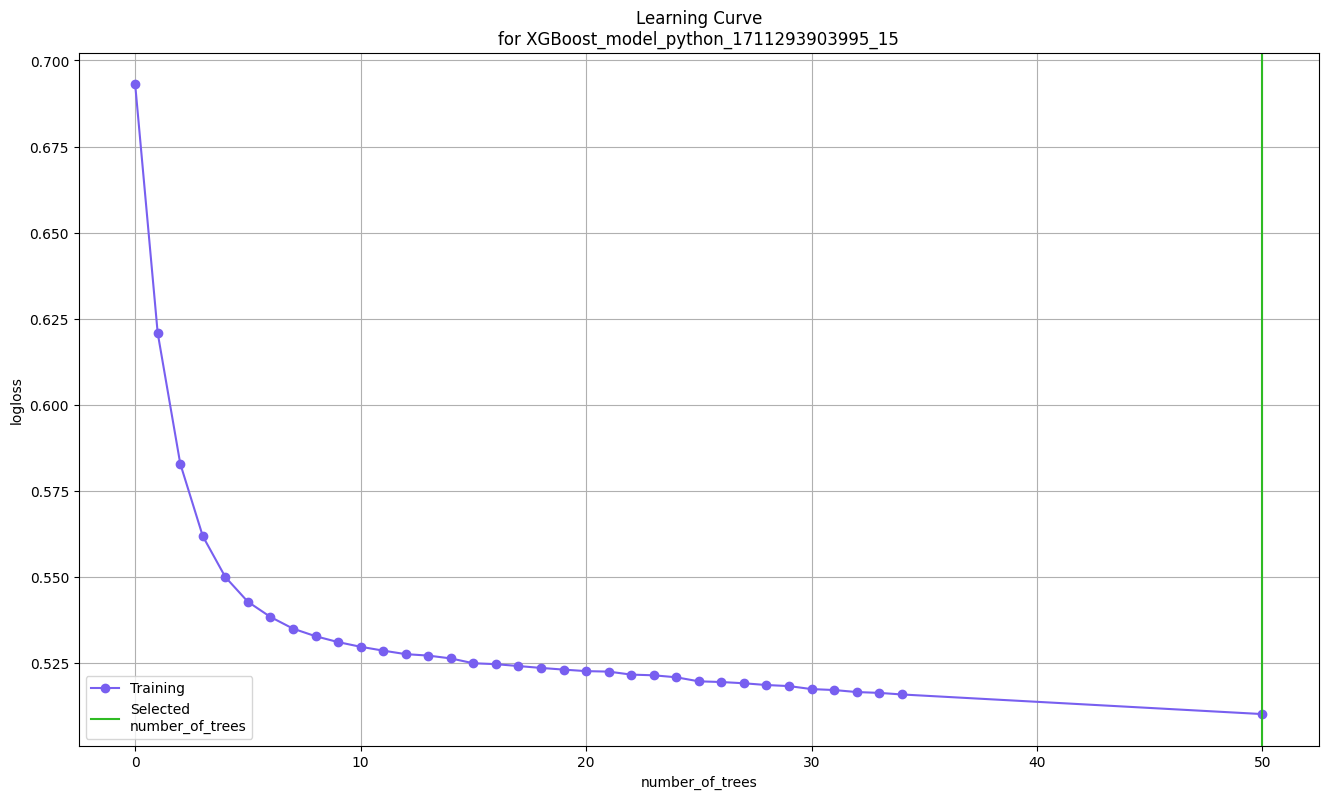

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

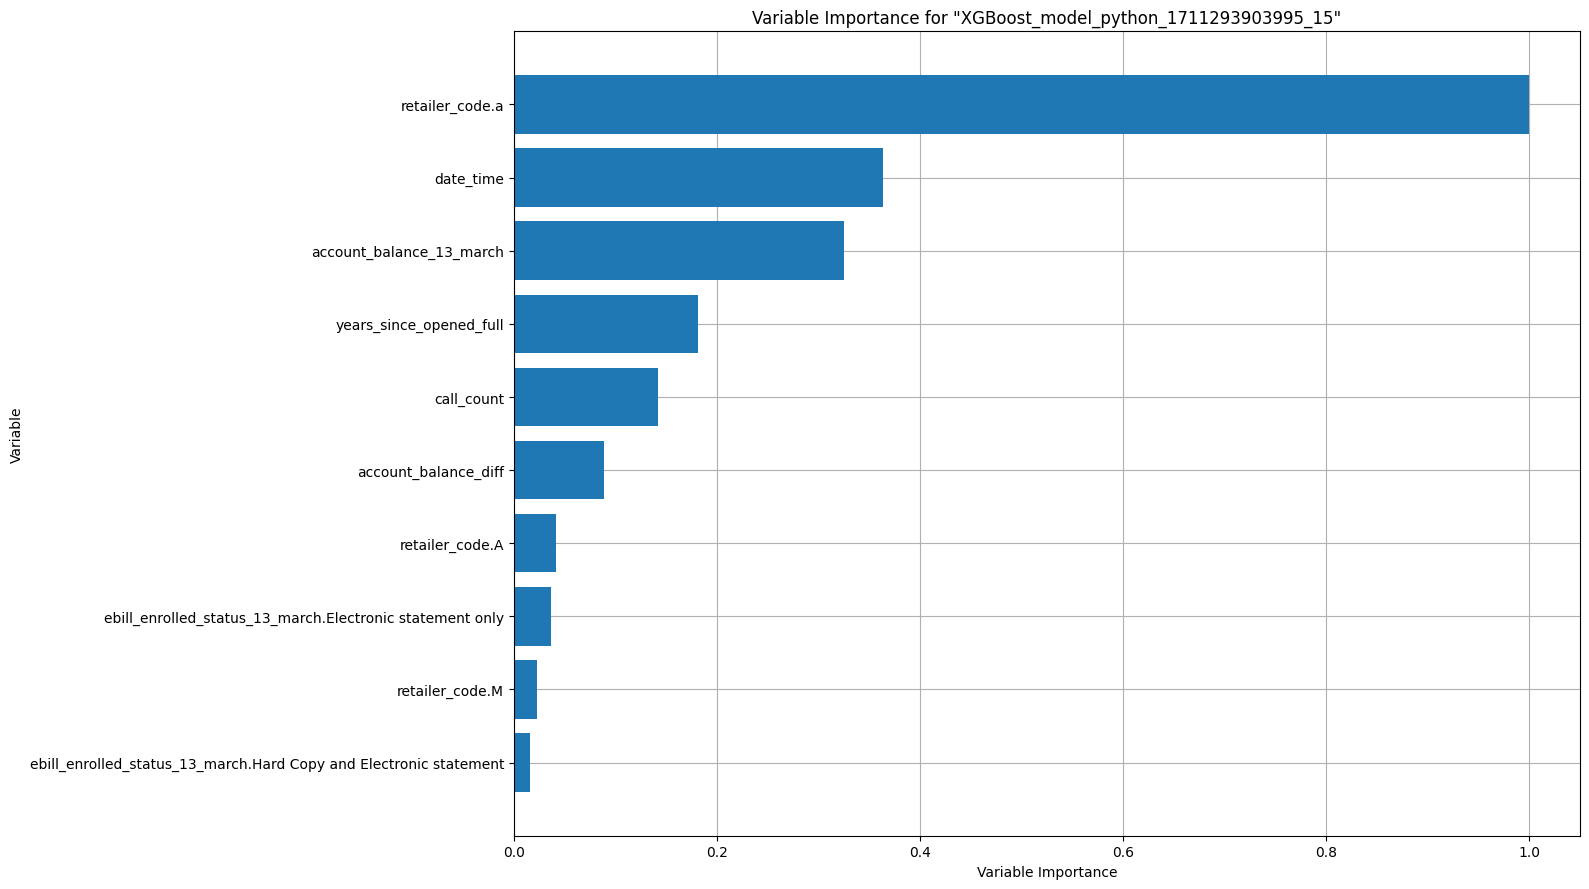

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

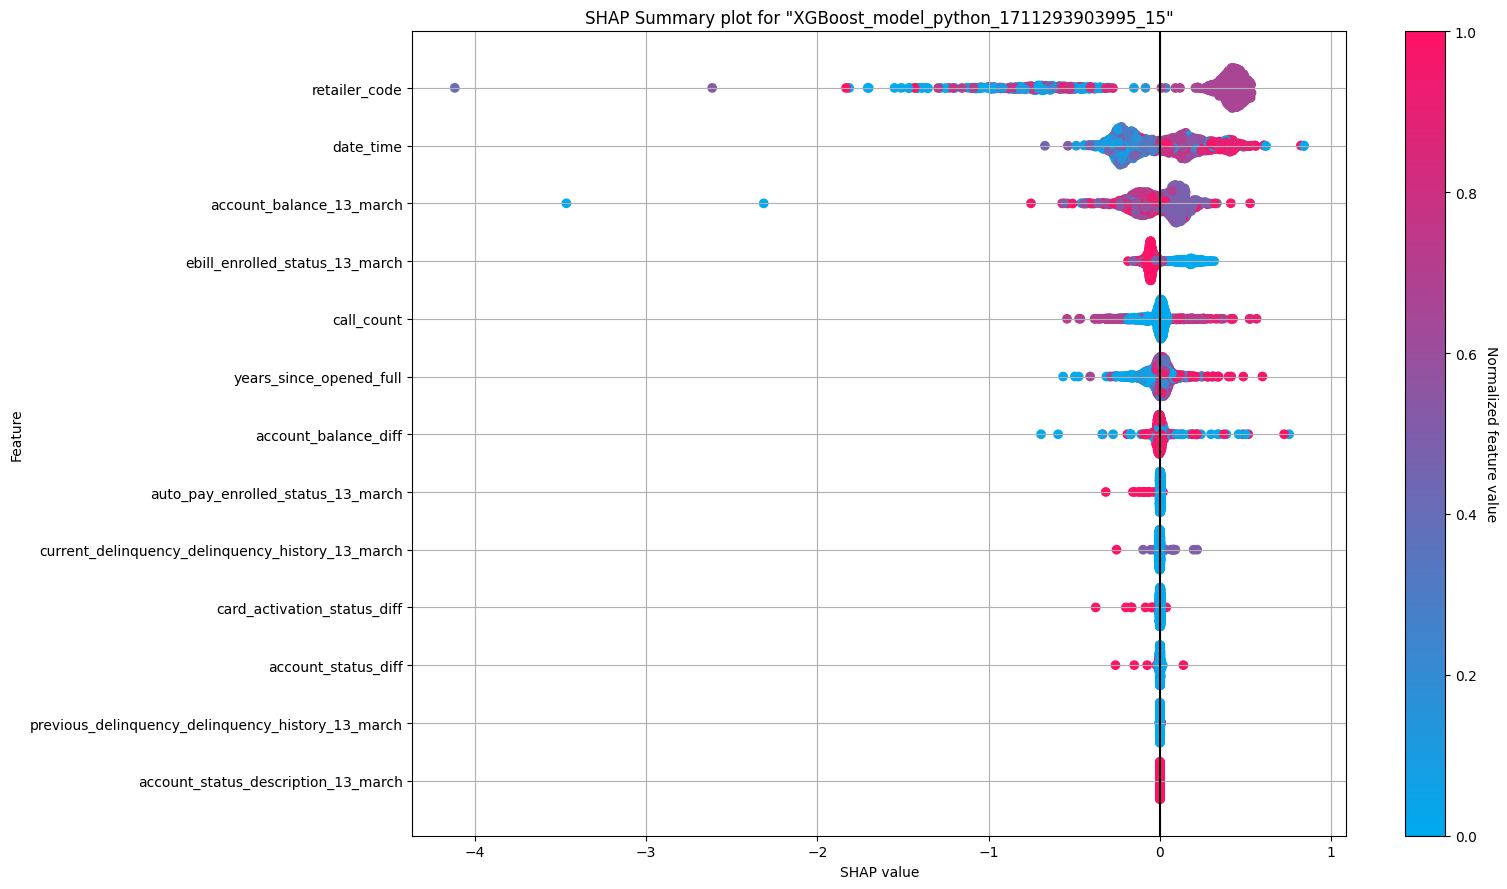

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

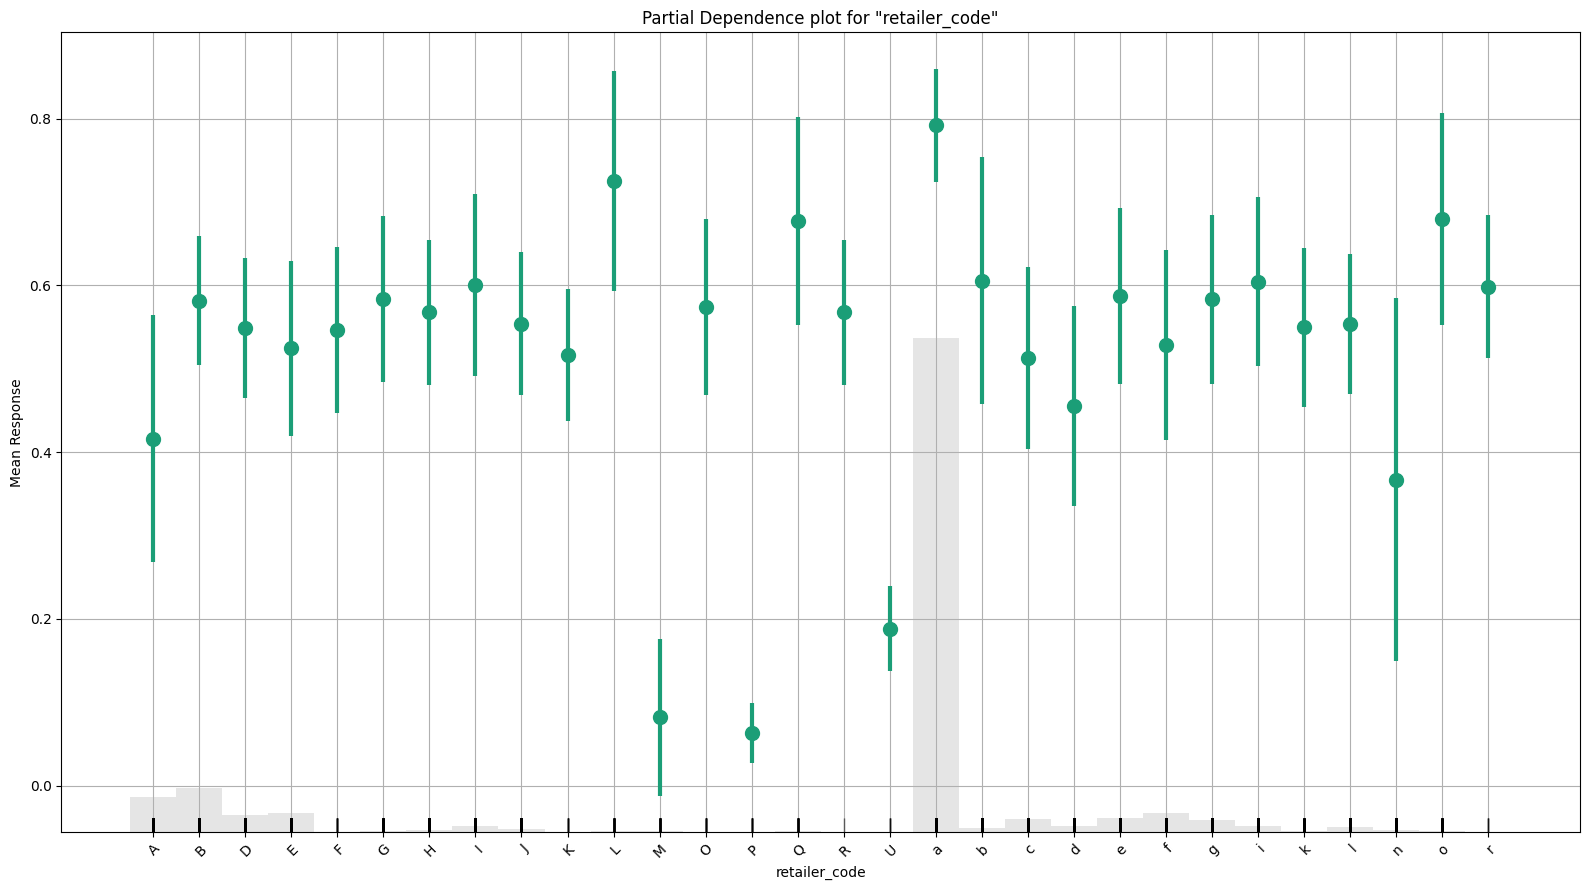

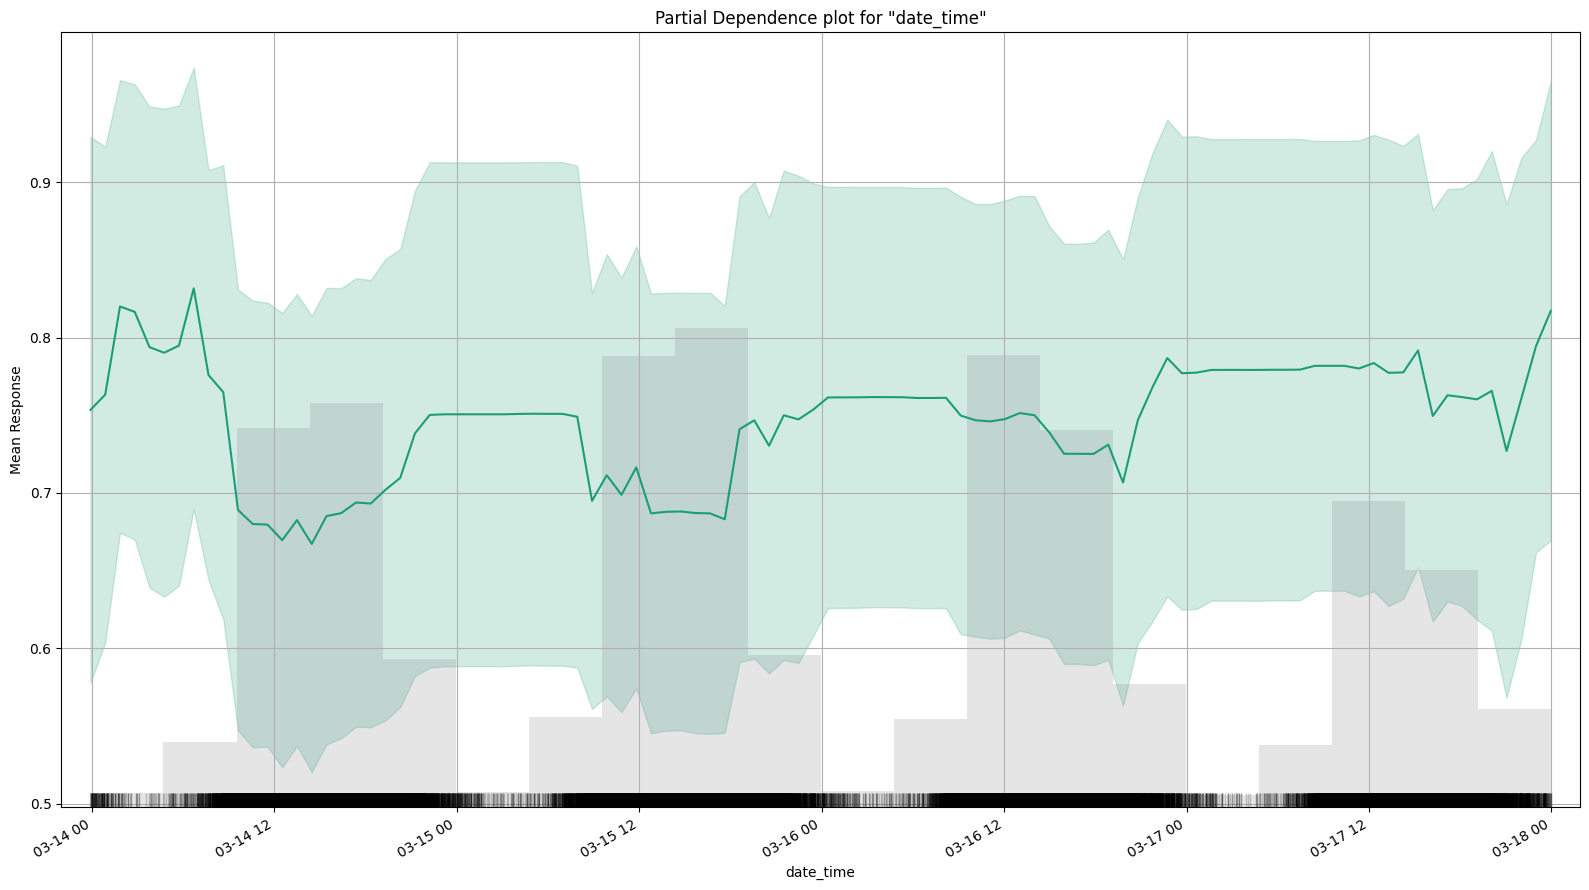

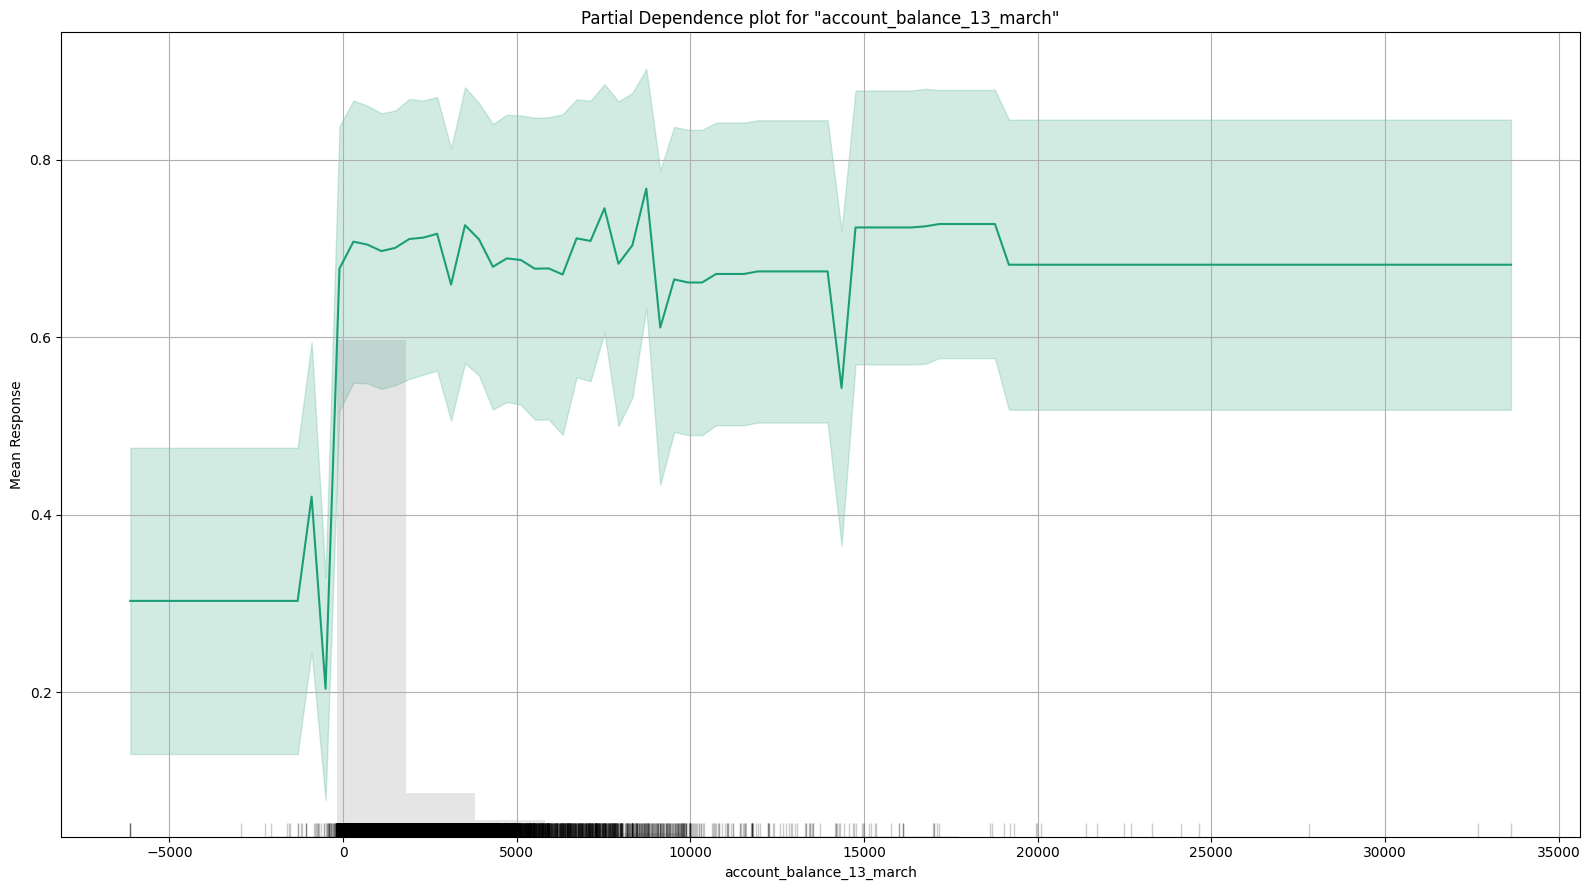

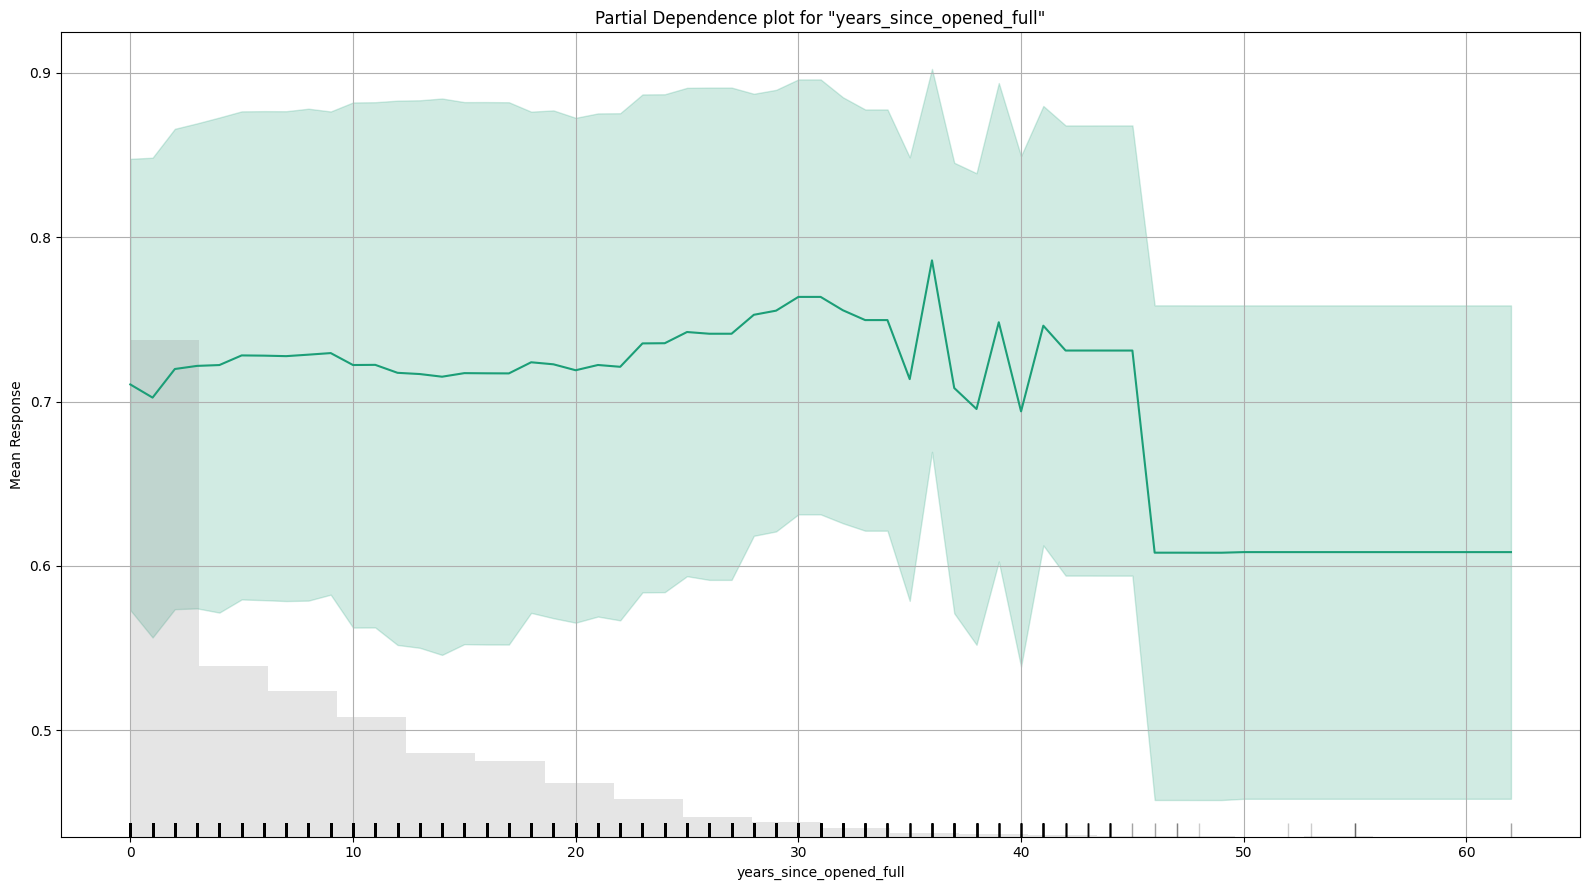

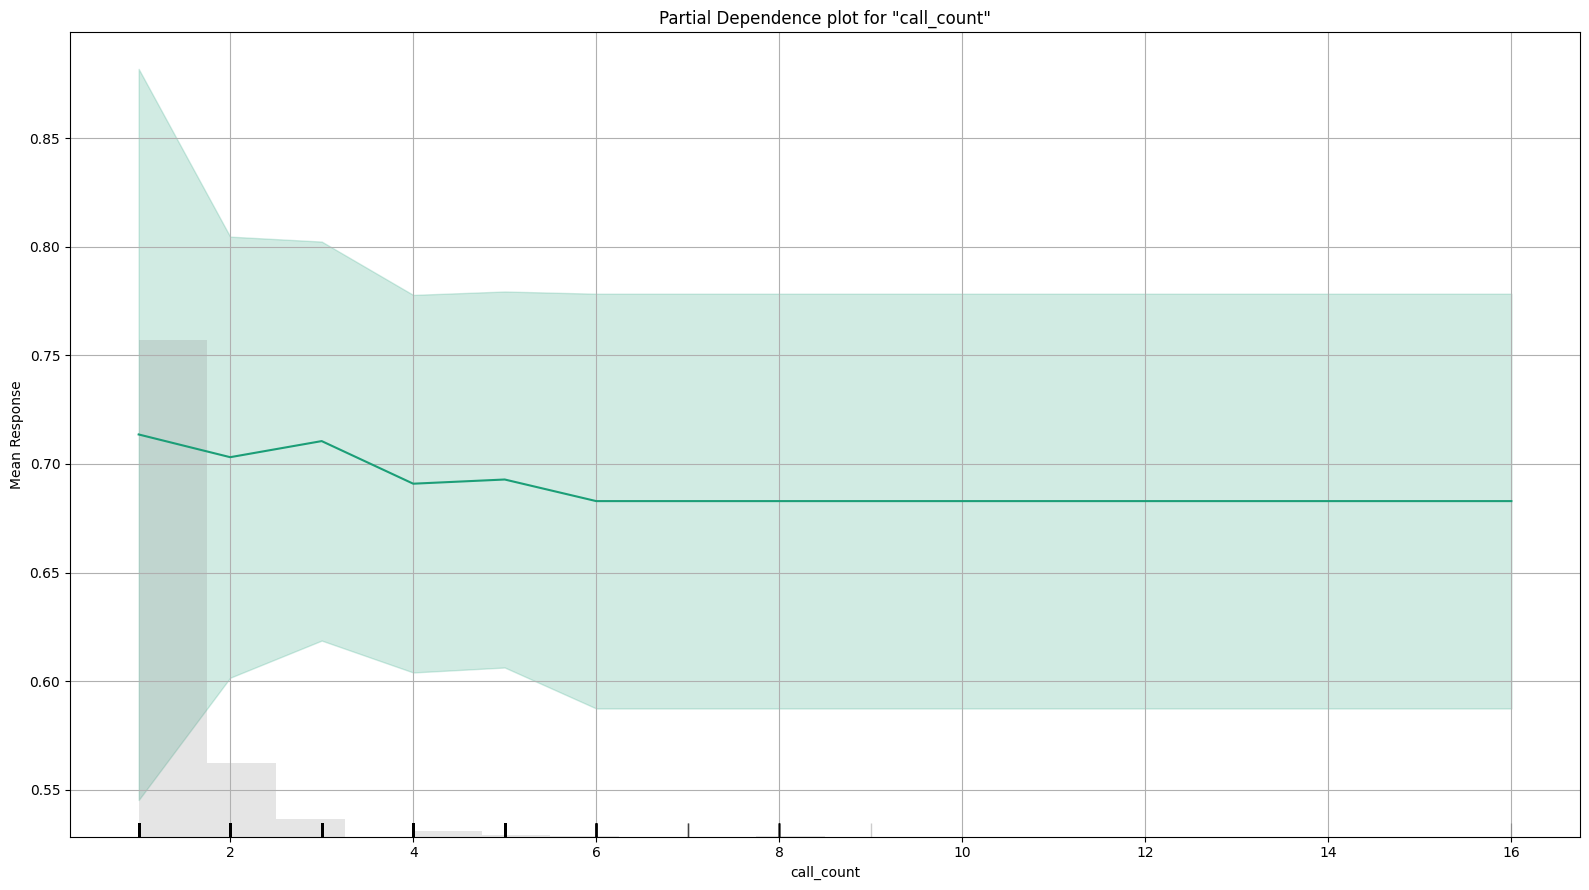



H2OExplanation([('confusion_matrix', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x78127194b3d0>), ('description', <h2o.explanation._explain.Description object at 0x7812719499c0>), ('subexplanations', H2OExplanation([('XGBoost_model_python_1711293903995_15', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x7812719494e0>), ('plots', H2OExplanation([('XGBoost_model_python_1711293903995_15', ConfusionMatrix({'table': H2OTwoDimTable({'_table_header': 'Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48673491428295773', '_col_header': ['', 'floor', 'resolved', 'Error', 'Rate']})}))]))]))]))])), ('learning_curve', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x781271948670>), ('description', <h2o.explanation._explain.Description object at 0x781271948160>), ('plots', H2OExplanation([('XGBoost_model_python_1711293903995_15', <h2o.plot._plot_result._MObject object at 0x7812f22f4070>)]))])), ('varimp', H2OExplanati

In [ ]:
train_and_evaluate_model(data, 'resolved', predictor, 'AA')

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
Model Details
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_model_python_1711238888447_199


Model Summary: 
    number_of_trees
--  -----------------
    50

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.024665604599916624
RMSE: 0.15705287198875614
LogLoss: 0.09971742231189296
Mean Per-Class Error: 0.2901413720441395
AUC: 0.9112998251362144
AUCPR: 0.4556011694096478
Gini: 0.8225996502724289

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.10125721163219875
          floor    resolved    Error    Rate
--------  -------  ----------  -------  ---------------
floor     18288    260         0.014    (260.0/18548.0)
resolved  329      252         0.5663   (329.0/581.0)
Total     18617    512         0.0308   (589.0/19129.0)

Maximum Metrics: Maximum metrics at their respec

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## XGBoost_model_python_1711238888447_199

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.10125721163219875
          floor    resolved    Error    Rate
--------  -------  ----------  -------  ---------------
floor     18288    260         0.014    (260.0/18548.0)
resolved  329      252         0.5663   (329.0/581.0)
Total     18617    512         0.0308   (589.0/19129.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

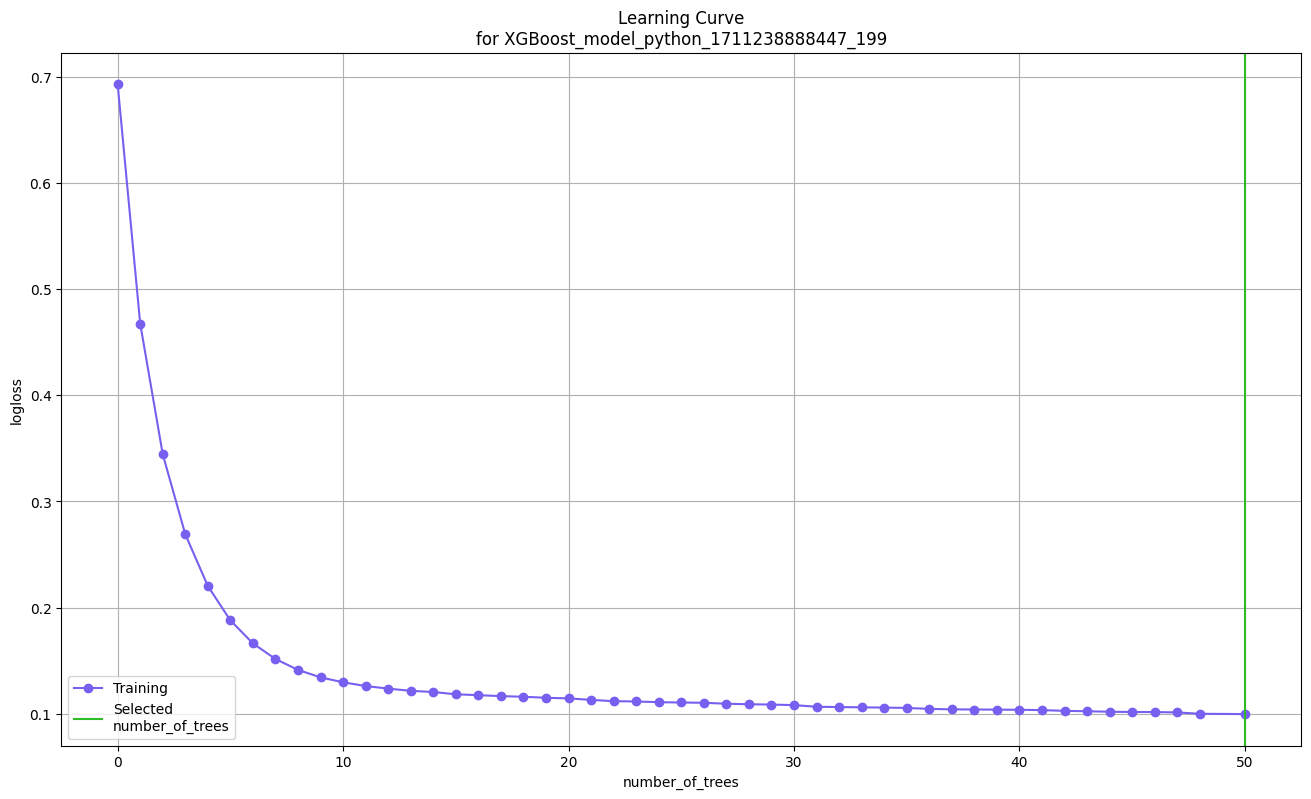

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

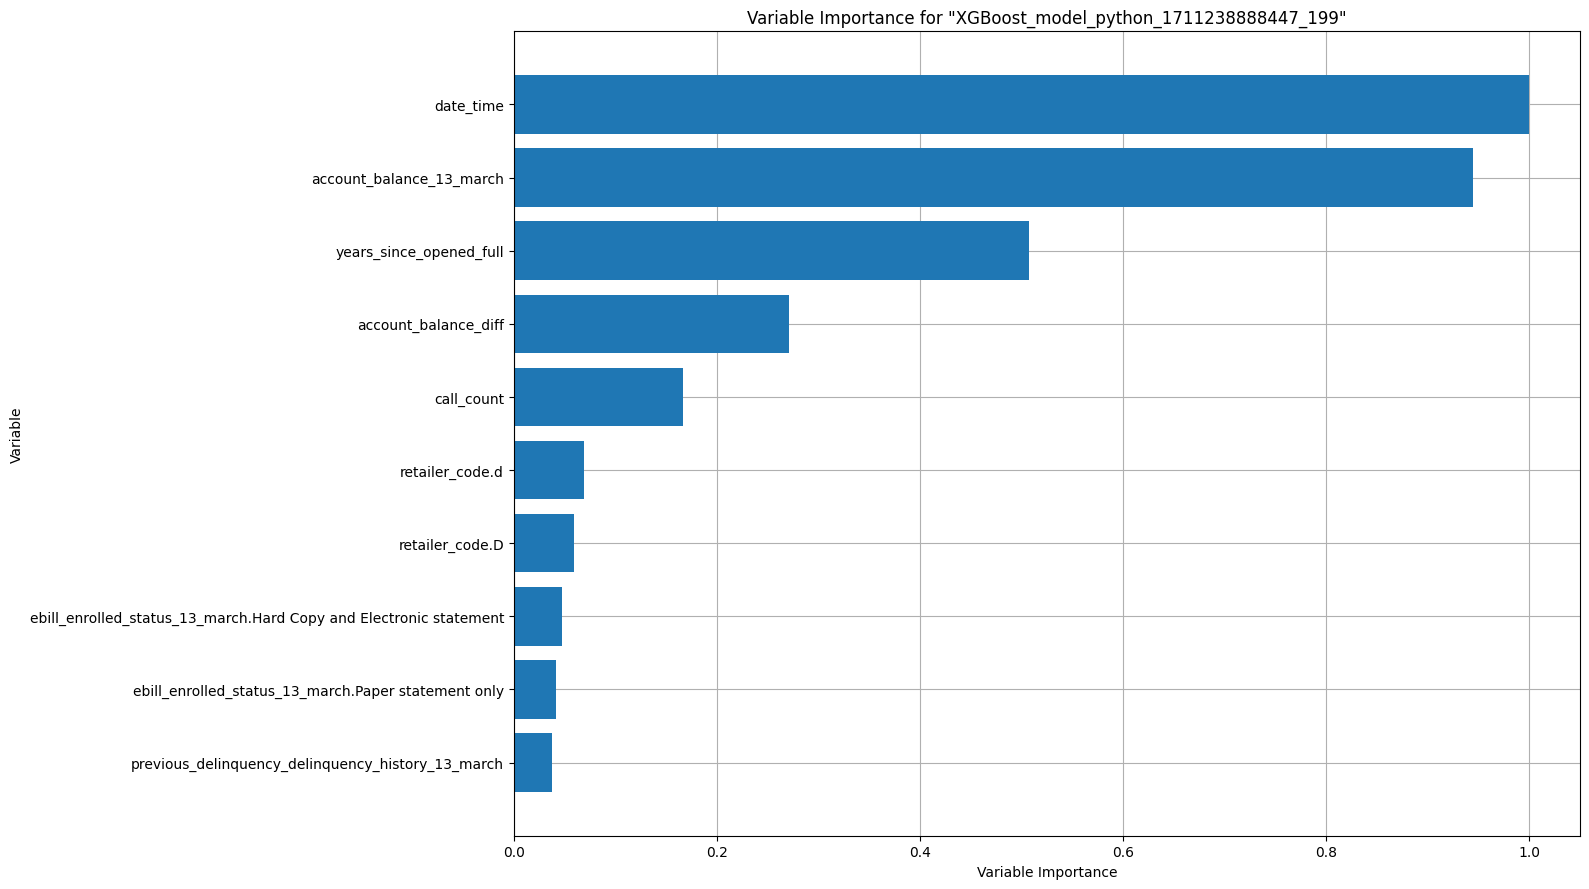

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

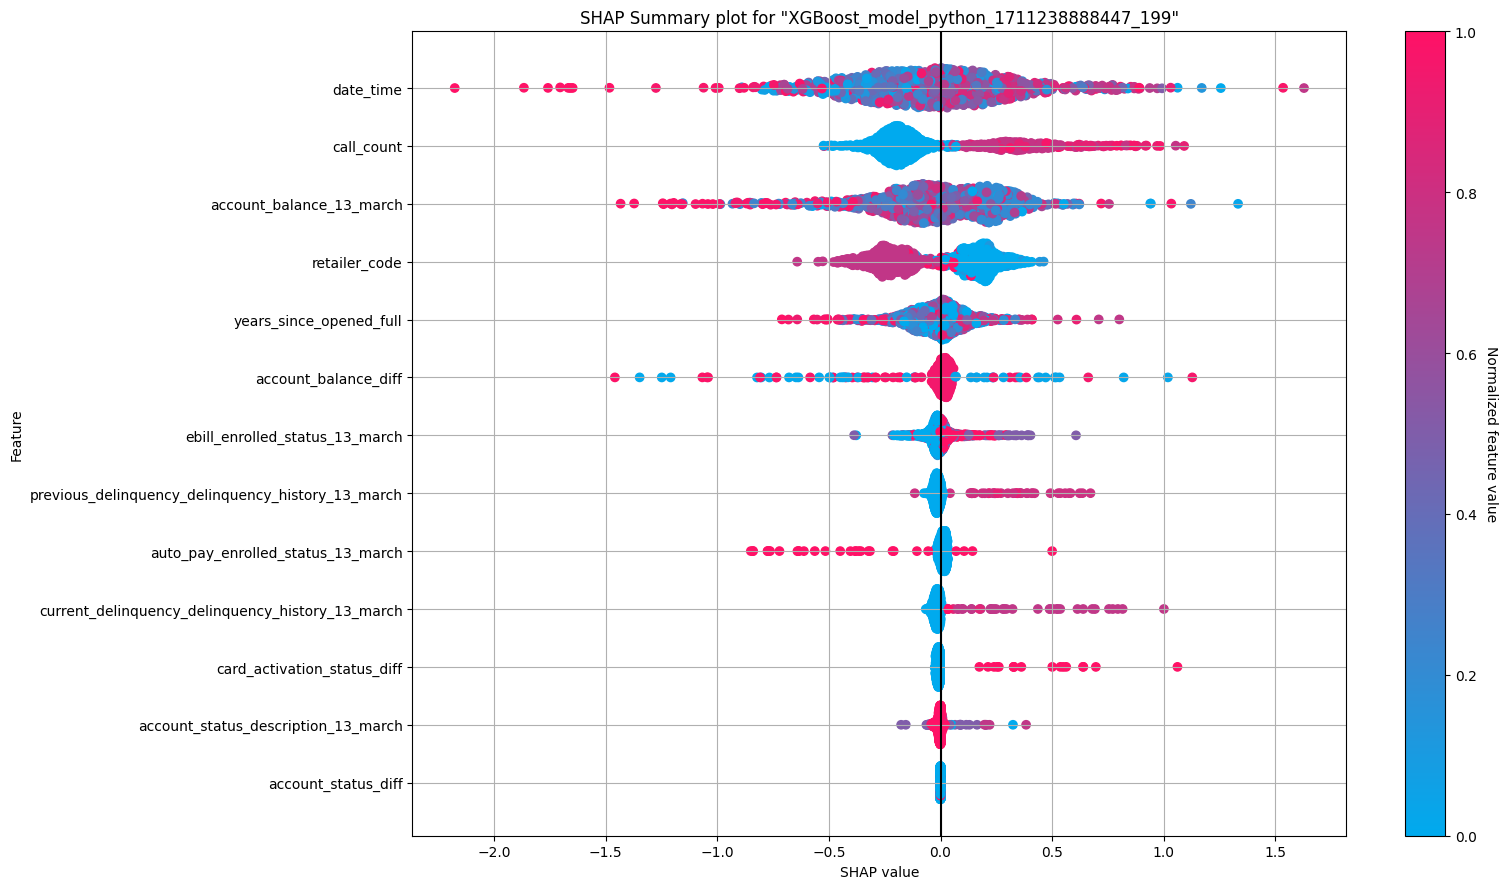

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

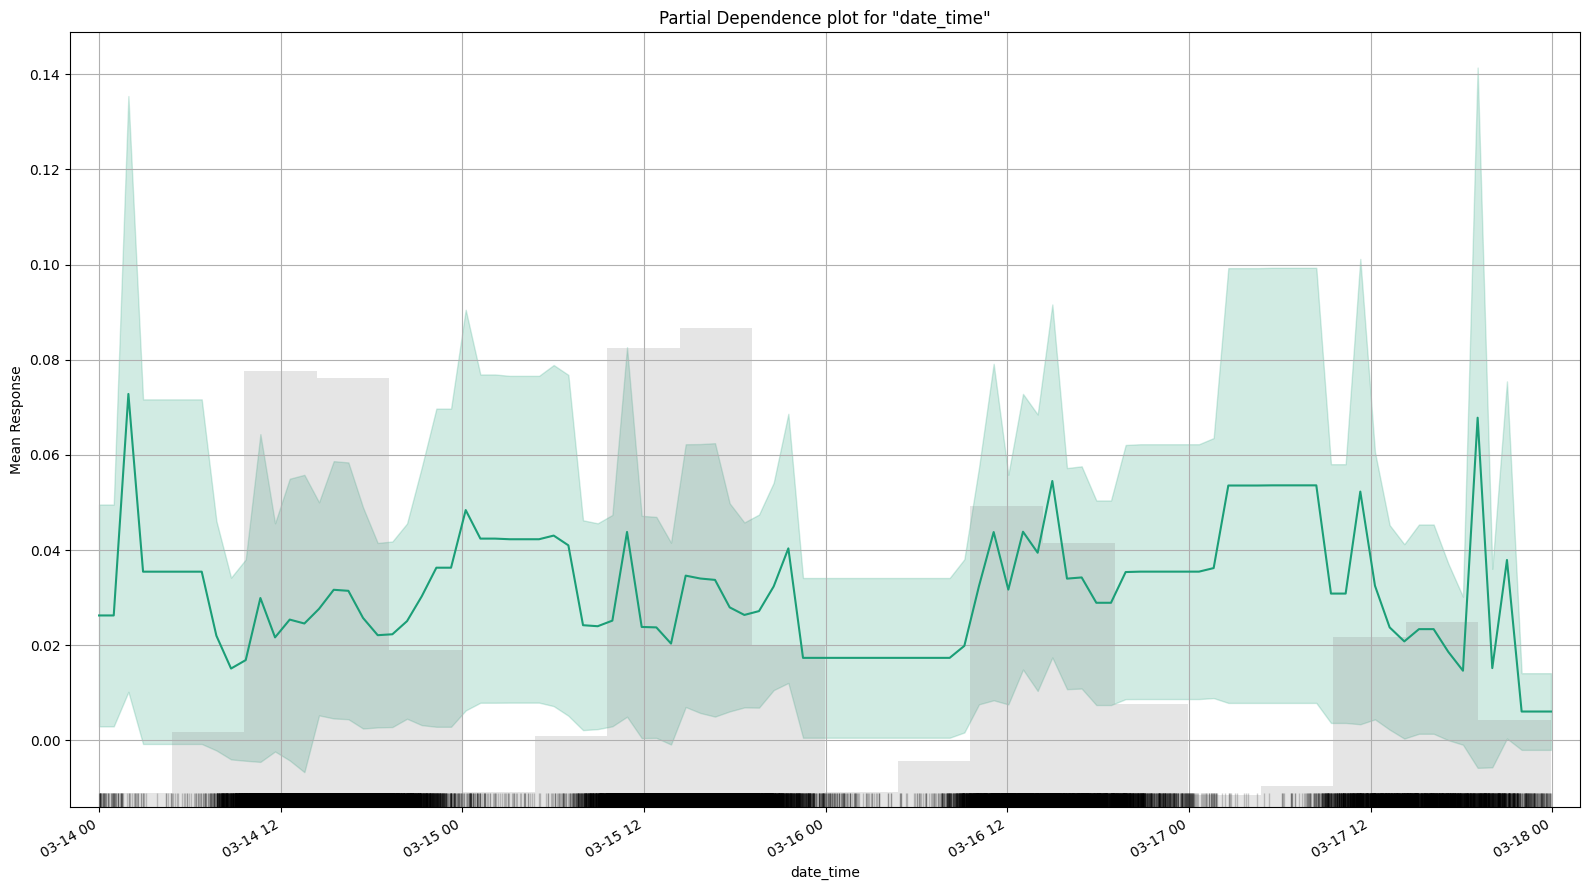

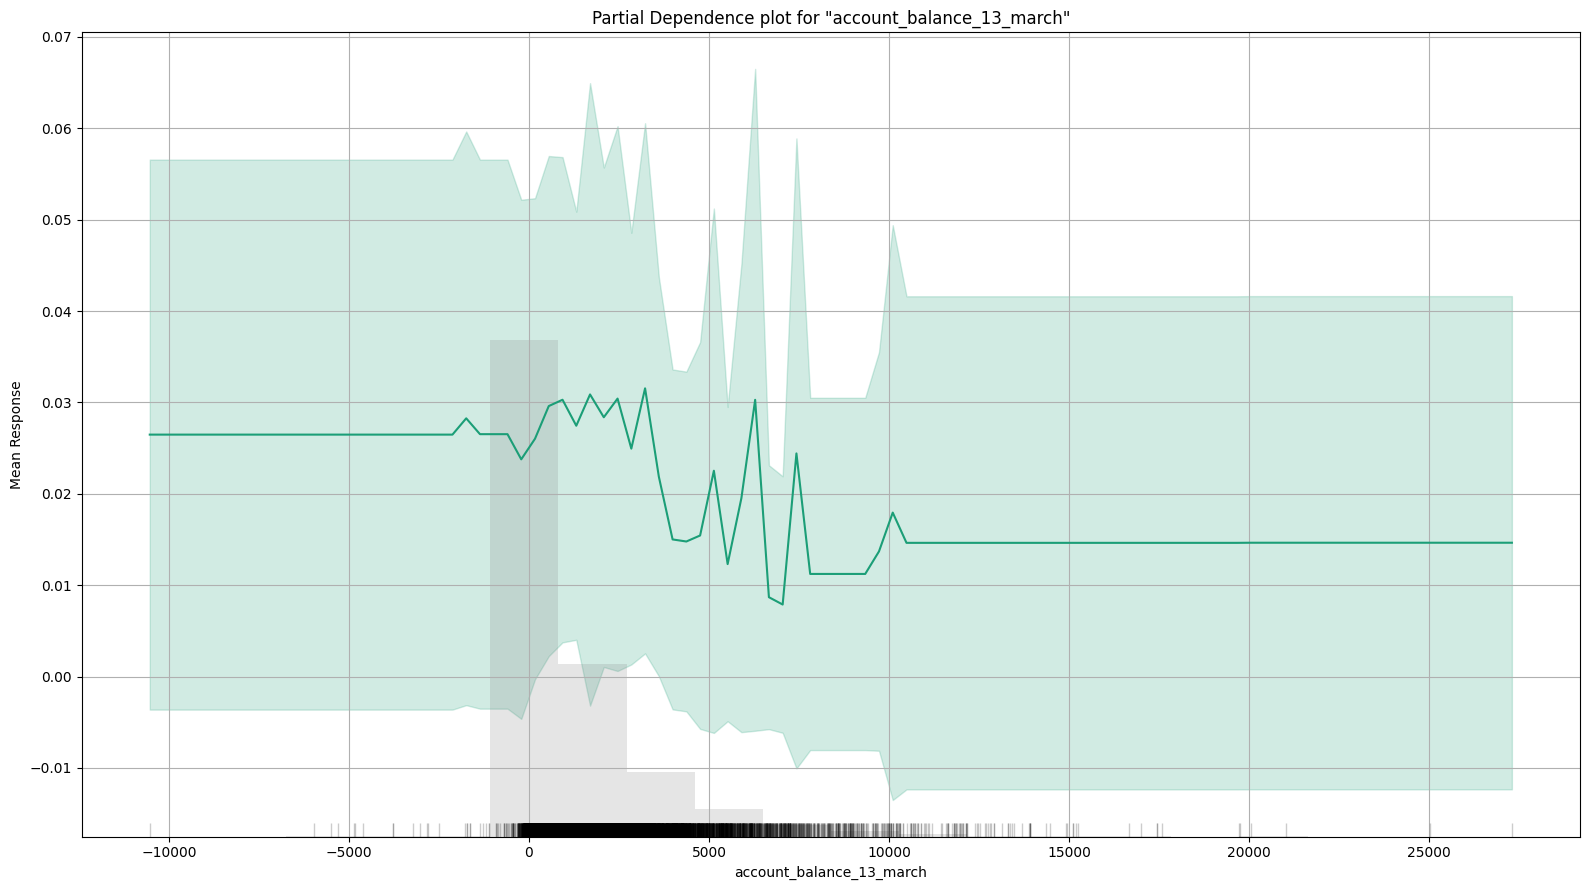

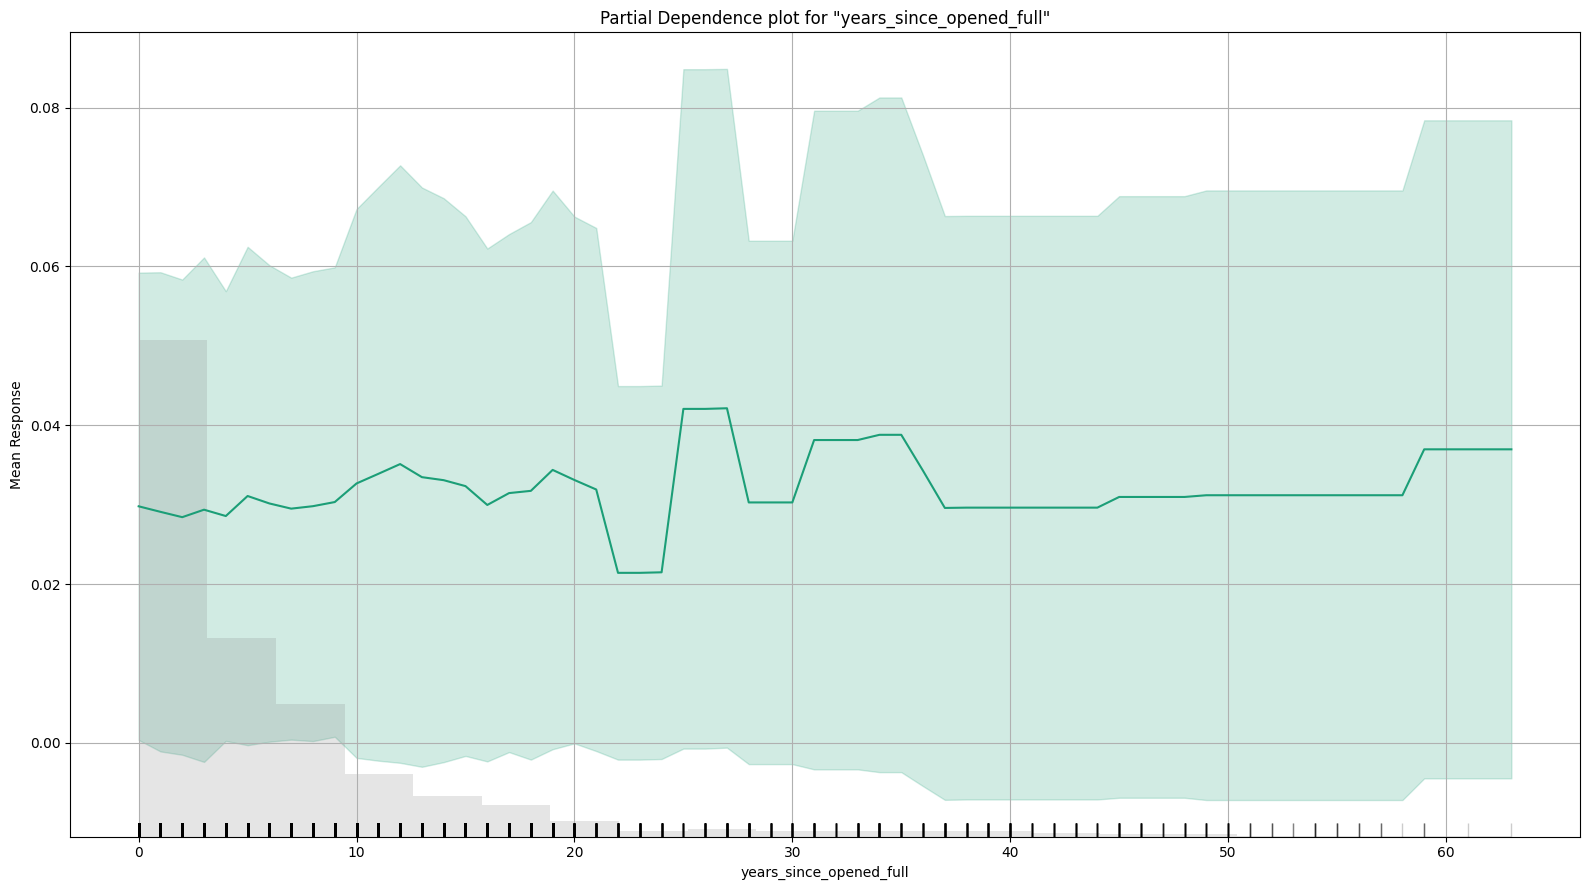

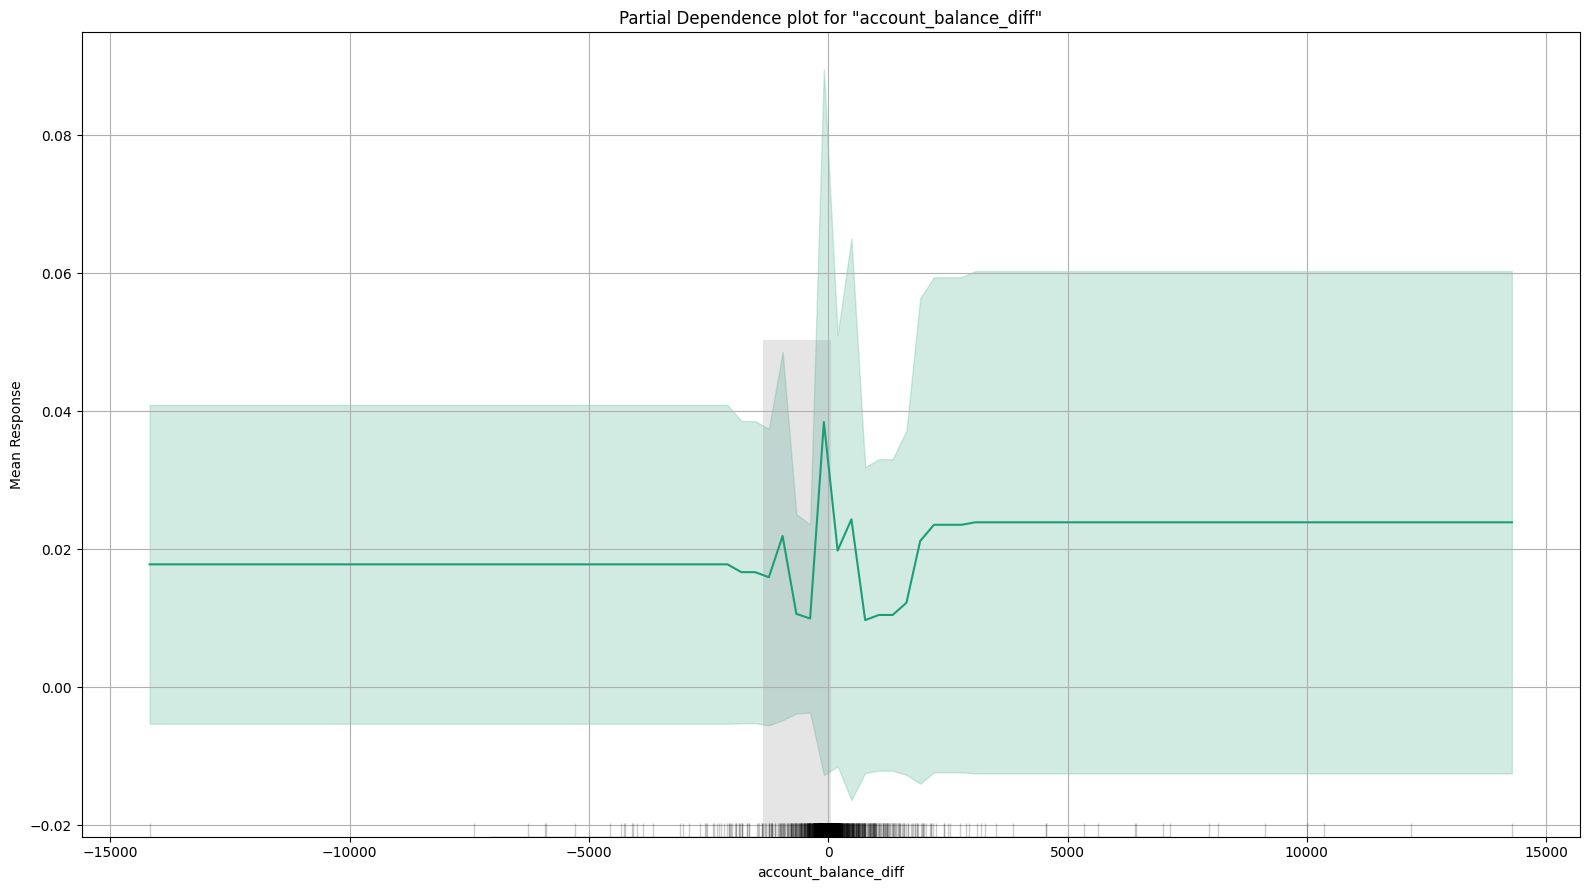

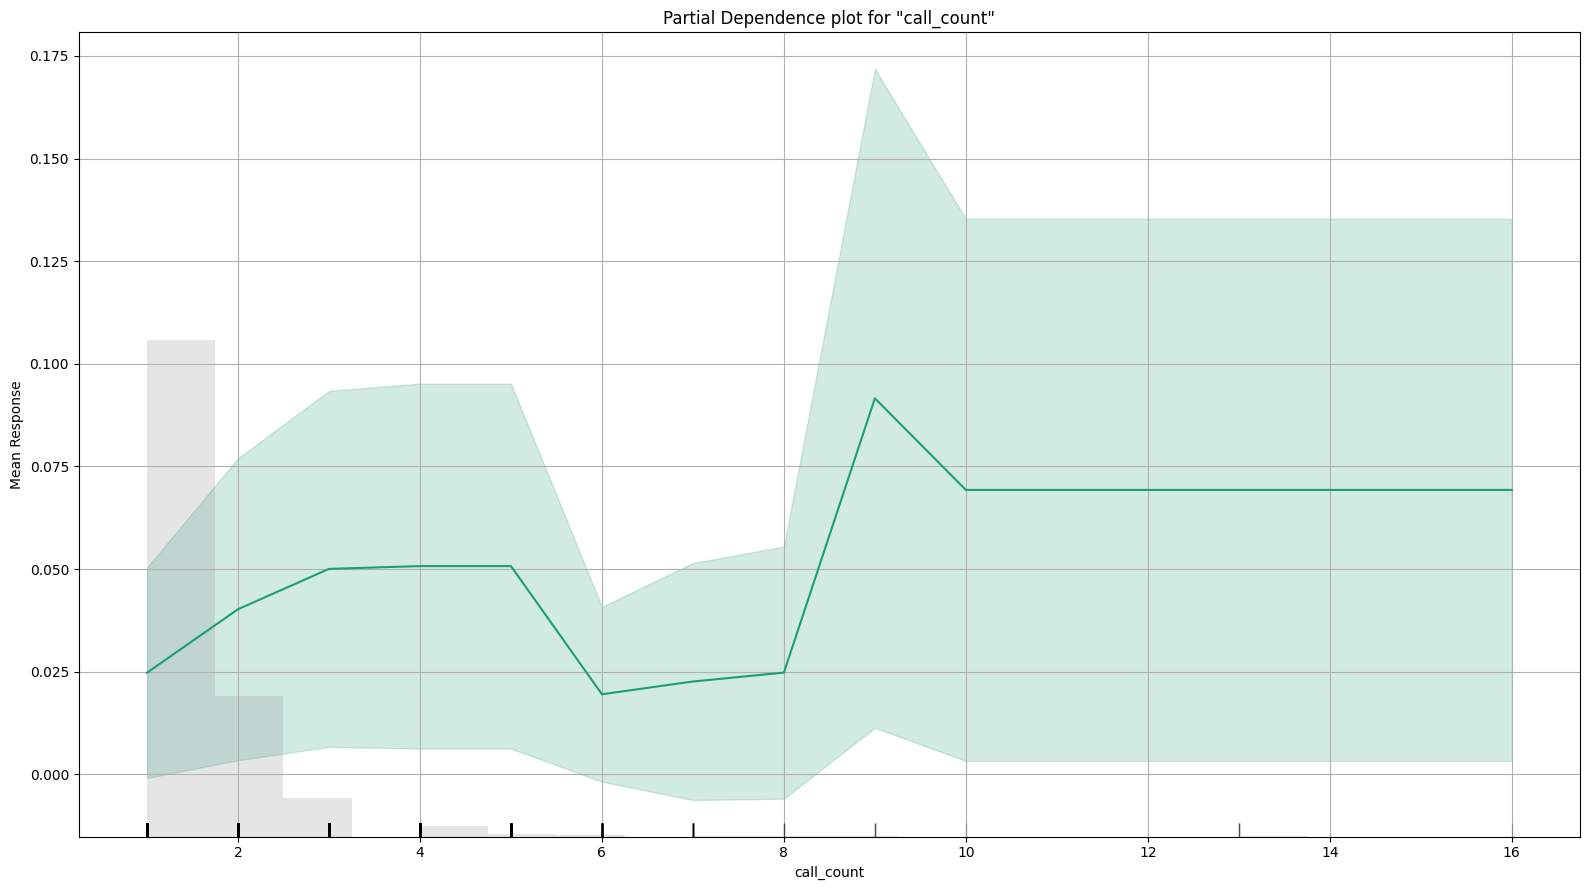



H2OExplanation([('confusion_matrix', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x78ec116a0f40>), ('description', <h2o.explanation._explain.Description object at 0x78ec3a423f70>), ('subexplanations', H2OExplanation([('XGBoost_model_python_1711238888447_199', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x78ebd912e560>), ('plots', H2OExplanation([('XGBoost_model_python_1711238888447_199', ConfusionMatrix({'table': H2OTwoDimTable({'_table_header': 'Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.10125721163219875', '_col_header': ['', 'floor', 'resolved', 'Error', 'Rate']})}))]))]))]))])), ('learning_curve', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x78ebdd37bb50>), ('description', <h2o.explanation._explain.Description object at 0x78ec10e3b430>), ('plots', H2OExplanation([('XGBoost_model_python_1711238888447_199', <h2o.plot._plot_result._MObject object at 0x78ec10a1c3a0>)]))])), ('varimp', H2OExplan

In [ ]:
train_and_evaluate_model(data, 'resolved', predictor, 'CT')

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
Model Details
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_model_python_1711238888447_88


Model Summary: 
    number_of_trees
--  -----------------
    50

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.044942807851373924
RMSE: 0.2119971883100668
LogLoss: 0.18273723470710201
Mean Per-Class Error: 0.48788841713829045
AUC: 0.698367254054562
AUCPR: 0.975451918897675
Gini: 0.39673450810912403

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6692935988820833
          floor    resolved    Error    Rate
--------  -------  ----------  -------  ------------------
floor     667      26196       0.9752   (26196.0/26863.0)
resolved  313      515741      0.0006   (313.0/516054.0)
Total     980      541937      0.0488   (26509.0/542917.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## XGBoost_model_python_1711238888447_88

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6692935988820833
          floor    resolved    Error    Rate
--------  -------  ----------  -------  ------------------
floor     667      26196       0.9752   (26196.0/26863.0)
resolved  313      515741      0.0006   (313.0/516054.0)
Total     980      541937      0.0488   (26509.0/542917.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

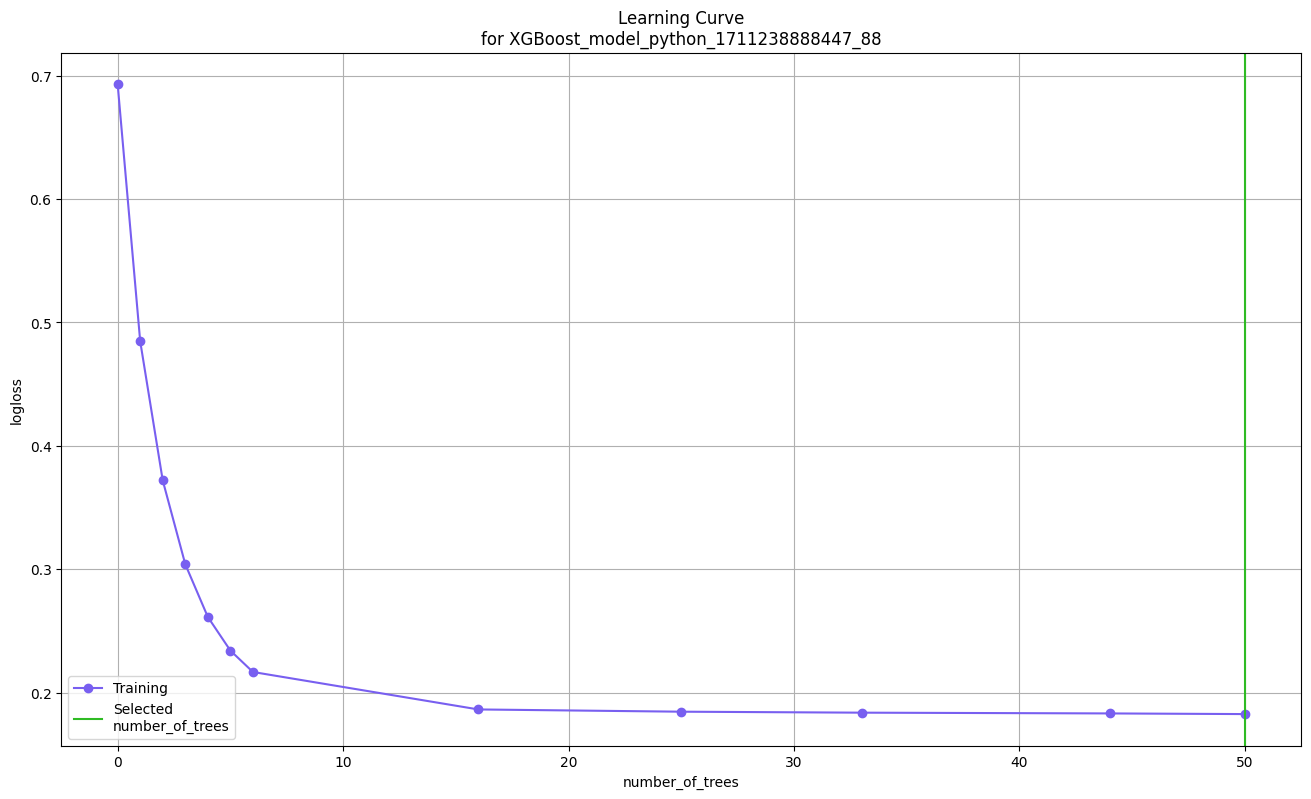

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

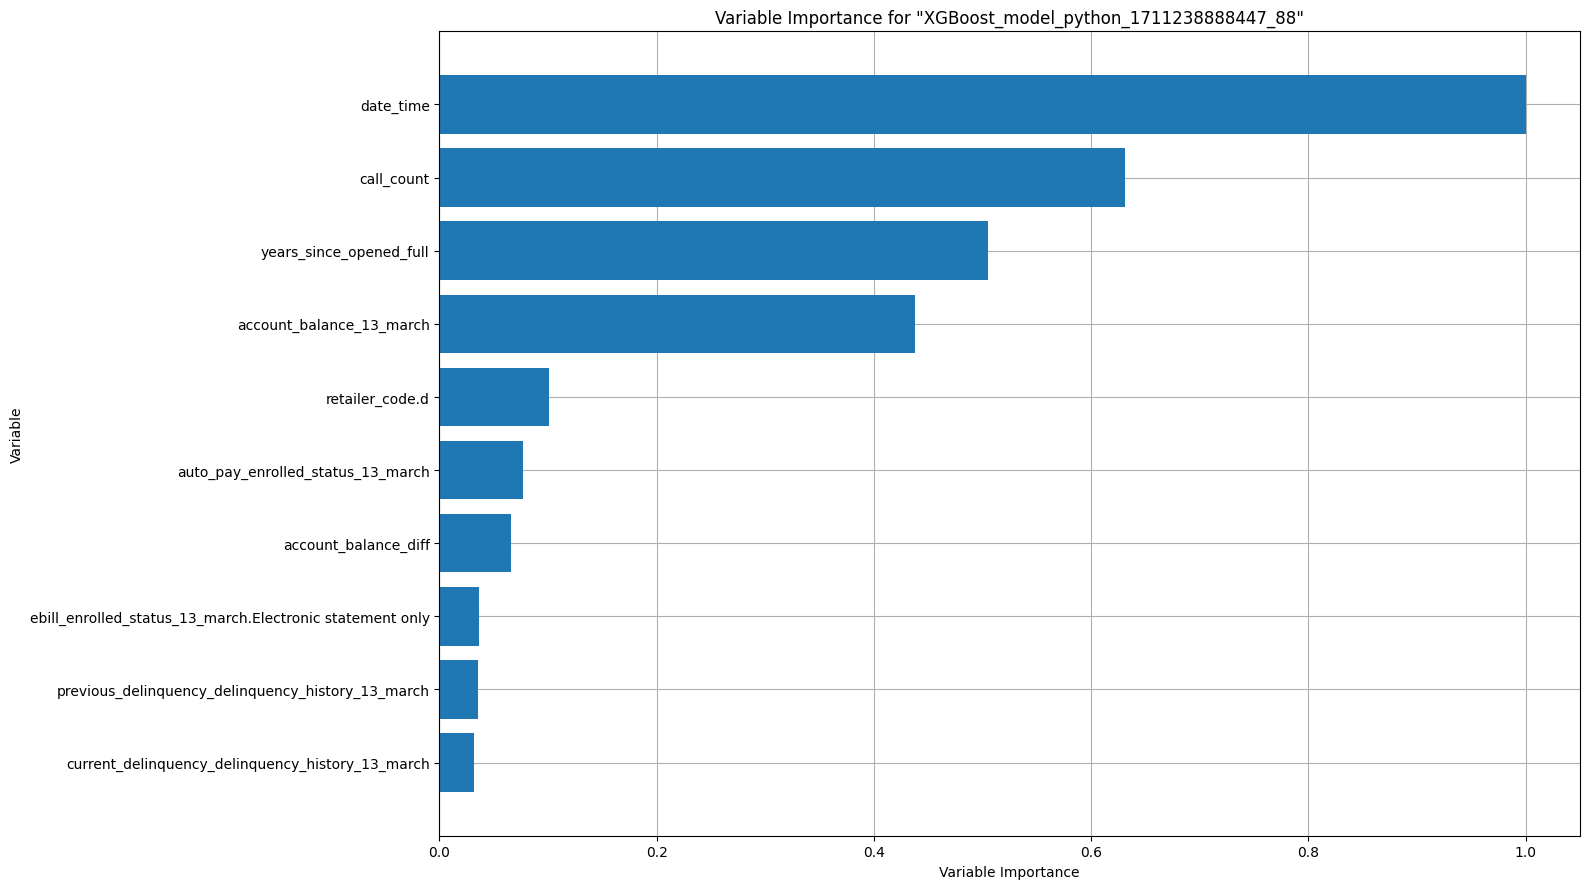

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

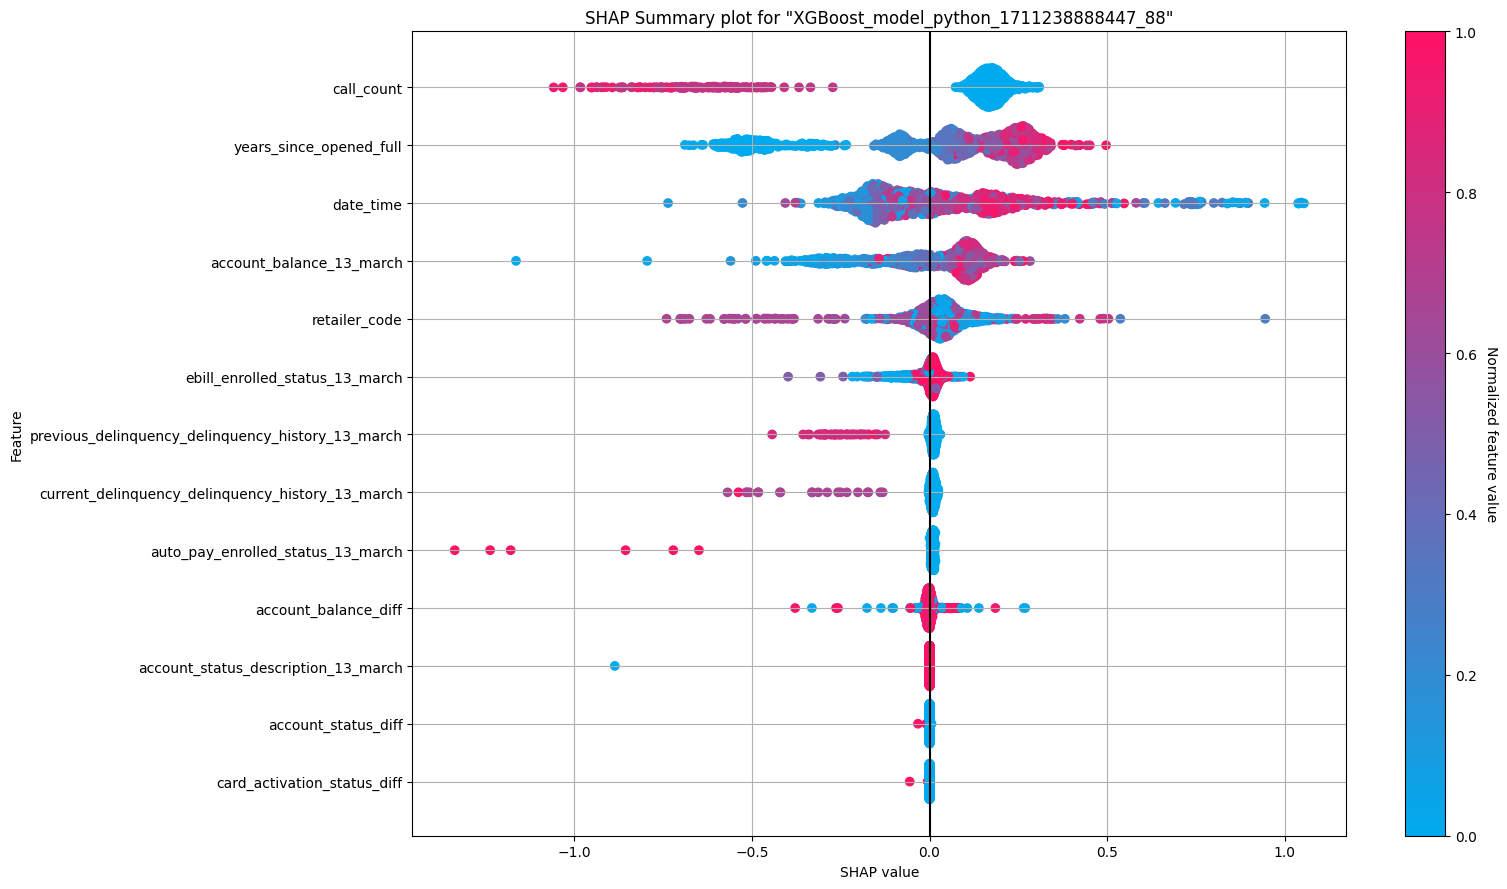

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

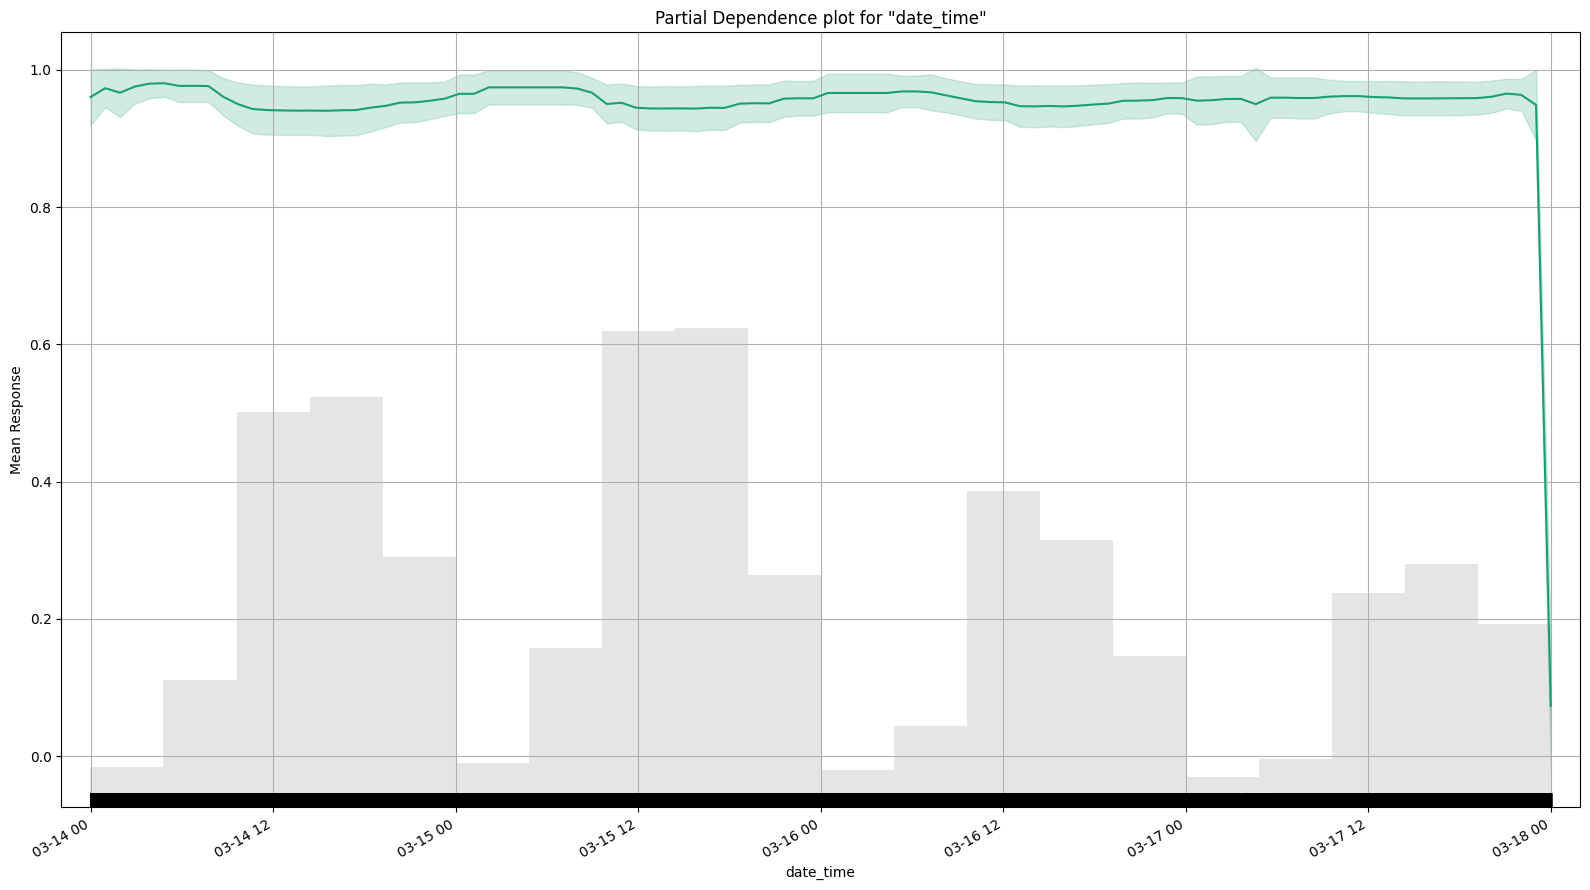

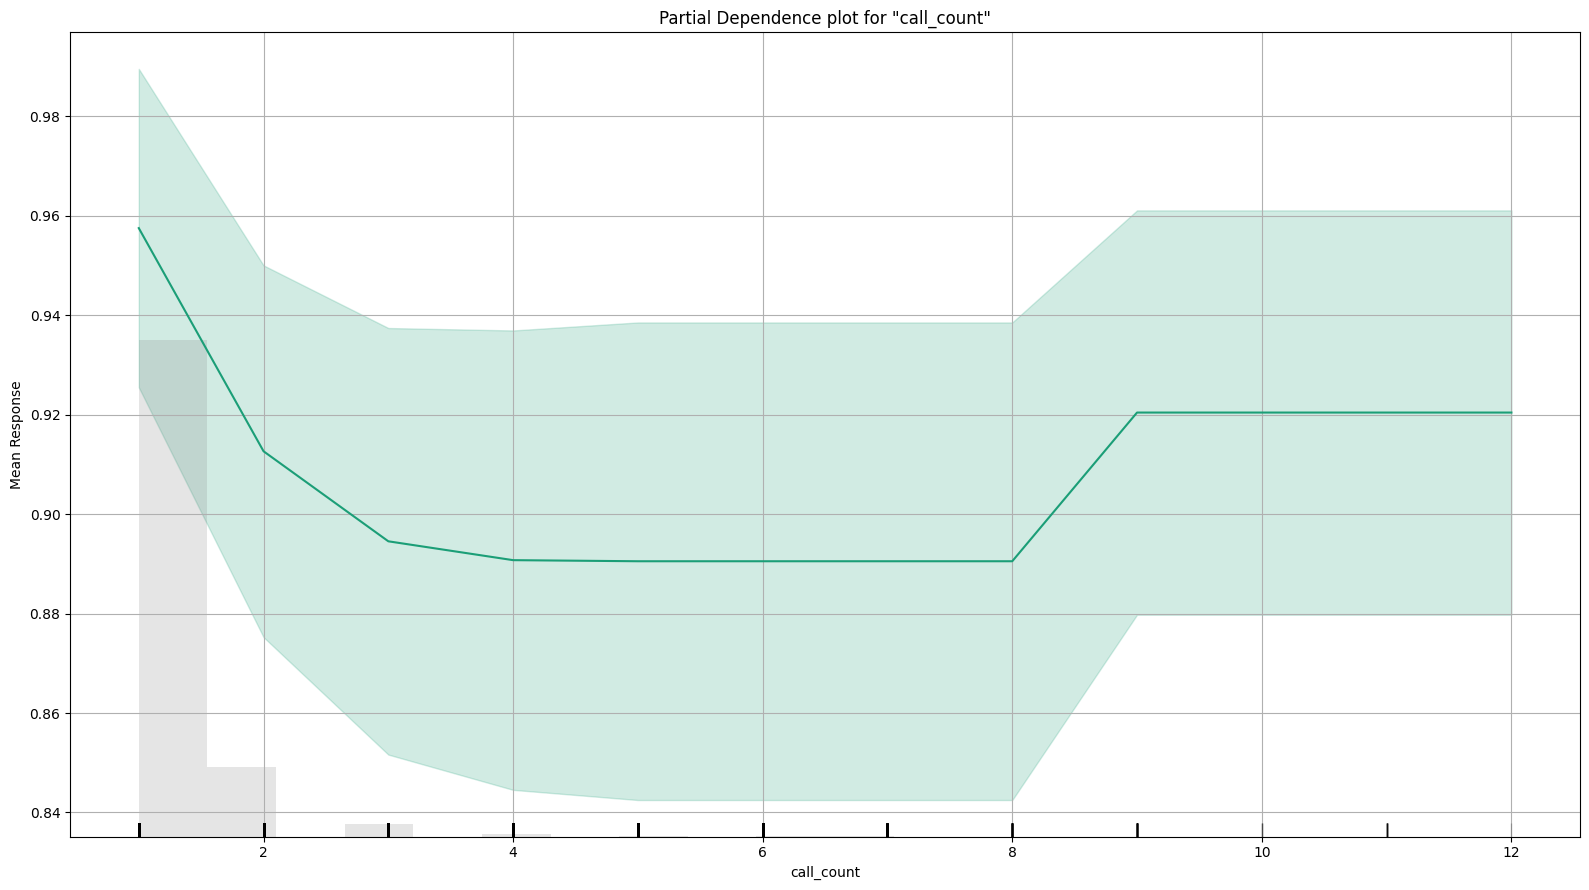

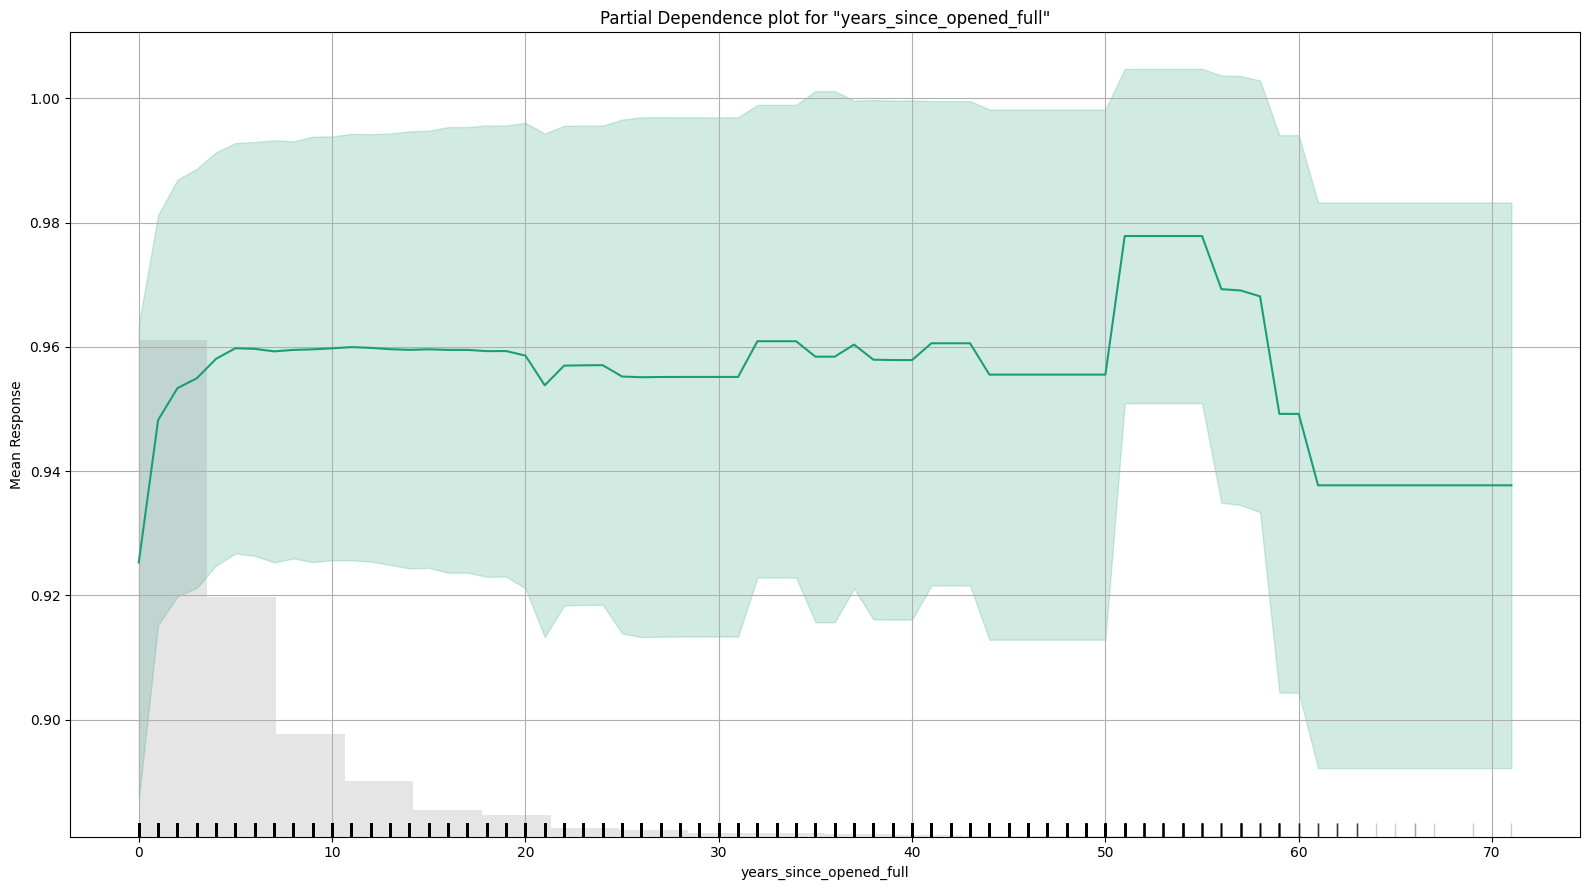

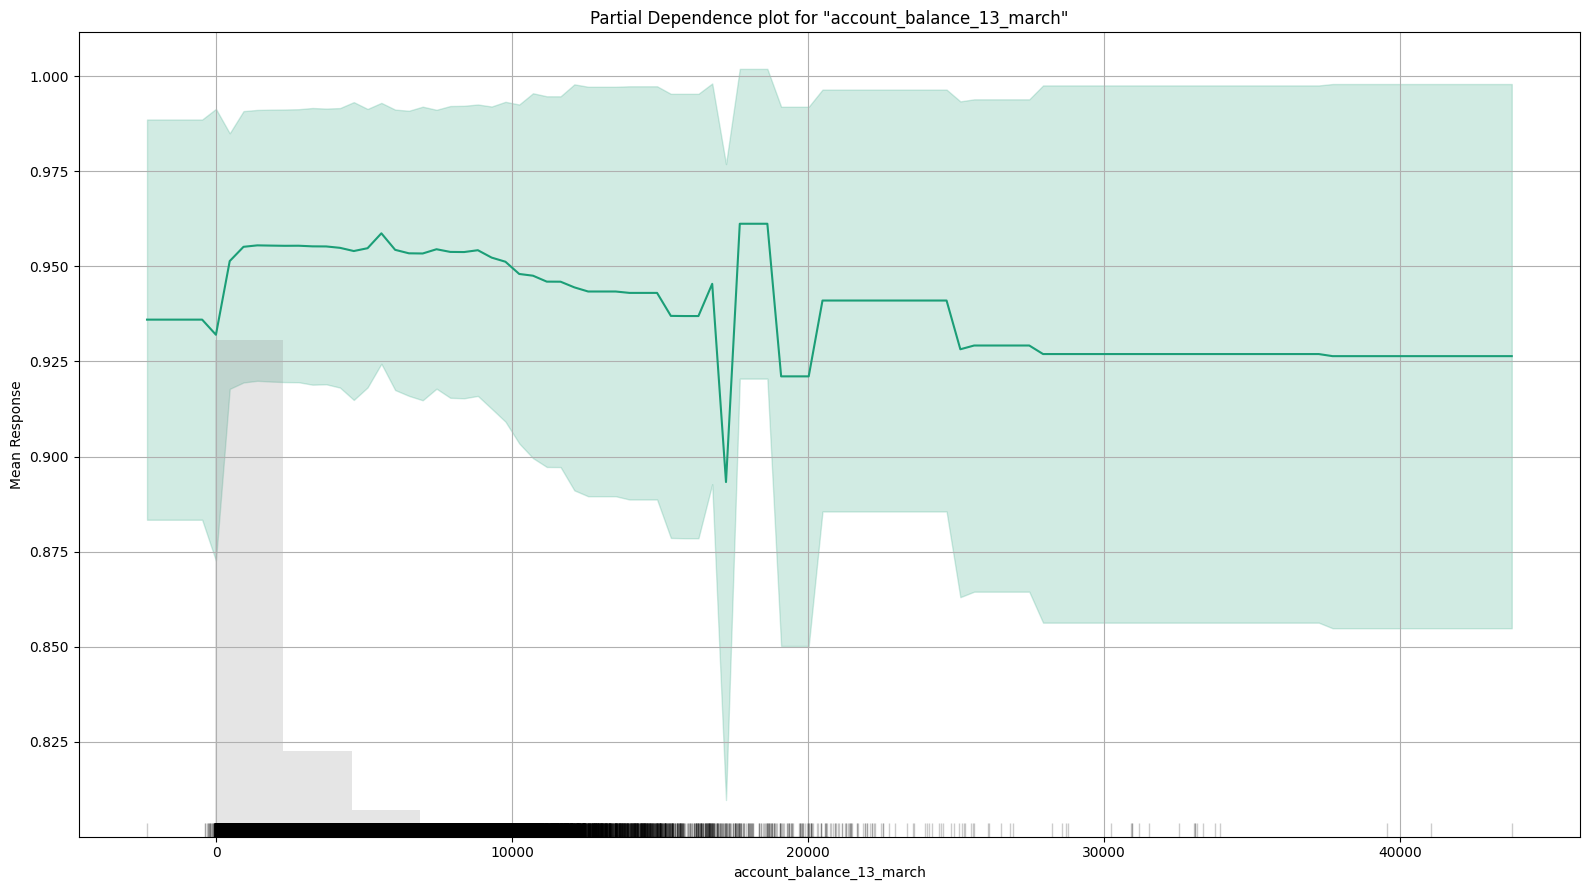

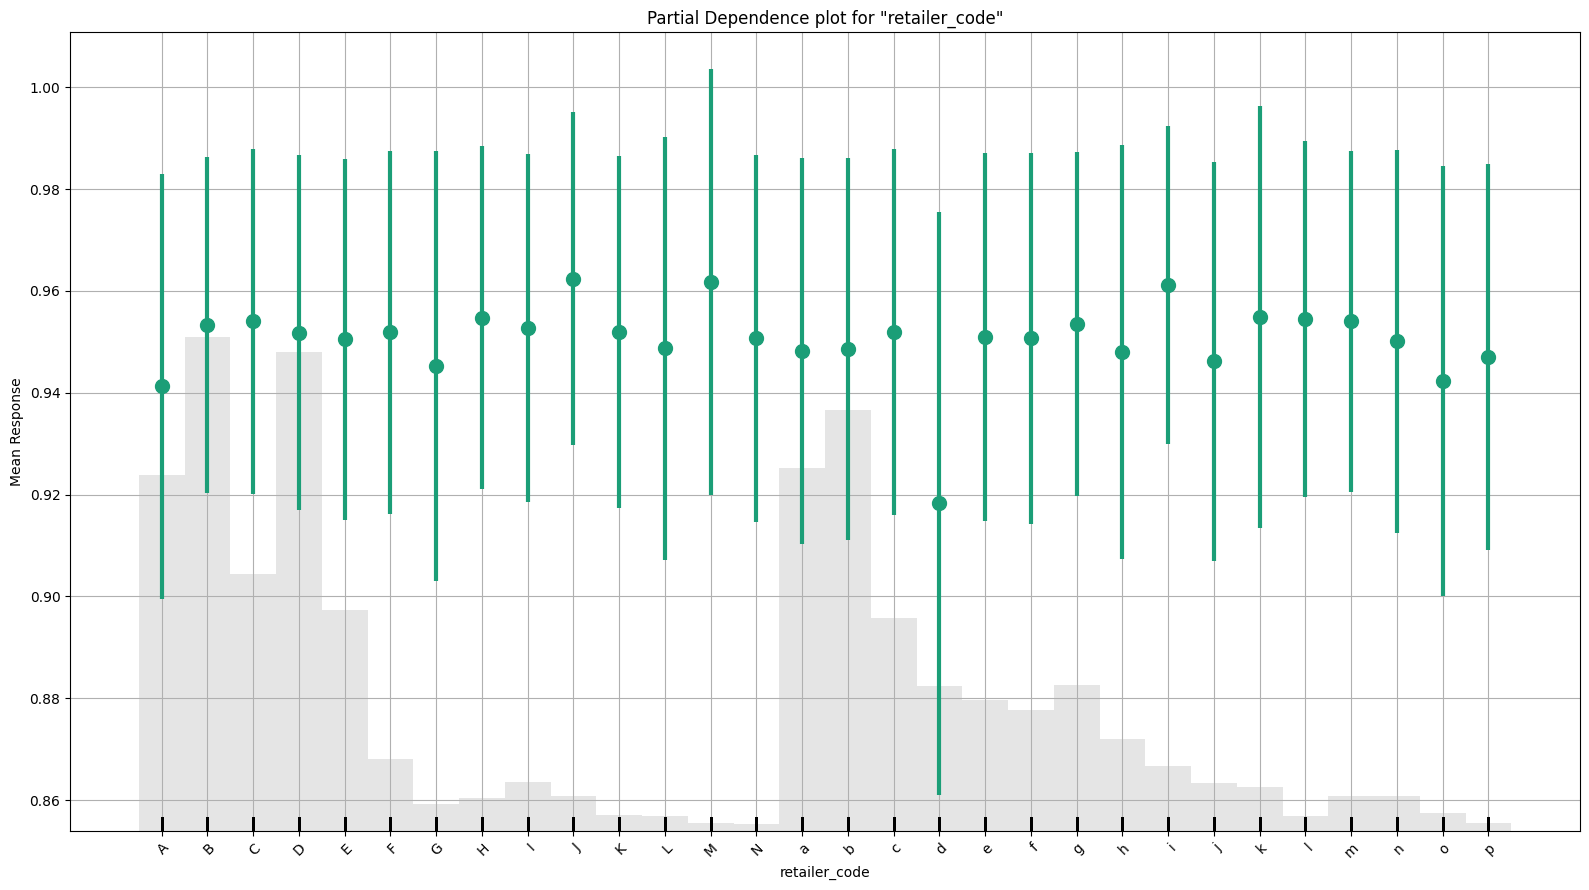



H2OExplanation([('confusion_matrix', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x78ec1087baf0>), ('description', <h2o.explanation._explain.Description object at 0x78ec1184bfa0>), ('subexplanations', H2OExplanation([('XGBoost_model_python_1711238888447_88', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x78ec113b9b10>), ('plots', H2OExplanation([('XGBoost_model_python_1711238888447_88', ConfusionMatrix({'table': H2OTwoDimTable({'_table_header': 'Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6692935988820833', '_col_header': ['', 'floor', 'resolved', 'Error', 'Rate']})}))]))]))]))])), ('learning_curve', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x78ec113bb250>), ('description', <h2o.explanation._explain.Description object at 0x78ec113ba9e0>), ('plots', H2OExplanation([('XGBoost_model_python_1711238888447_88', <h2o.plot._plot_result._MObject object at 0x78ec10d761a0>)]))])), ('varimp', H2OExplanatio

In [ ]:
train_and_evaluate_model(data, 'resolved', predictor, 'PP')

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
Model Details
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_model_python_1711238888447_304


Model Summary: 
    number_of_trees
--  -----------------
    50

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16777818965683064
RMSE: 0.40960736035480444
LogLoss: 0.5016468698208347
Mean Per-Class Error: 0.26789642014163273
AUC: 0.8210436719716819
AUCPR: 0.697549824113918
Gini: 0.6420873439433639

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3386934049751448
          floor    resolved    Error    Rate
--------  -------  ----------  -------  ----------------
floor     5197     2395        0.3155   (2395.0/7592.0)
resolved  763      2700        0.2203   (763.0/3463.0)
Total     5960     5095        0.2857   (3158.0/11055.0)

Maximum Metrics: Maximum metrics at their respec

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## XGBoost_model_python_1711238888447_304

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3386934049751448
          floor    resolved    Error    Rate
--------  -------  ----------  -------  ----------------
floor     5197     2395        0.3155   (2395.0/7592.0)
resolved  763      2700        0.2203   (763.0/3463.0)
Total     5960     5095        0.2857   (3158.0/11055.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

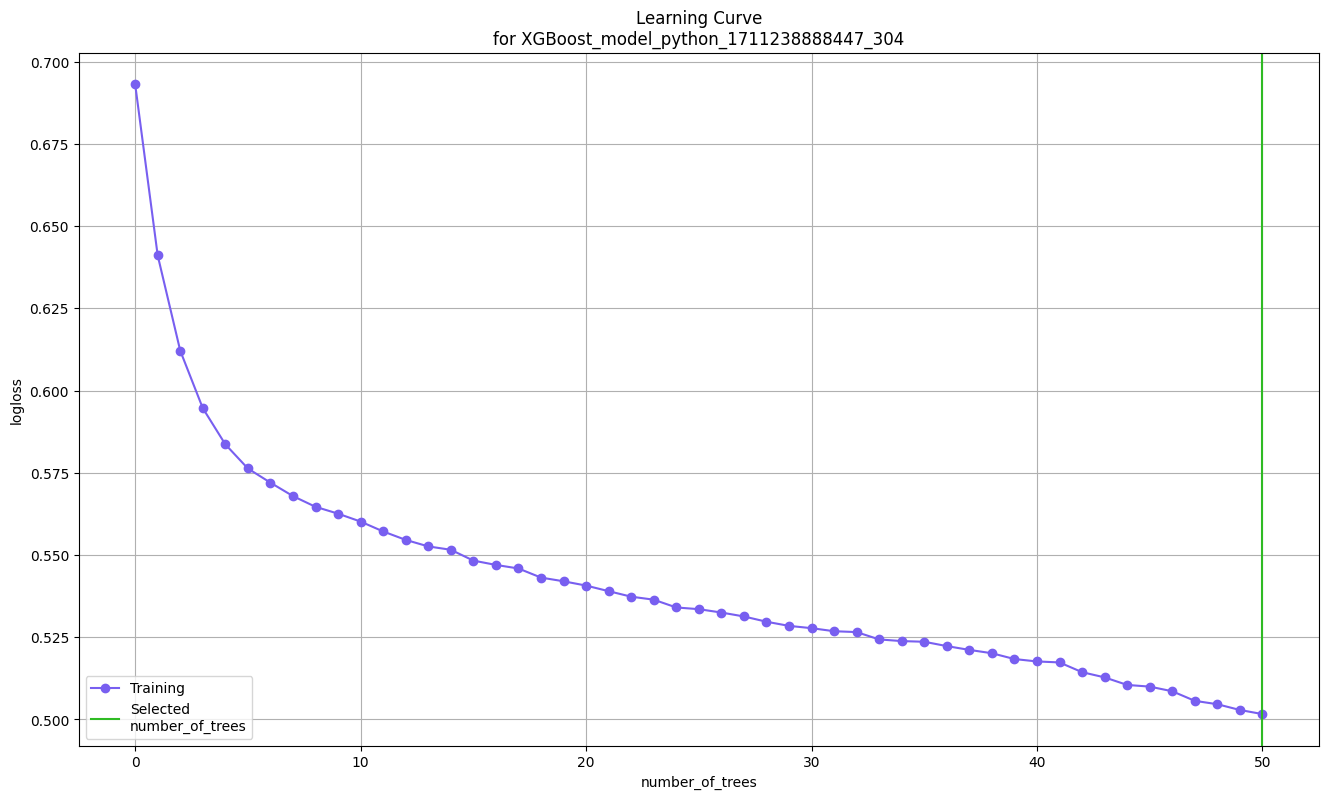

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

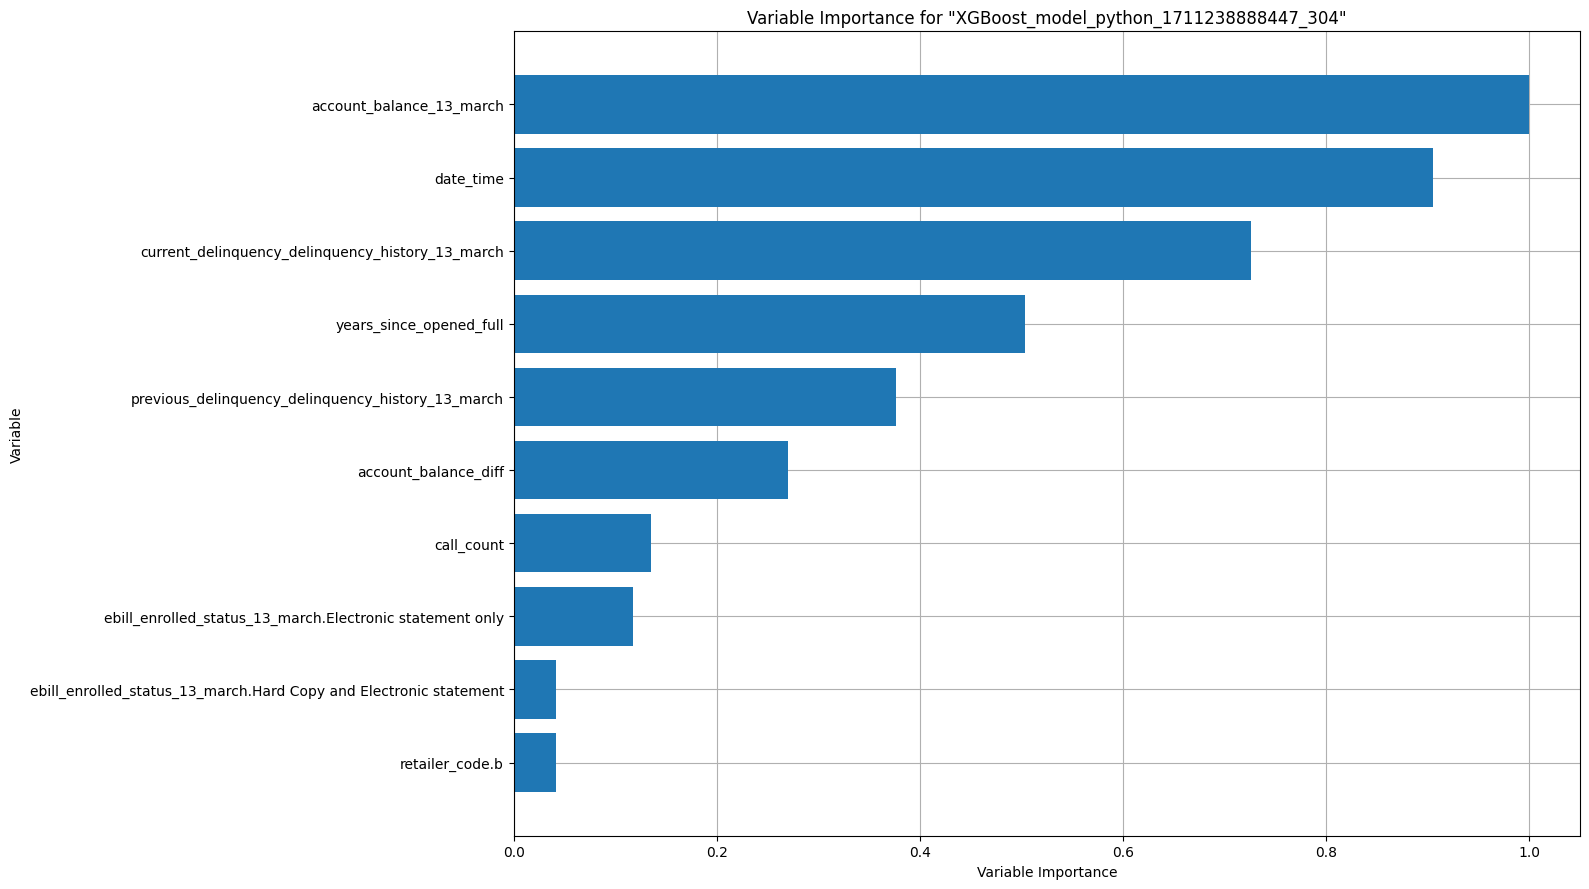

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

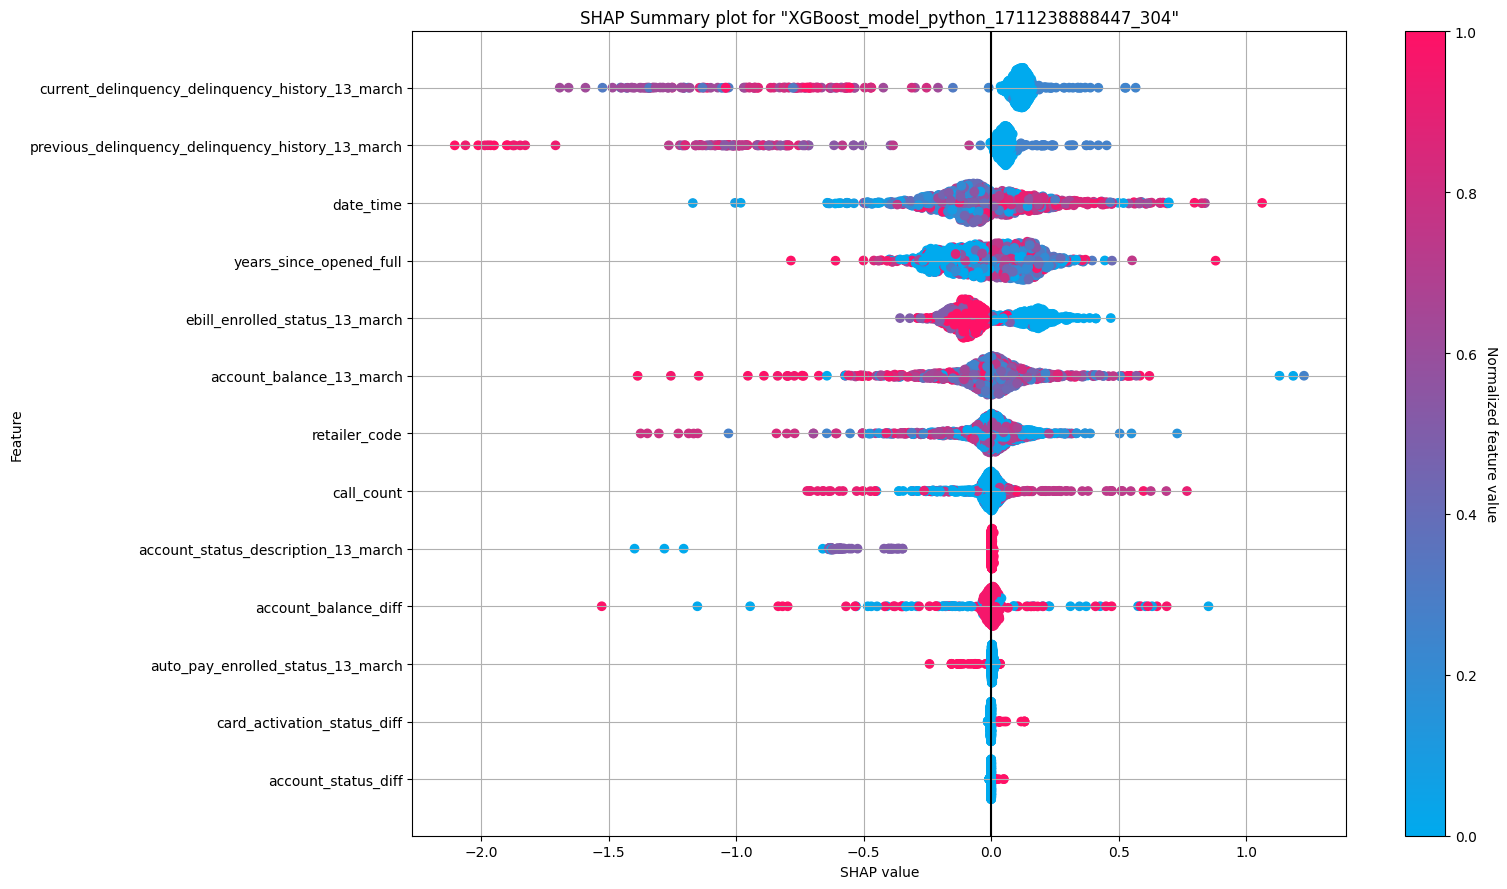

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

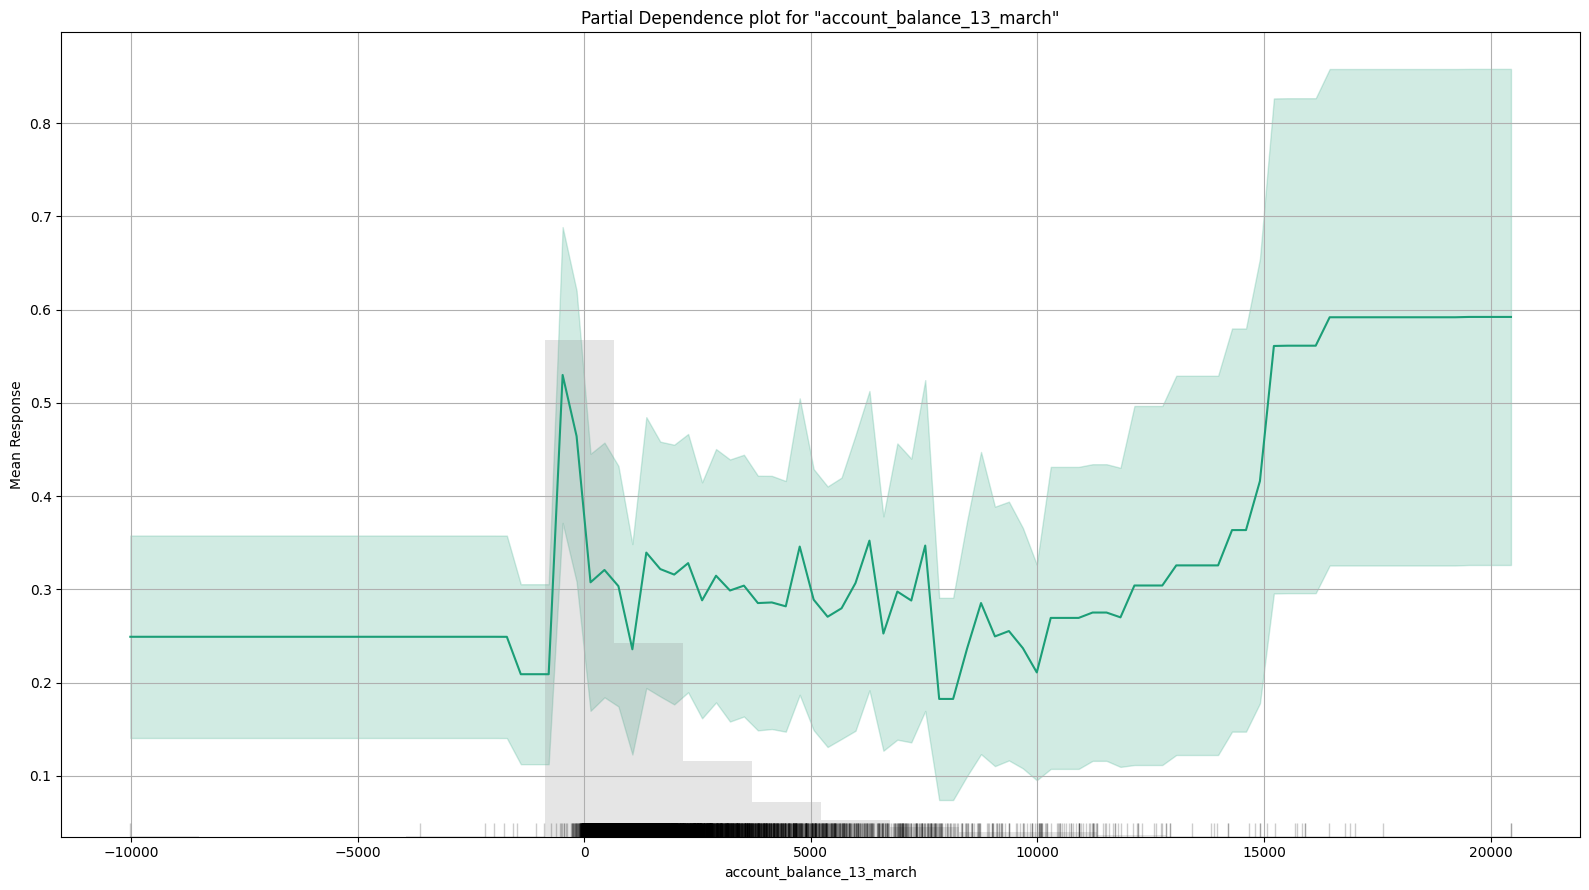

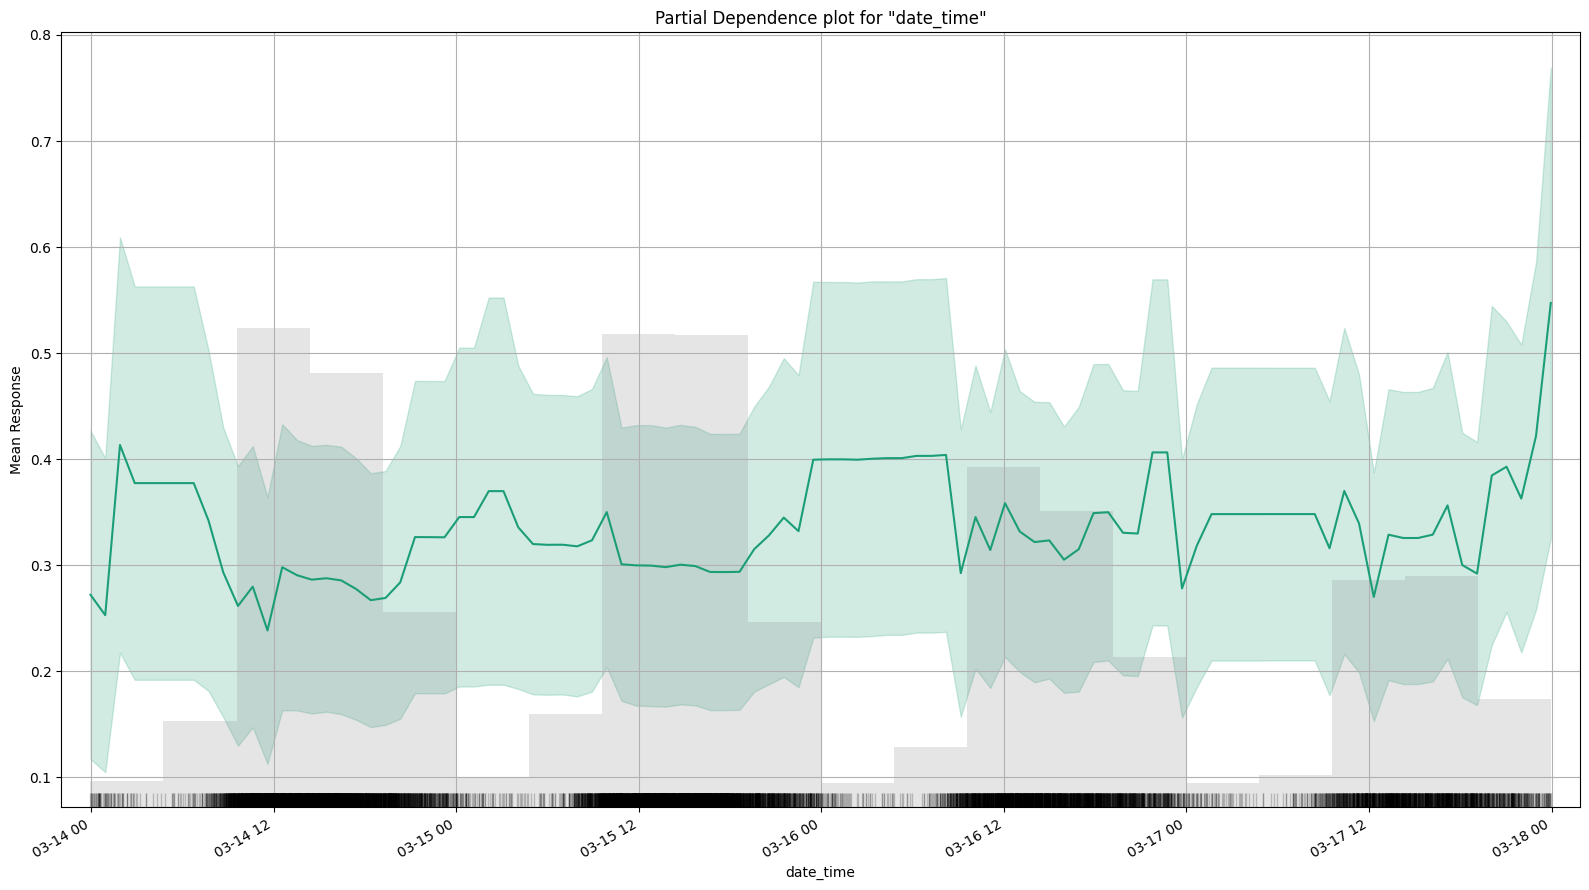

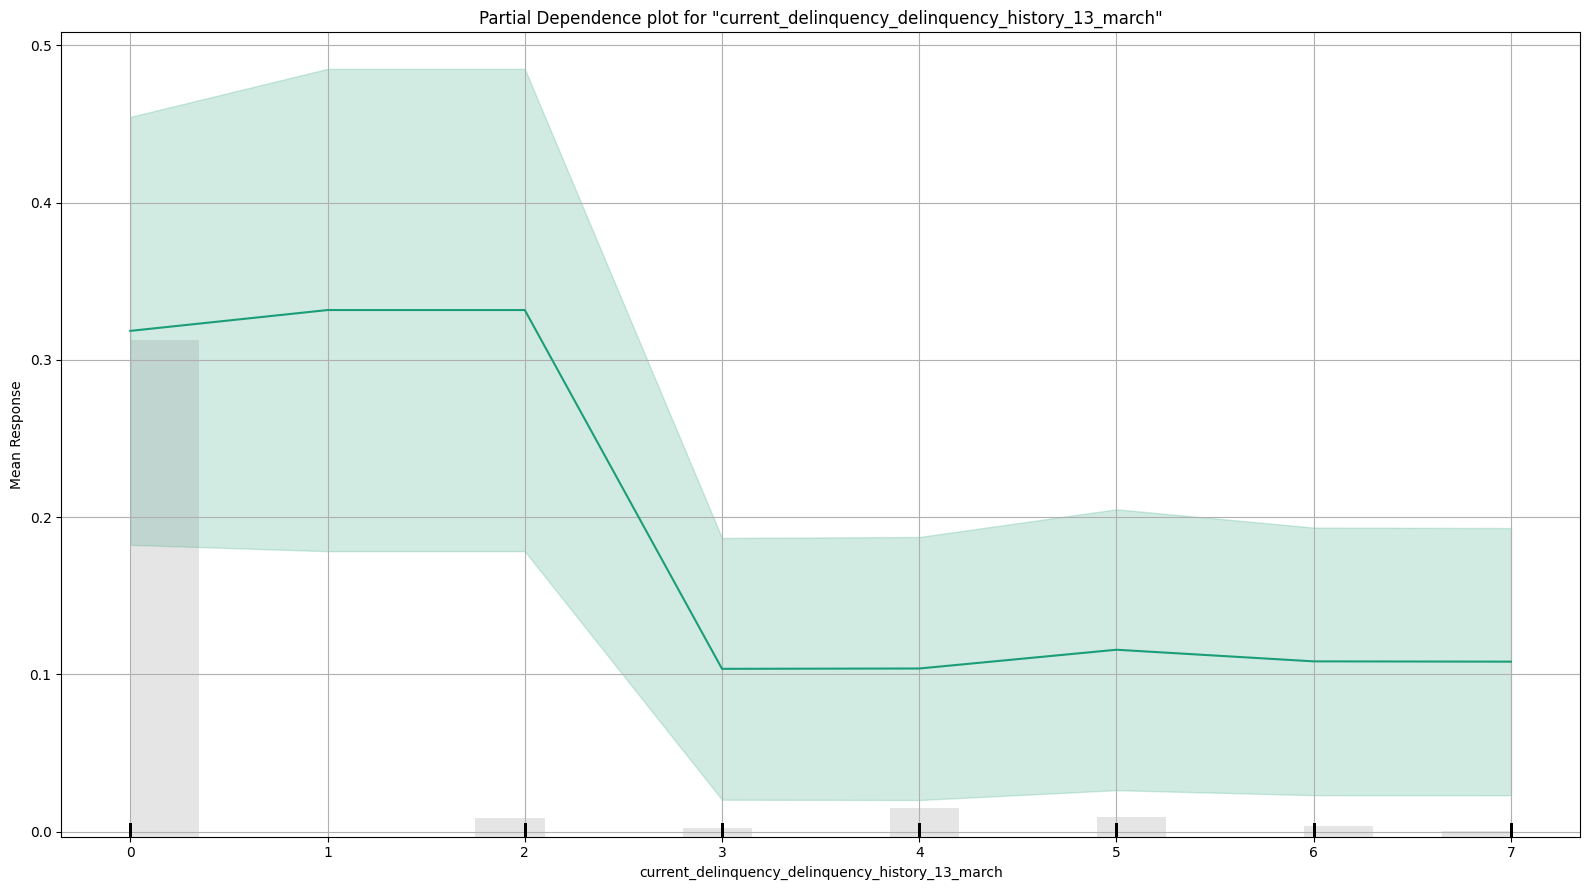

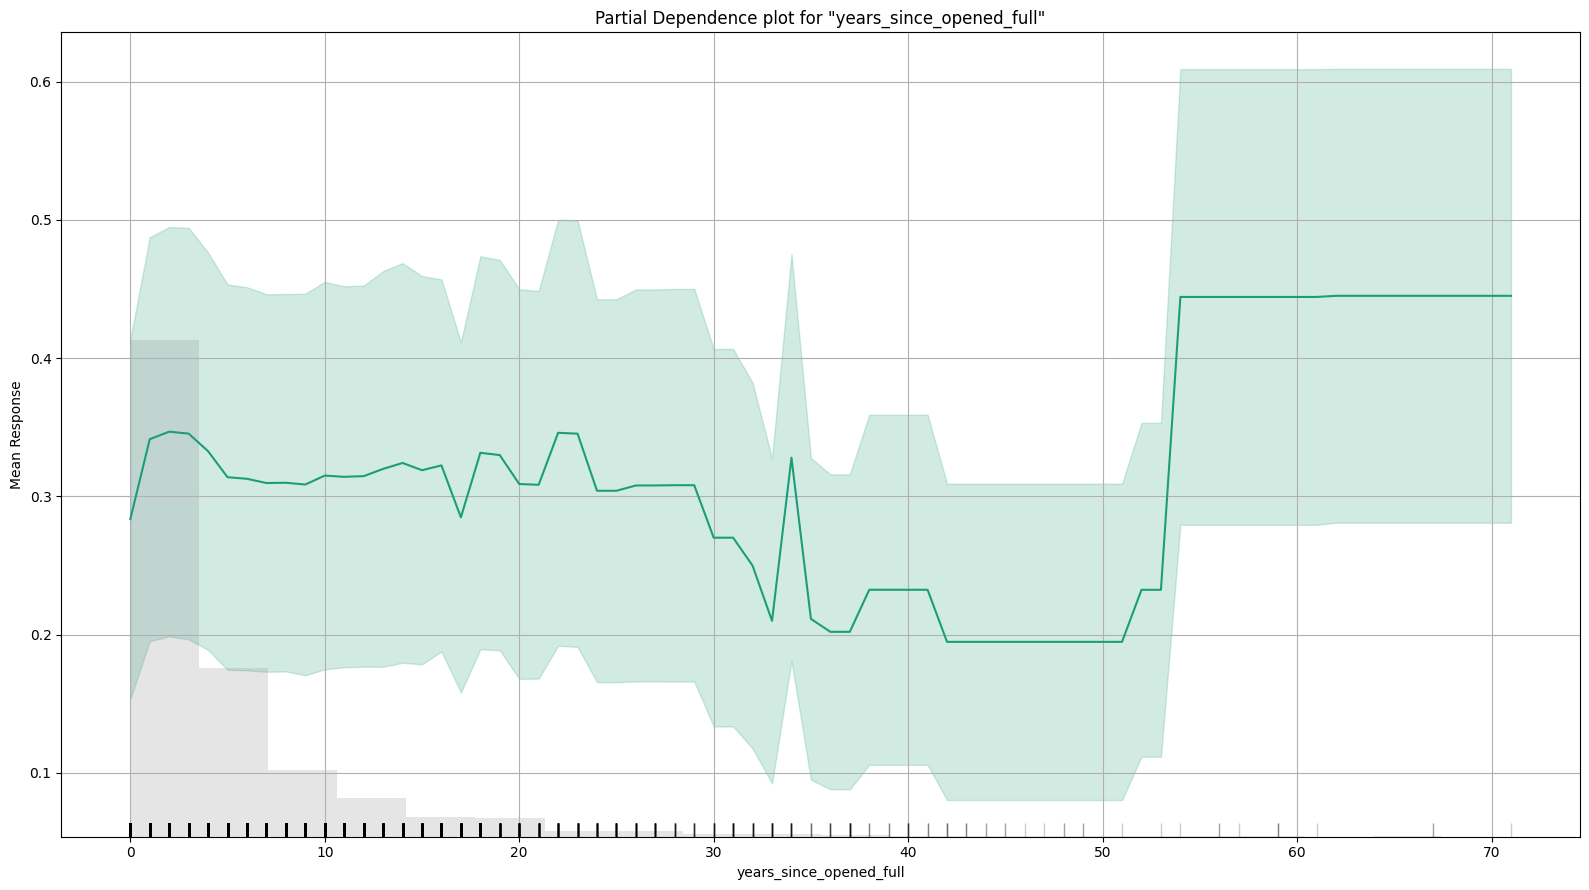

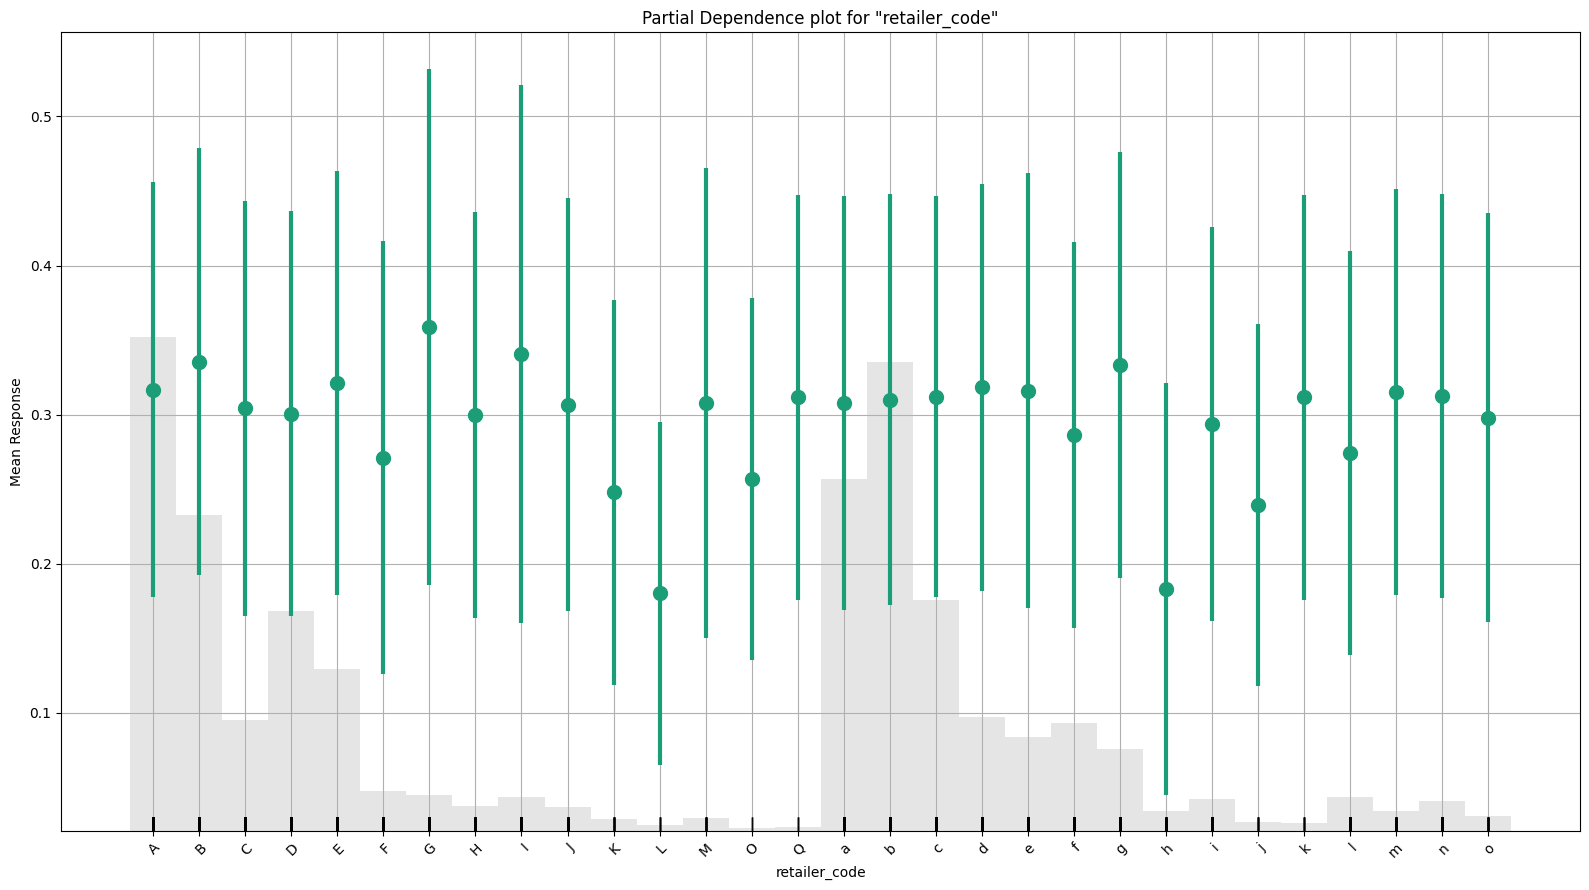



H2OExplanation([('confusion_matrix', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x78ebe93fcaf0>), ('description', <h2o.explanation._explain.Description object at 0x78ec110b0520>), ('subexplanations', H2OExplanation([('XGBoost_model_python_1711238888447_304', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x78ec107b06d0>), ('plots', H2OExplanation([('XGBoost_model_python_1711238888447_304', ConfusionMatrix({'table': H2OTwoDimTable({'_table_header': 'Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3386934049751448', '_col_header': ['', 'floor', 'resolved', 'Error', 'Rate']})}))]))]))]))])), ('learning_curve', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x78ec110b14b0>), ('description', <h2o.explanation._explain.Description object at 0x78ec109ca320>), ('plots', H2OExplanation([('XGBoost_model_python_1711238888447_304', <h2o.plot._plot_result._MObject object at 0x78ec11184130>)]))])), ('varimp', H2OExplana

In [ ]:
train_and_evaluate_model(data, 'resolved', predictor, 'LS')

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
Model Details
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_model_python_1711238888447_1756


Model Summary: 
    number_of_trees
--  -----------------
    50

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.026358688170910926
RMSE: 0.16235358995387483
LogLoss: 0.09965838236398501
Mean Per-Class Error: 0.21646541576191633
AUC: 0.9564350912330262
AUCPR: 0.6625567133401824
Gini: 0.9128701824660523

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17261109252770743
          floor    resolved    Error    Rate
--------  -------  ----------  -------  ---------------
floor     9920     109         0.0109   (109.0/10029.0)
resolved  176      241         0.4221   (176.0/417.0)
Total     10096    350         0.0273   (285.0/10446.0)

Maximum Metrics: Maximum metrics at their resp

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## XGBoost_model_python_1711238888447_1756

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17261109252770743
          floor    resolved    Error    Rate
--------  -------  ----------  -------  ---------------
floor     9920     109         0.0109   (109.0/10029.0)
resolved  176      241         0.4221   (176.0/417.0)
Total     10096    350         0.0273   (285.0/10446.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

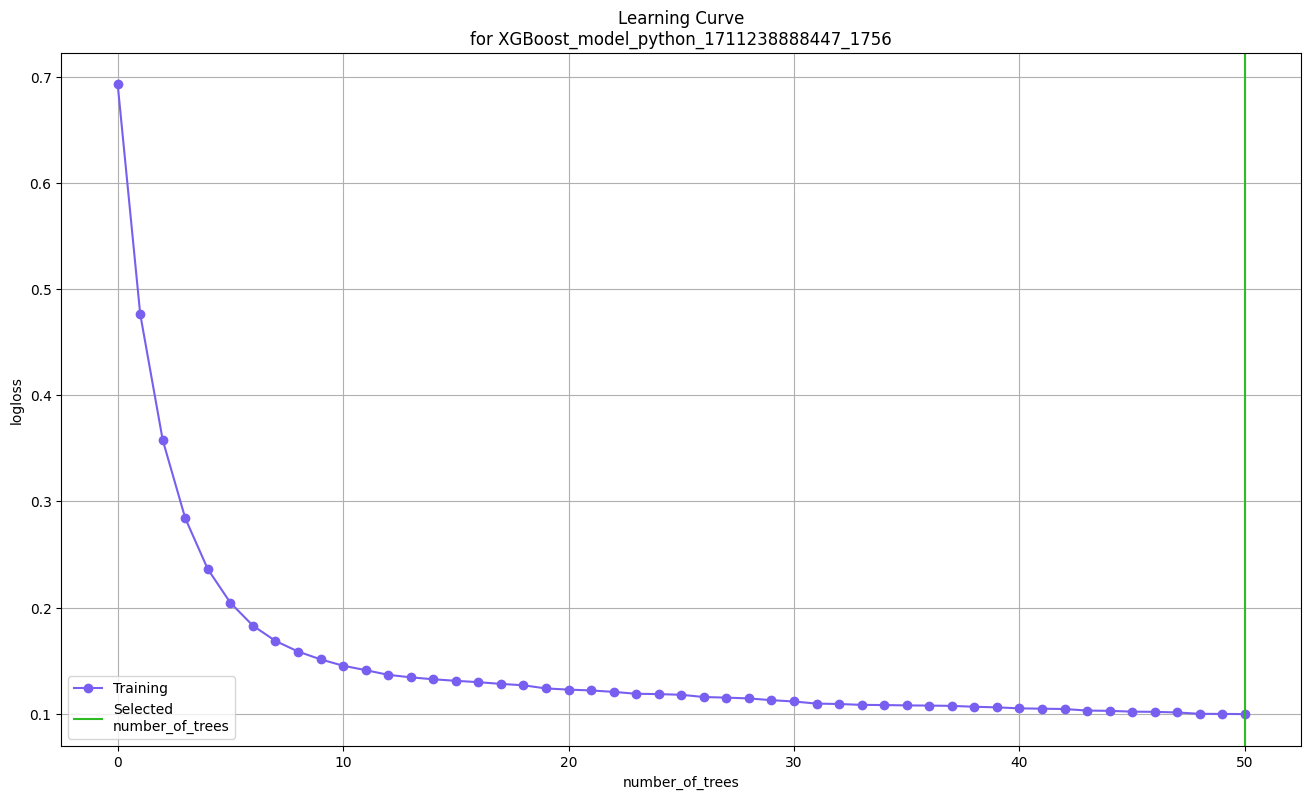

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

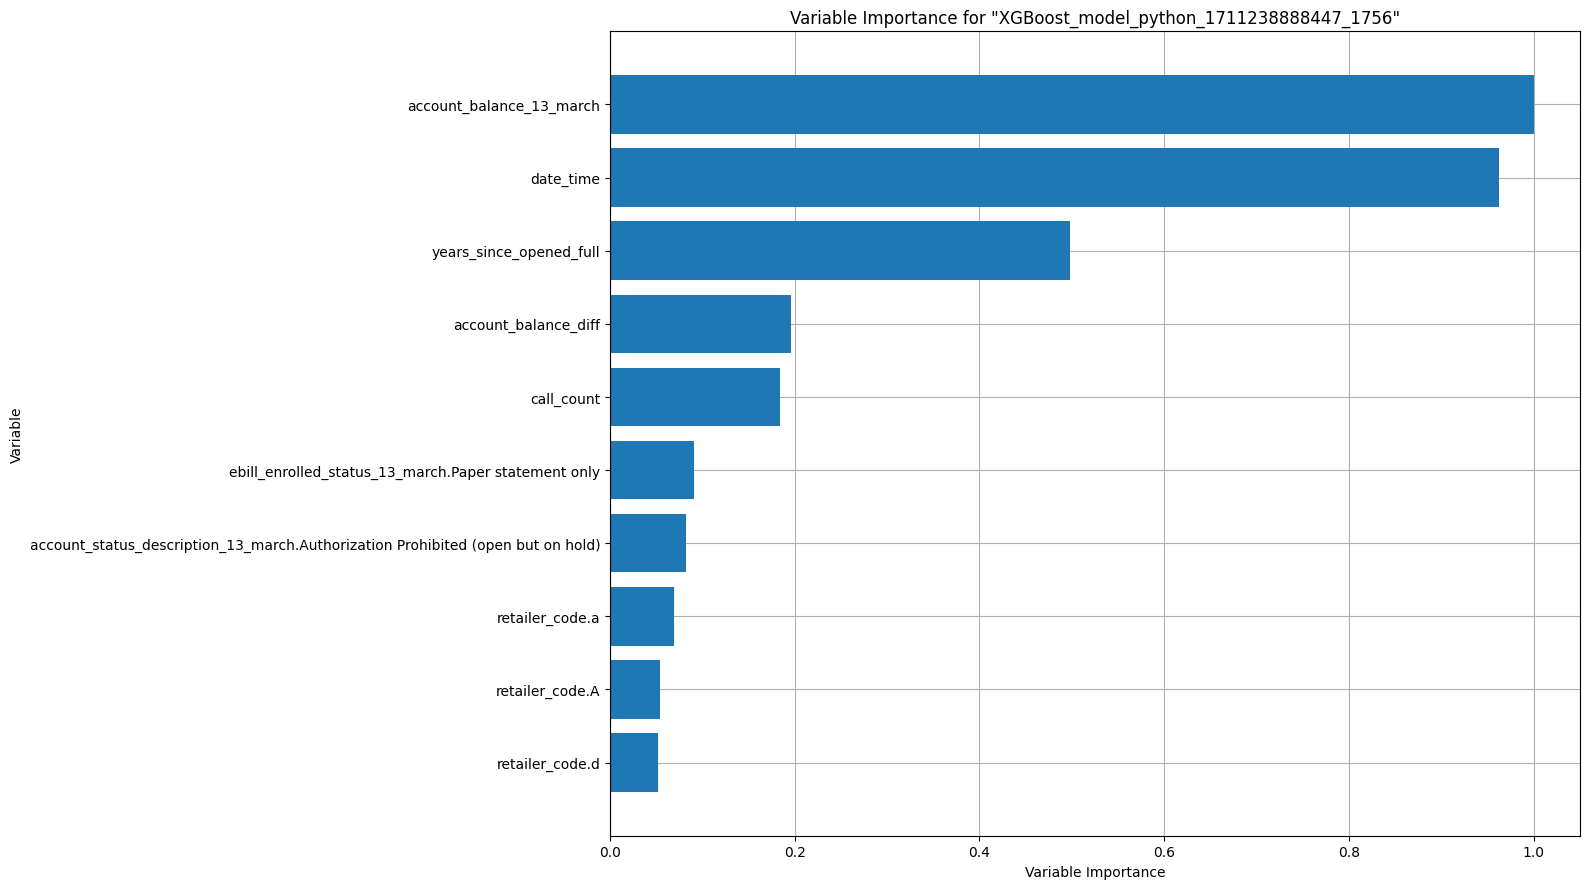

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

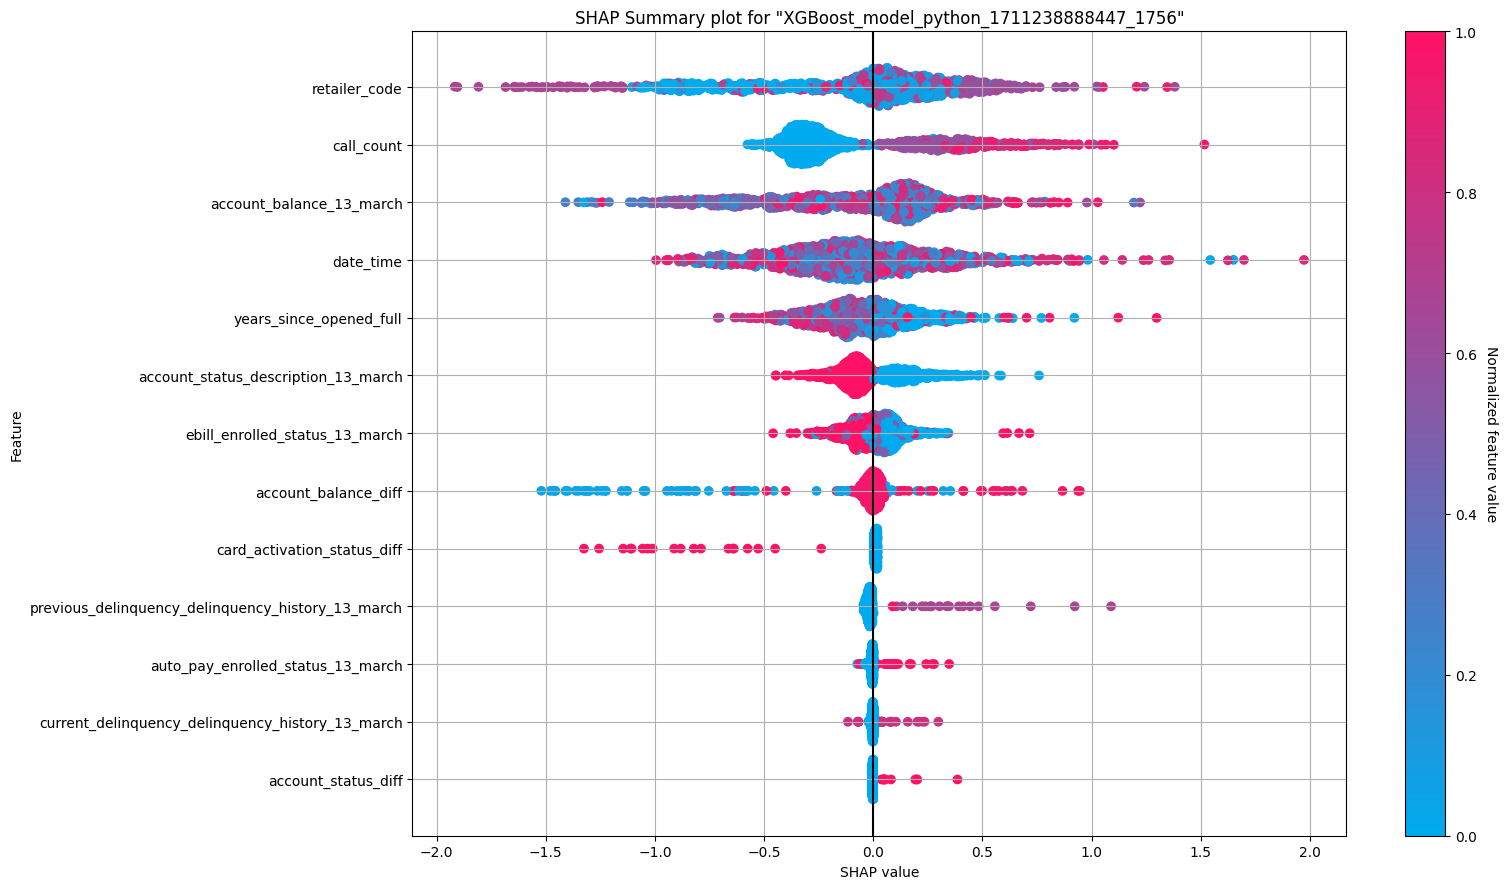

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

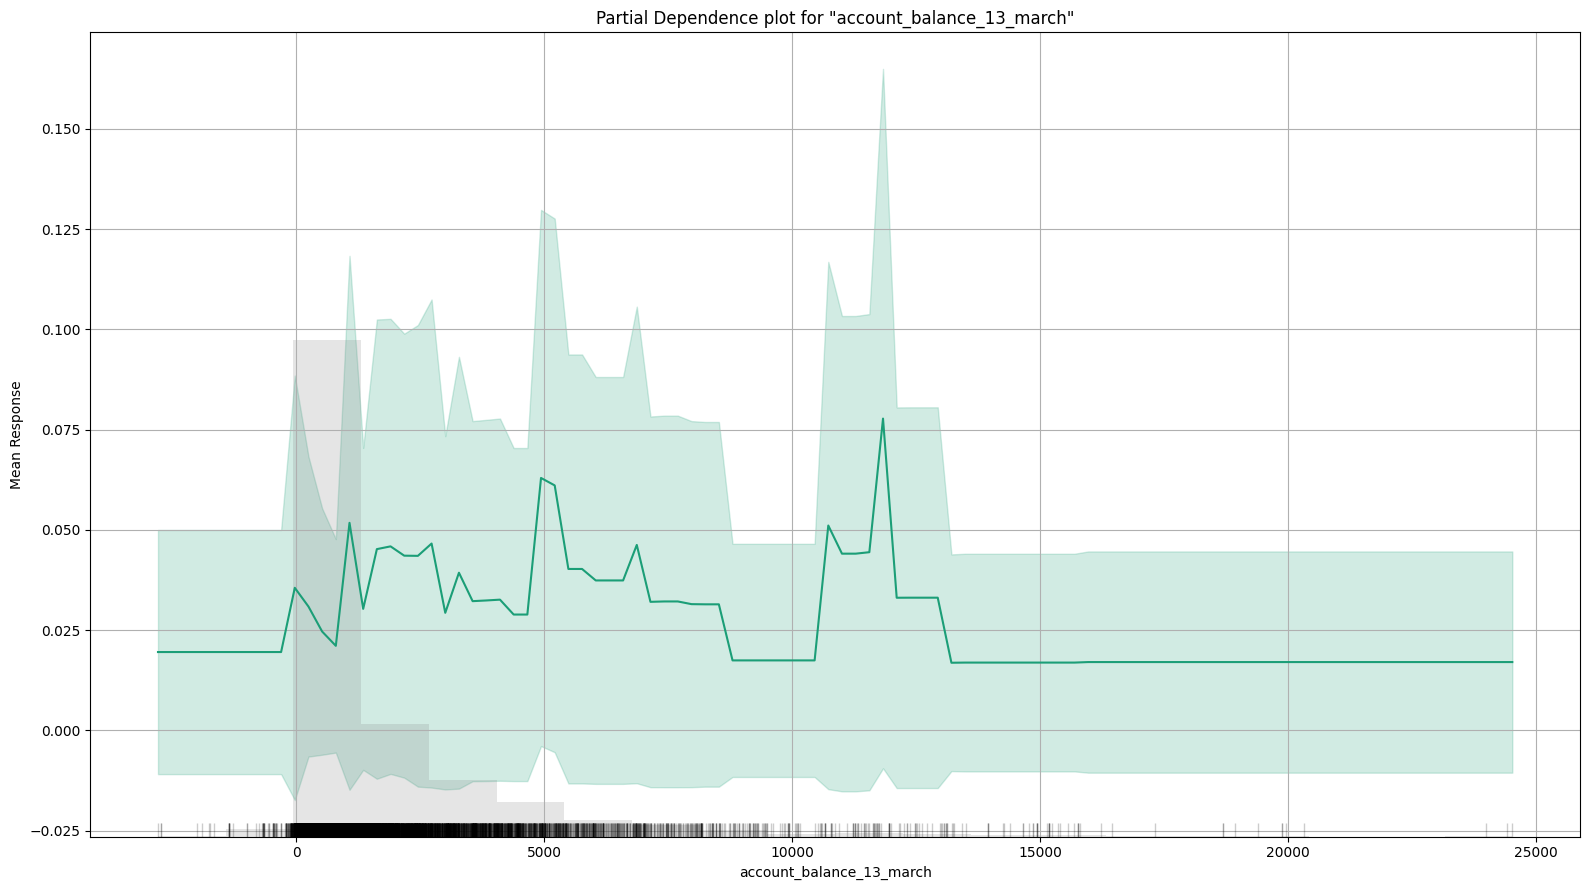

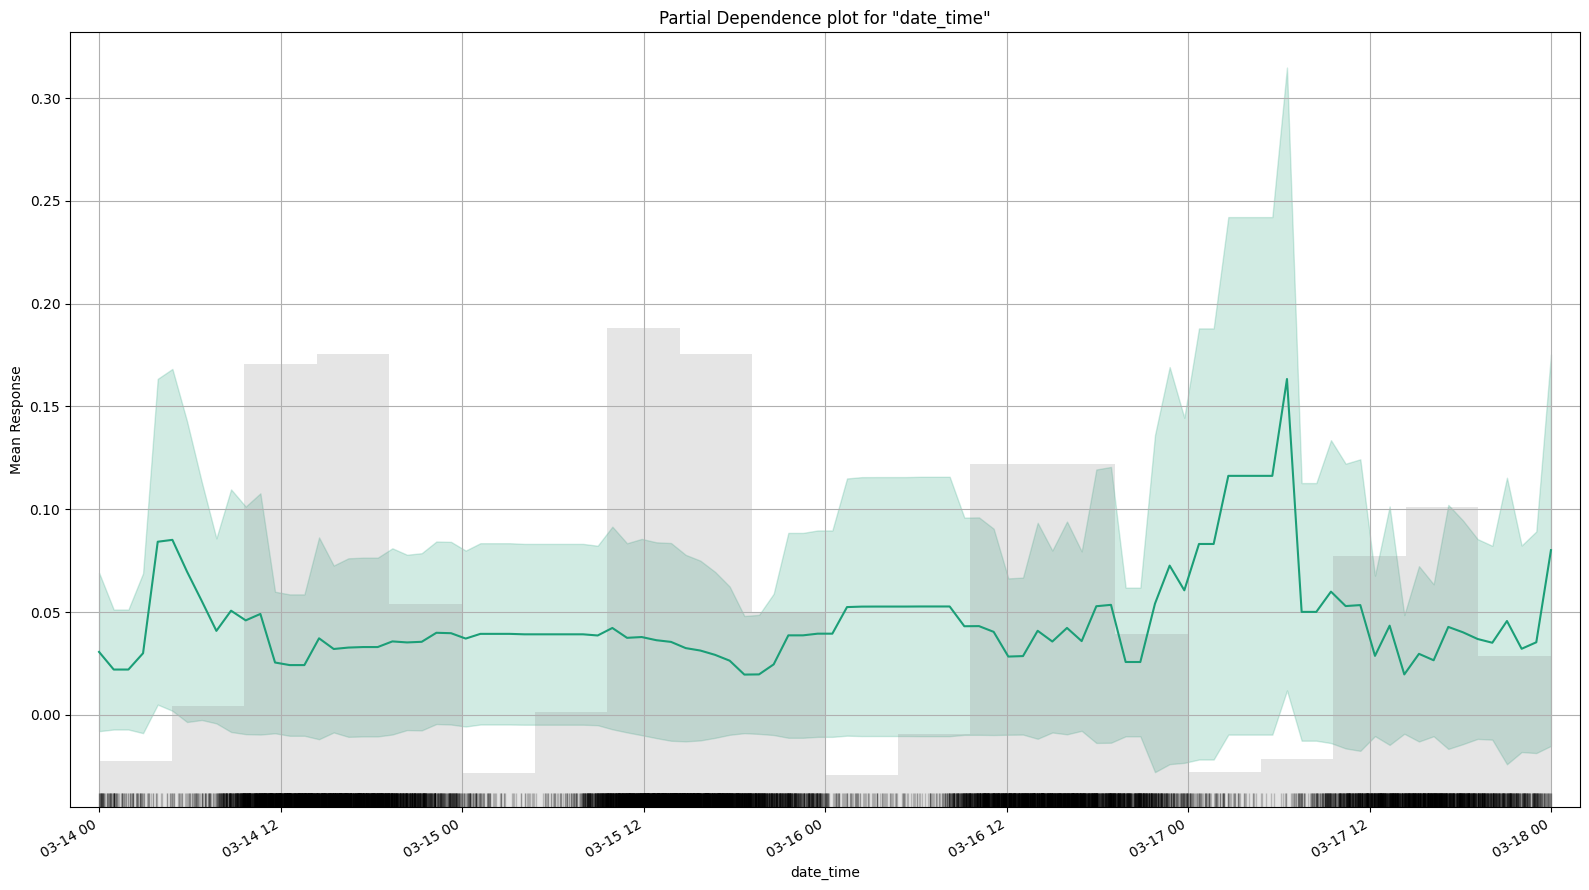

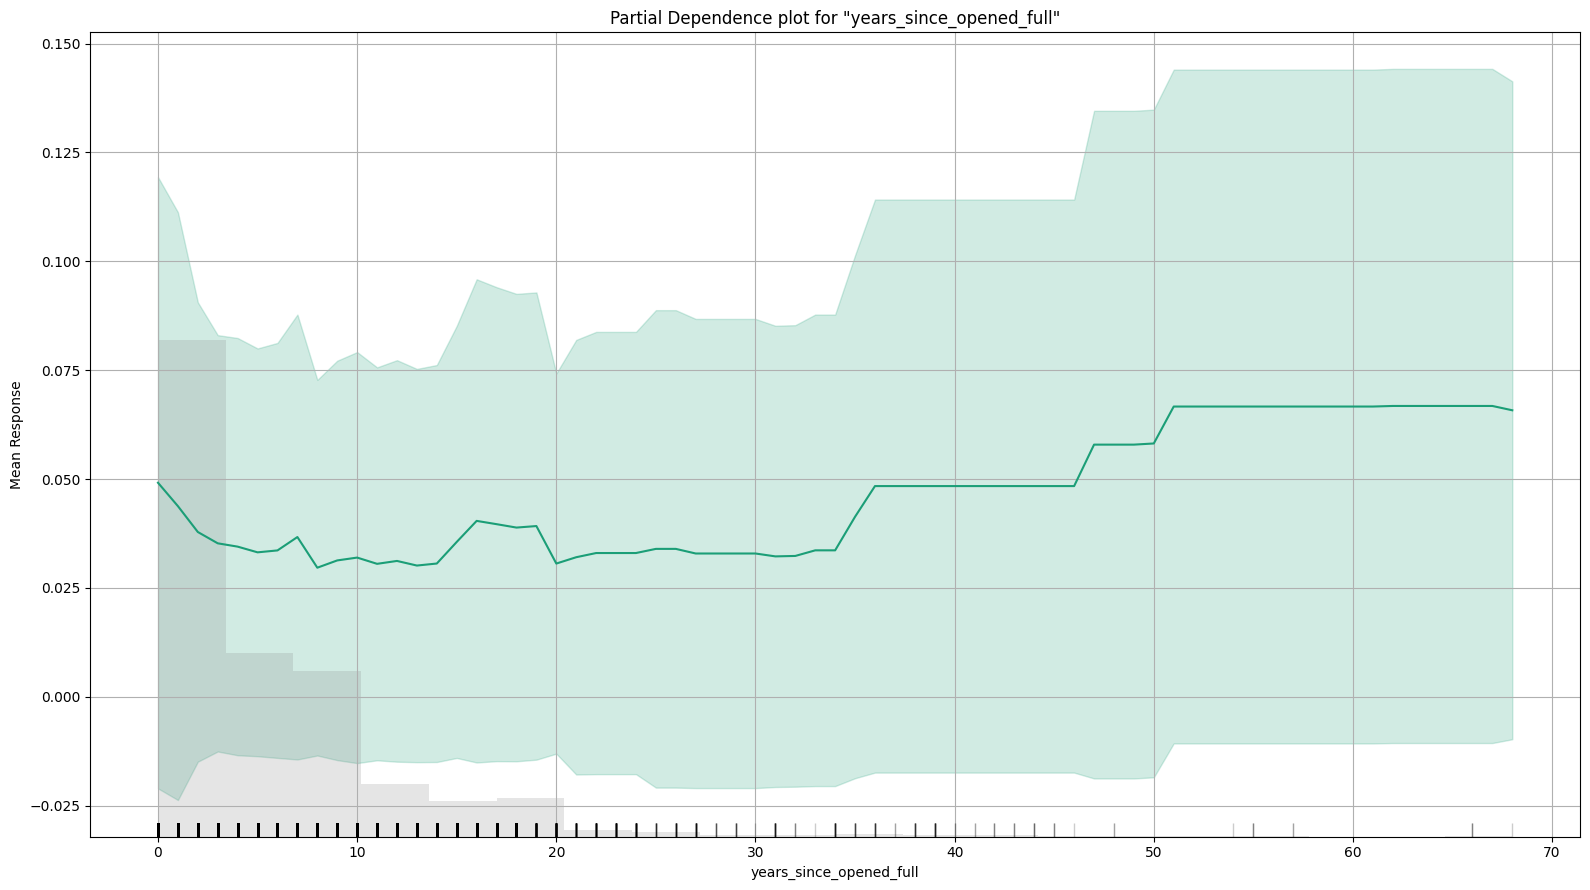

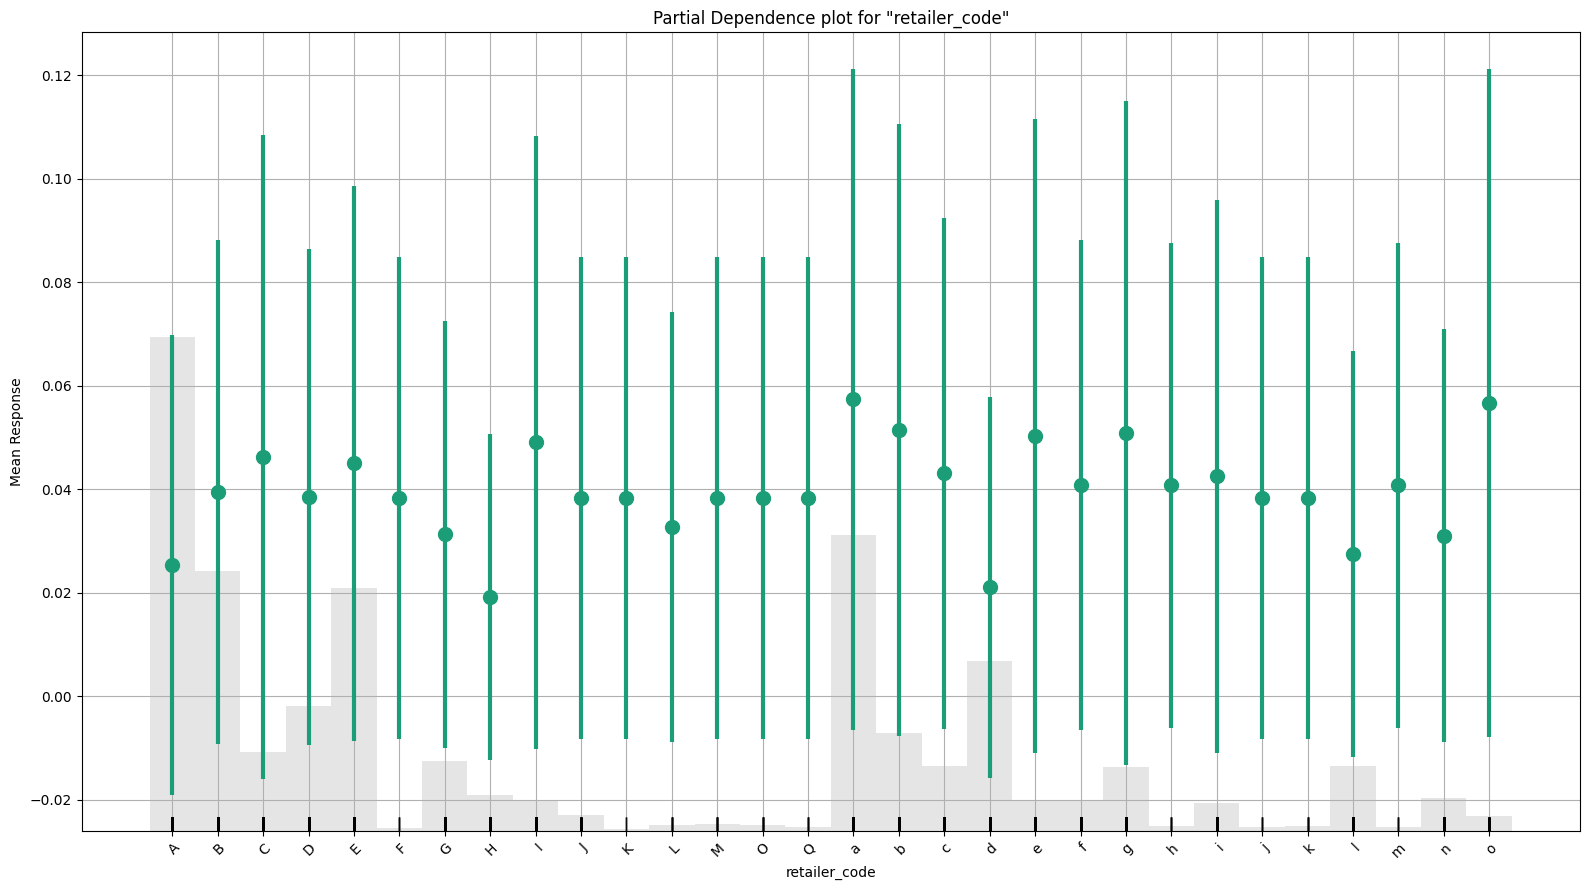

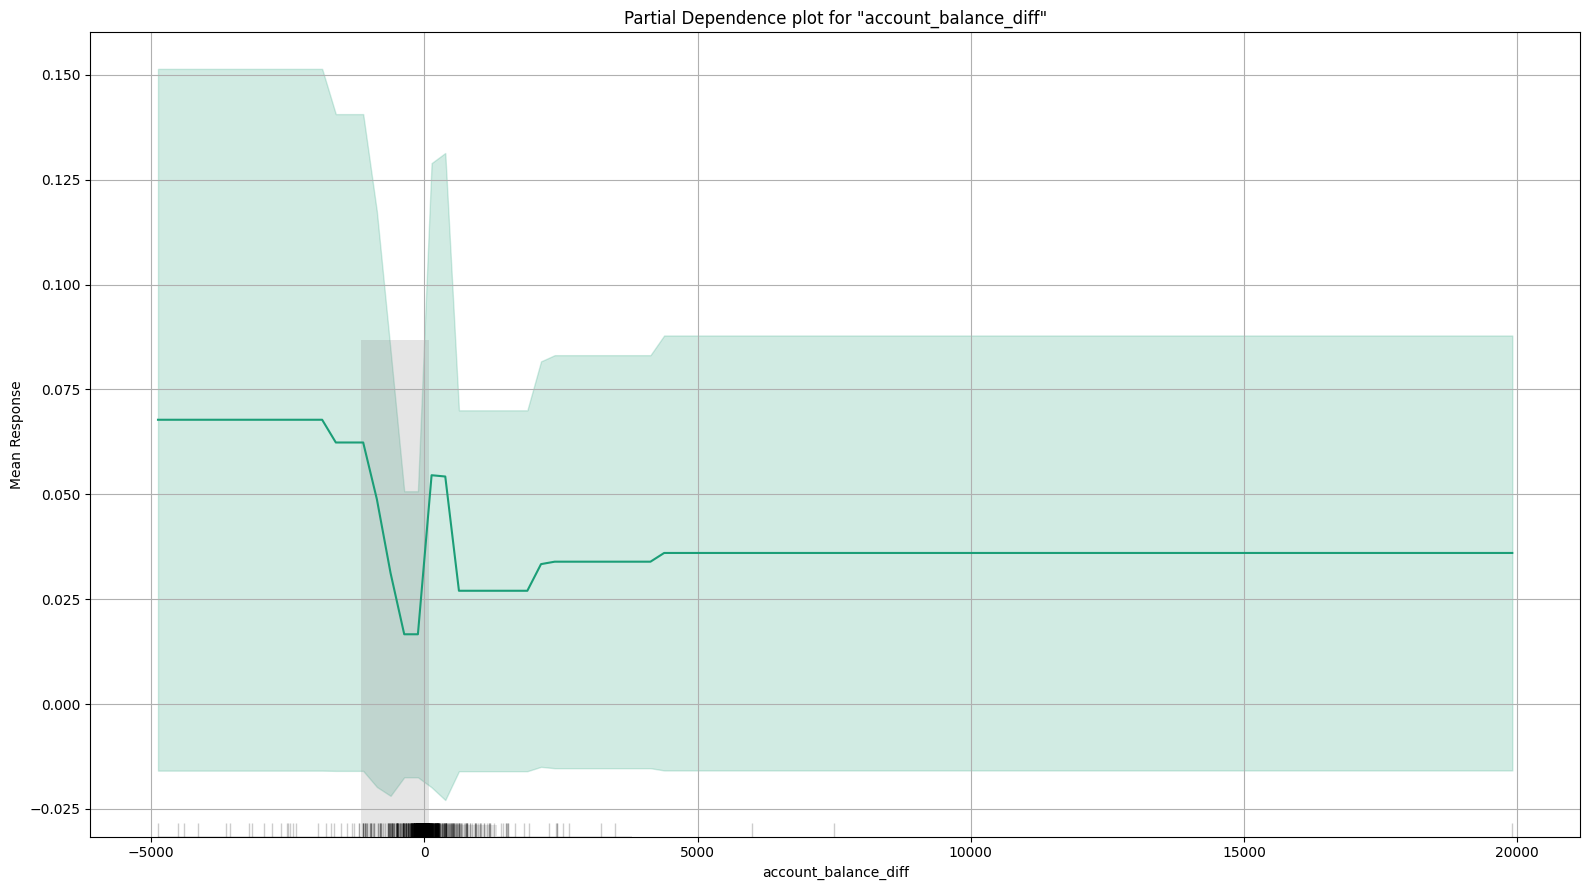



H2OExplanation([('confusion_matrix', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x78ec10854670>), ('description', <h2o.explanation._explain.Description object at 0x78ec10856a70>), ('subexplanations', H2OExplanation([('XGBoost_model_python_1711238888447_1756', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x78ec108562c0>), ('plots', H2OExplanation([('XGBoost_model_python_1711238888447_1756', ConfusionMatrix({'table': H2OTwoDimTable({'_table_header': 'Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17261109252770743', '_col_header': ['', 'floor', 'resolved', 'Error', 'Rate']})}))]))]))]))])), ('learning_curve', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x78ec10855270>), ('description', <h2o.explanation._explain.Description object at 0x78ec10854310>), ('plots', H2OExplanation([('XGBoost_model_python_1711238888447_1756', <h2o.plot._plot_result._MObject object at 0x78ebdfc08b80>)]))])), ('varimp', H2OExp

In [ ]:
train_and_evaluate_model(data, 'resolved', predictor, 'FD')

In [ ]:
from h2o.automl import H2OAutoML

def automl_train_and_evaluate(data, response, predictors, reason_filter, seed=1234, train_ratio=0.8, max_models=10, balance_classes=True):
    """
    Train and evaluate models using H2O's AutoML, with consideration for class imbalance.

    :param data: h2o H2OFrame containing the training data
    :param response: String, the name of the response column
    :param predictors: List of strings, the names of the predictor columns
    :param reason_filter: String, the value of 'reason' column to filter on
    :param seed: Integer, a seed for random operations
    :param train_ratio: Float, the ratio of training set split
    :param max_models: Integer, the maximum number of models to build in the AutoML run
    :param balance_classes: Boolean, whether to balance classes or not
    :return: The best AutoML model and leaderboard
    """
    # Filter data based on reason
    sampled_data = data[data['reason'] == reason_filter]

    # Split the data into train and test sets
    splits = sampled_data.split_frame(ratios=[train_ratio], seed=seed)
    train = splits[0]
    test = splits[1]

    # Convert the response column to a categorical factor
    train[response] = train[response].asfactor()
    test[response] = test[response].asfactor()

    # Set up AutoML
    automl = H2OAutoML(max_models=max_models, seed=seed, balance_classes=balance_classes,
                       class_sampling_factors=None, project_name="AutoML_class_balance")
    automl.train(x=predictors, y=response, training_frame=train)

    # Get the AutoML leaderboard
    lb = automl.leaderboard

    # The best model is the leader in the AutoML leaderboard
    best_model = automl.leader

    # Evaluate the best model's performance on the test set
    performance = best_model.model_performance(test)

    return best_model, performance, lb


In [ ]:
automl_train_and_evaluate(data, 'resolved', predictor, 'AA')

AutoML progress: |
01:08:30.835: _train param, Dropping bad and constant columns: [reason]

██
01:08:43.362: _train param, Dropping bad and constant columns: [reason]

██
01:08:52.873: _train param, Dropping bad and constant columns: [reason]

█
01:09:07.220: _train param, Dropping bad and constant columns: [reason]


01:09:15.950: _train param, Dropping bad and constant columns: [reason]

███
01:09:42.228: _train param, Dropping bad and constant columns: [reason]


01:09:50.683: _train param, Dropping bad and constant columns: [reason]

█
01:09:59.42: _train param, Dropping bad and constant columns: [reason]

██
01:10:08.948: _train param, Dropping bad and constant columns: [reason]

█
01:10:16.647: _train param, Dropping bad and constant columns: [reason]

██
01:10:34.983: _train param, Dropping unused columns: [reason]

███
01:10:45.530: _train param, Dropping unused columns: [reason]

██████████████████████████████████████████████| (done) 100%


(Model Details
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_1_20240324_10830


Model Summary for Stacked Ensemble: 
key                                   value
------------------------------------  ----------------
Stacking strategy                     cross_validation
Number of base models (used / total)  9/10
# GBM base models (used / total)      4/4
# XGBoost base models (used / total)  3/3
# GLM base models (used / total)      1/1
# DRF base models (used / total)      1/2
Metalearner algorithm                 GLM
Metalearner fold assignment scheme    Random
Metalearner nfolds                    5
Metalearner fold_column
Custom metalearner hyperparameters    None

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.16864285761810735
RMSE: 0.41066148786818
LogLoss: 0.5137265817680279
AUC: 0.7484814795339648
AUCPR: 0.8730649472215368
Gini: 0.49696295906792964
Null degrees of freedom: 9954
Residual degrees of fr

## Predict reason base on attribute

### Data cleaning

In [ ]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         2 hours 4 mins
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.1
H2O_cluster_version_age:    10 days
H2O_cluster_name:           H2O_from_python_unknownUser_jc64xu
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    11.14 Gb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.10.12 final
--------------------------  -----------------------------------------------------------------------------------------

In [9]:
response="reason"
predictor1=['retailer_code','account_balance_13_march','account_status_description_13_march',
           'ebill_enrolled_status_13_march','auto_pay_enrolled_status_13_march',
           'current_delinquency_delinquency_history_13_march','previous_delinquency_delinquency_history_13_march','date_time',
           'call_count','years_since_opened_full','account_status_diff','card_activation_status_diff',
           'account_balance_diff']

def train_and_evaluate_model2(data, response, predictors, seed=1234, train_ratio=0.8):
    """
    Train and evaluate an XGBoost model using h2o.

    :param data: h2o H2OFrame containing the training data
    :param response: String, the name of the response column
    :param predictors: List of strings, the names of the predictor columns

    :param seed: Integer, a seed for random operations
    :param train_ratio: Float, the ratio of training set split
    :return: The trained model and performance metrics
    """


    # Split the data into train and test sets
    splits = data.split_frame(ratios=[train_ratio], seed=seed)
    train = splits[0]
    test = splits[1]

    # Convert the response column to a categorical factor
    train[response] = train[response].asfactor()
    test[response] = test[response].asfactor()


    # Initialize and train the XGBoost model
    xgboost_model = H2OXGBoostEstimator()
    xgboost_model.train(x=predictors, y=response, training_frame=train)
    print(xgboost_model)
    # Evaluate the model's performance on the test set
    performance = xgboost_model.model_performance(test)
    print(performance)
    # Explain the model on the train set
    explanation = xgboost_model.explain(train)
    print(explanation)
    return



In [10]:
# Calculate value counts for each reason
value_counts = data['reason'].table().as_data_frame()  # Get counts as a Pandas DataFrame
value_counts.columns = ['reason', 'count']  # Rename columns

# Calculate the proportion of 'resolved'
resolved_proportion = data.group_by('reason').mean('resolved')  # Use H2OFrame's group_by and mean
resolved_proportion = resolved_proportion.get_frame().as_data_frame()  # Convert to Pandas DataFrame
resolved_proportion.columns = ['reason', 'resolved_proportion']  # Rename columns

# Merge the counts and proportions on 'reason'
result = value_counts.merge(resolved_proportion, on='reason')

# Sort the results by 'count' in descending order
result = result.sort_values(by='count', ascending=False)

# Get the top 10 reasons with their count and percentage
top_10_reasons = result.head(10)
total_calls = result['count'].sum()
top_10_percent = (top_10_reasons['count'] / total_calls) * 100
top_10_reasons['Percentage'] = top_10_percent

# Select the corresponding rows from the H2OFrame
selected_data = data[data['reason'].isin(top_10_reasons['reason'].tolist())]


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O f

In [15]:
top_10_reasons

reason   count  resolved_proportion  Percentage
33     PP  678314             0.950521   37.709293
4      BA  566351             0.720325   31.484969
35     PT  221583             0.917372   12.318393
2      AT   91404             0.904960    5.081393
0      AA   54861             0.724959    3.049870
10     CT   23796             0.030005    1.322883
72     wa   14296             0.073307    0.794753
24     LS   13765             0.311151    0.765233
15     FD   13007             0.040978    0.723094
23     LC   10076             0.247519    0.560152

In [20]:
selected_data.as_data_frame()['reason'].value_counts()

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


PT    221583
AT     91404
AA     54861
CT     23796
wa     14296
LS     13765
FD     13007
LC     10076
Name: reason, dtype: int64

In [14]:
selected_data

# Split the data into train and test sets
splits = selected_data.split_frame(ratios=[0.8], seed=3047)
train = splits[0]
test = splits[1]

# Convert the response column to a categorical factor
train[response] = train[response].asfactor()
test[response] = test[response].asfactor()


# Initialize and train the XGBoost model
xgboost_model = H2OXGBoostEstimator()
xgboost_model.train(x=predictor1, y=response, training_frame=train)
print(xgboost_model)

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
Model Details
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_model_python_1711298706046_1


Model Summary: 
    number_of_trees
--  -----------------
    50

ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.41522103604328703
RMSE: 0.6443764707399604
LogLoss: 1.2263299872106503
Mean Per-Class Error: 0.1038063220927903
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
AA       AP    AT       AU    BA        BL    CA    CB    CD    CS    CT      DE    DP    DR    ER    FD      FI    FM    FR    GA    HI    IA    IC    LC

In [25]:
train[predictor1]

retailer_code      account_balance_13_march  account_status_description_13_march    ebill_enrolled_status_13_march        auto_pay_enrolled_status_13_march    current_delinquency_delinquency_history_13_march    previous_delinquency_delinquency_history_13_march  date_time              call_count    years_since_opened_full  account_status_diff    card_activation_status_diff      account_balance_diff
---------------  --------------------------  -------------------------------------  ----------------------------------  -----------------------------------  --------------------------------------------------  ---------------------------------------------------  -------------------  ------------  -------------------------  ---------------------  -----------------------------  ----------------------
J                                      0     Open no restrictions                   Paper statement only                                                  0                                                   0                                                    0  2024-03-17 11:42:37             1                          6  False                  False                                               0
B                                    697.75  Open no restrictions                   Paper statement only                                                  0                                                   0                                                    0  2024-03-15 13:43:04             1                          7  False                  True                                                0
D                                    594.62  Open no restrictions                   Electronic statement only                                             0                                                   0                                                    0  2024-03-17 16:44:19             1                          4  False                  False                                               0
A                                    831.61  Open no restrictions                   Hard Copy and Electronic statement                                    0                                                   0                                                    0  2024-03-15 17:33:09             1                          2  False                  False                                               0
I                                      0     Open no restrictions                   Paper statement only                                                  0                                                   0                                                    0  2024-03-15 13:46:22             3                          0  False                  False                                               0
C                                   1818.16  Open no restrictions                   Hard Copy and Electronic statement                                    0                                                   0                                                    0  2024-03-17 15:29:42             1                          3  False                  False                                               0
A                                   4724.73  Open no restrictions                   Hard Copy and Electronic statement                                    0                                                   0                                                    0  2024-03-15 16:33:21             1                          4  False                  False                                               0
E                                   1216.31  Open no restrictions                   Hard Copy and Electronic statement                                    0                                                   0                                                    0  2024-03-16 18:44:16             1                          0  False                  False                                       

In [31]:
h2o.shutdown()

H2O session _sid_b10d closed.


<ipython-input-31-1edf85295eae>:1: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()


In [33]:
data = pd.read_csv("/content/drive/MyDrive/cleaned_data.csv")
df= data.copy()
# Calculate value counts for each reason
value_counts = df['reason'].value_counts().reset_index()
value_counts.columns = ['reason', 'count']

# Calculate the proportion of 'resolved'
resolved_proportion = df.groupby('reason')['resolved'].apply(lambda x: (x == 'resolved').mean()).reset_index(name='resolved_proportion')

# Merge the counts and proportions on 'reason'
result = pd.merge(value_counts, resolved_proportion, on='reason')

# Sort the results by 'count' in descending order
result = result.sort_values(by='count', ascending=False)

# 获取前10个原因及其计数和百分比
top_10_reasons = result.head(10)
total_calls = result['count'].sum()
top_10_percent = (top_10_reasons['count'] / total_calls) * 100
top_10_reasons['Percentage'] = top_10_percent

# 选择与前10个原因对应的行
selected_data = data[data['reason'].isin(top_10_reasons['reason'].tolist())]

# 获取排名第3到第10的原因
reasons_3_to_10 = result.iloc[2:5]

# 最后，选择与排名第3到第10的原因对应的行
selected_data_final = data[data['reason'].isin(reasons_3_to_10['reason'].tolist())]

# 现在，将最终的Pandas DataFrame转换为H2OFrame，然后继续分割数据集
import h2o
from h2o.estimators import H2OXGBoostEstimator
h2o.init()

selected_data_h2o = h2o.H2OFrame(selected_data_final)

# 分割数据为训练集和测试集
splits = selected_data_h2o.split_frame(ratios=[0.8], seed=3047)
train = splits[0]
test = splits[1]

# 将响应列转换为分类因子
train[response] = train[response].asfactor()
test[response] = test[response].asfactor()

# 初始化并训练XGBoost模型
xgboost_model = H2OXGBoostEstimator()
xgboost_model.train(x=predictor1, y=response, training_frame=train)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         4 mins 53 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.1
H2O_cluster_version_age:    11 days
H2O_cluster_name:           H2O_from_python_unknownUser_6zayi1
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    12.66 Gb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.10.12 final
--------------------------  -----------------------------------------------------------------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_model_python_1711302068486_2


Model Summary: 
    number_of_trees
--  -----------------
    50

ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.19366152245219137
RMSE: 0.4400699063242014
LogLoss: 0.5862730291688826
Mean Per-Class Error: 0.3293547416475512
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
AA     AT     PT      Error     Rate
-----  -----  ------  --------  ----------------
25545  1720   16674   0.418626  18,394 / 43,939
3272   39668  30322   0.458546  33,594 / 73,262
7319   12339  157613  0.110892  19,658 / 177,271
36136  53727  204609  0.243303  71,646 / 294,472

Top-3 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.756697
2    0.954362
3    1

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_logloss    training_classification_error    training_auc    training_pr_auc
--  -------------------  ----------  -----------------  ---------------  ------------------  -------------------------------  --------------  -----------------
    2024-03-24 17:46:17  0.004 sec   0                  0.666667         1.09861             0.398004                         nan             nan
    2024-03-24 17:46:19  2.528 sec   1                  0.606235         0.937037            0.277945                         nan             nan
    2024-03-24 17:46:24  7.221 sec   4                  0.514835         0.738231            0.269214                         nan             nan
    2024-03-24 17:46:28  11.392 sec  11                 0.462852         0.634989            0.254401                         nan             nan
    2024-03-24 17:46:32  15.886 sec  19                 0.450085         0.609159            0.249484                         nan             nan
    2024-03-24 17:46:37  19.932 sec  25                 0.446405         0.601023            0.247728                         nan             nan
    2024-03-24 17:46:41  24.288 sec  31                 0.444307         0.596307            0.246387                         nan             nan
    2024-03-24 17:46:45  28.801 sec  39                 0.442068         0.59106             0.245083                         nan             nan
    2024-03-24 17:46:52  35.060 sec  47                 0.440632         0.587552            0.24383                          nan             nan
    2024-03-24 17:46:54  37.500 sec  50                 0.44007          0.586273            0.243303                         nan             nan

Variable Importances: 
variable                                                  relative_importance    scaled_importance       percentage
--------------------------------------------------------  ---------------------  ----------------------  ----------------------
retailer_code.a                                           106814.7421875         1.0                     0.288193371861595
ebill_enrolled_status_13_march.Electronic statement only  57192.49609375         0.5354363538448249      0.15430920823181818
account_balance_13_march                                  56150.625              0.5256823529231064      0.15149816981704703
date_time                                                 34365.23828125         0.32172748421679565     0.09271972849698641
account_status_description_13_march.Closed                21751.546875           0.2036380599675826      0.058687139141411306
years_since_opened_full                                   21585.111328125        0.20207988977996147     0.05823808482110656
retailer_code.d                                       

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## XGBoost_model_python_1711302068486_2

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
AA     AT     PT      Error     Rate
-----  -----  ------  --------  ----------------
25545  1720   16674   0.418626  18,394 / 43,939
3272   39668  30322   0.458546  33,594 / 73,262
7319   12339  157613  0.110892  19,658 / 177,271
36136  53727  204609  0.243303  71,646 / 294,472

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

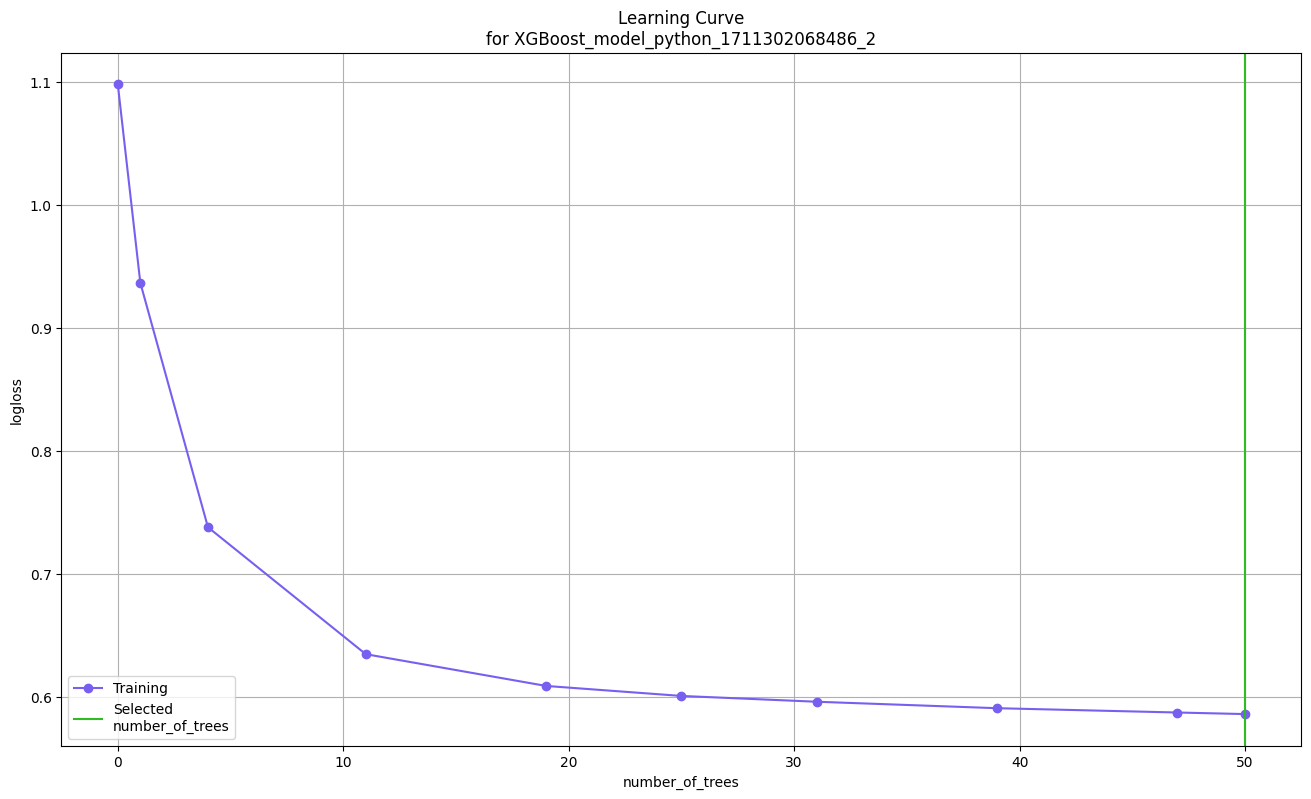

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

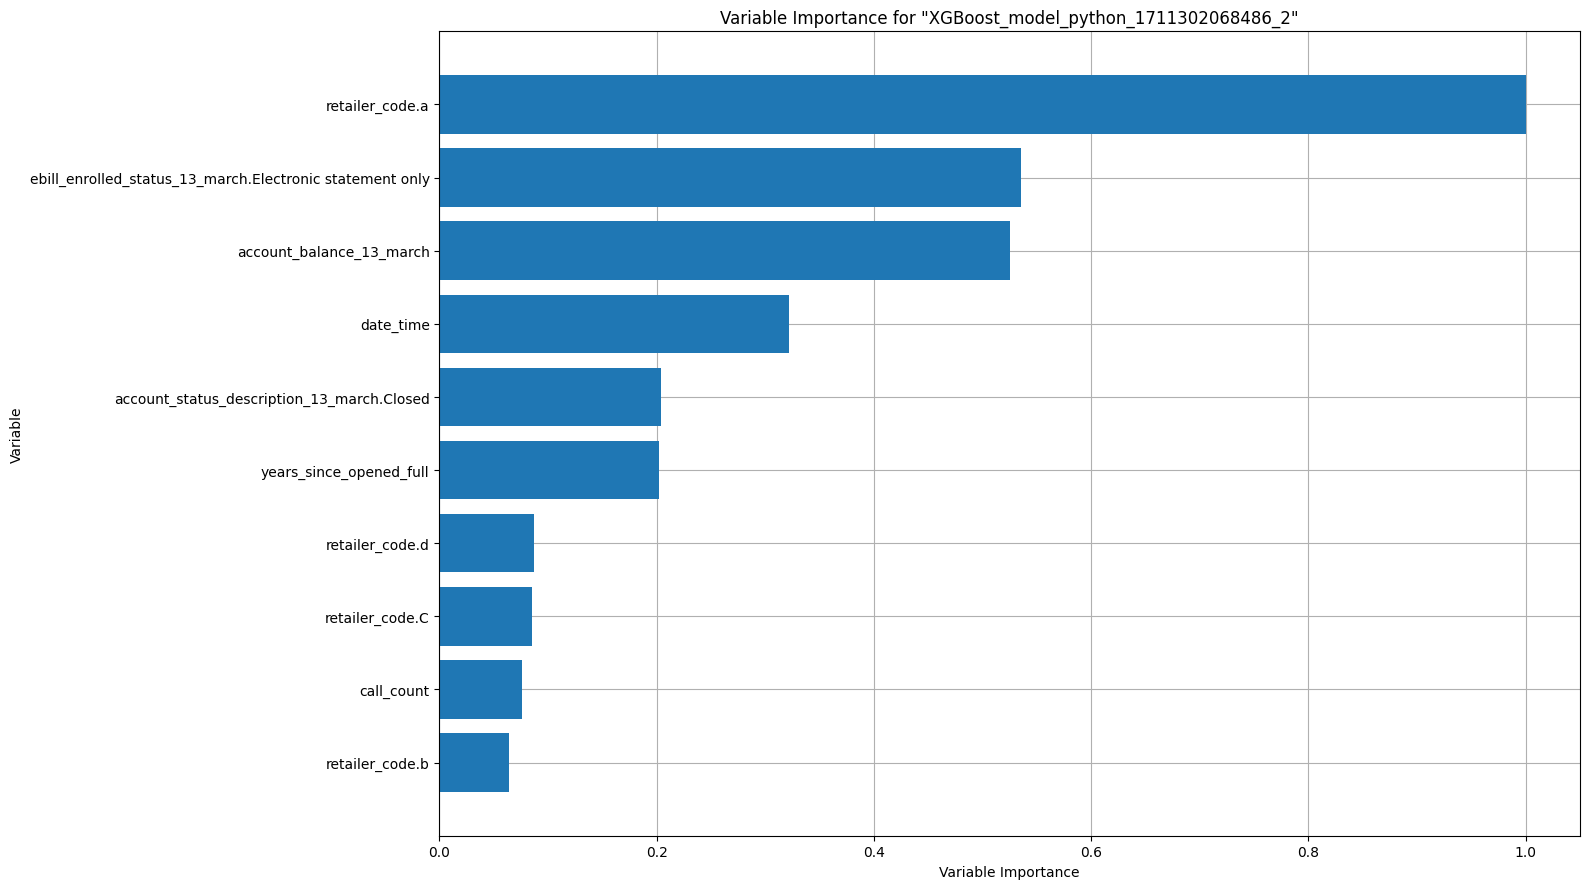

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

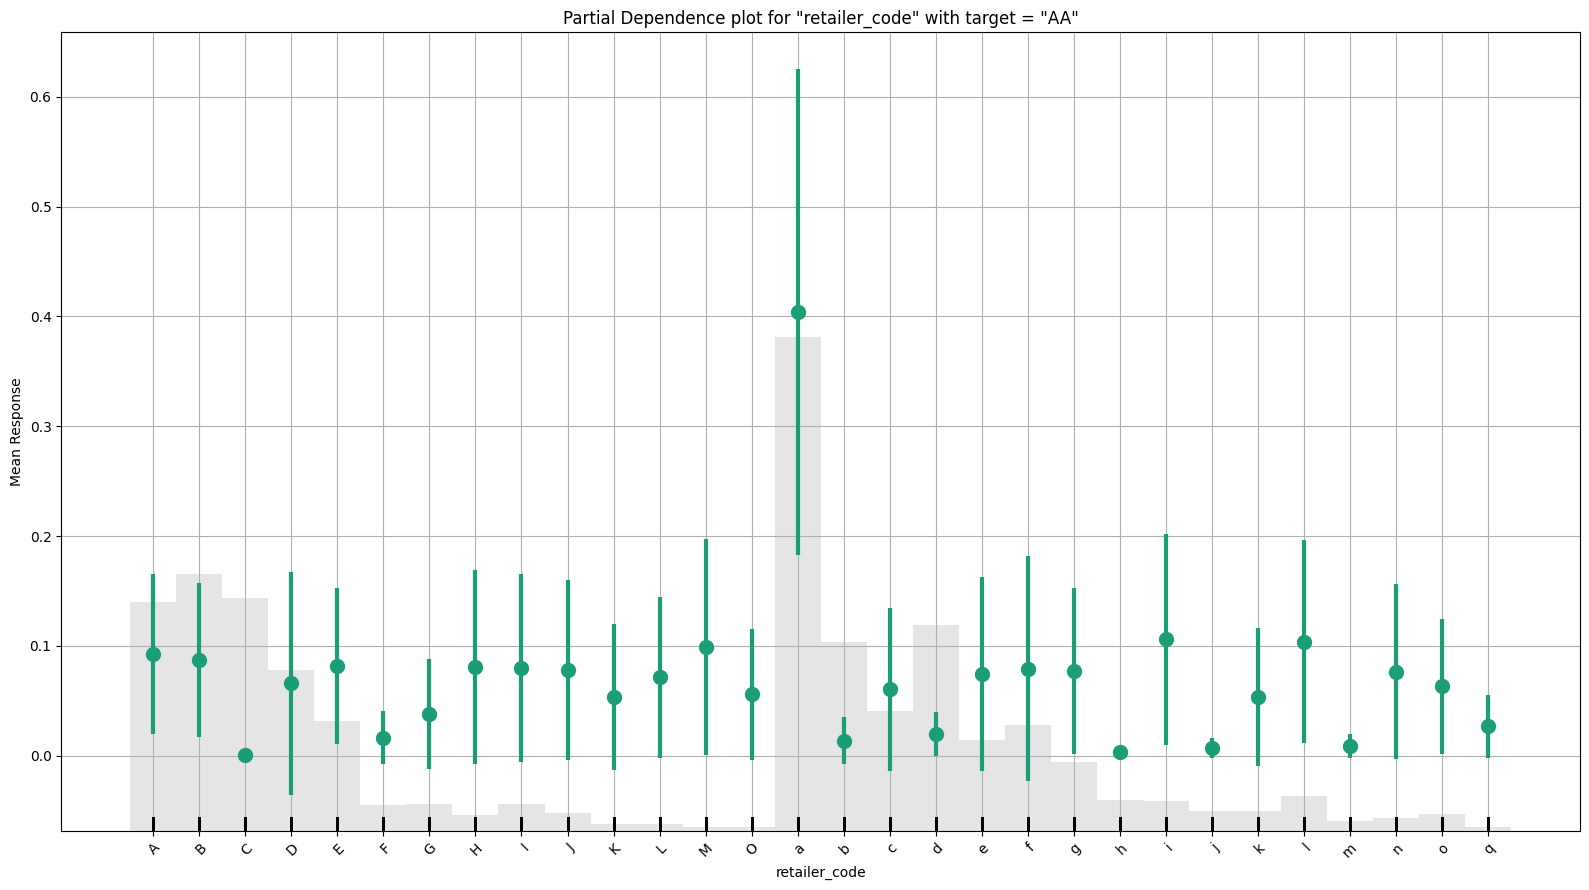

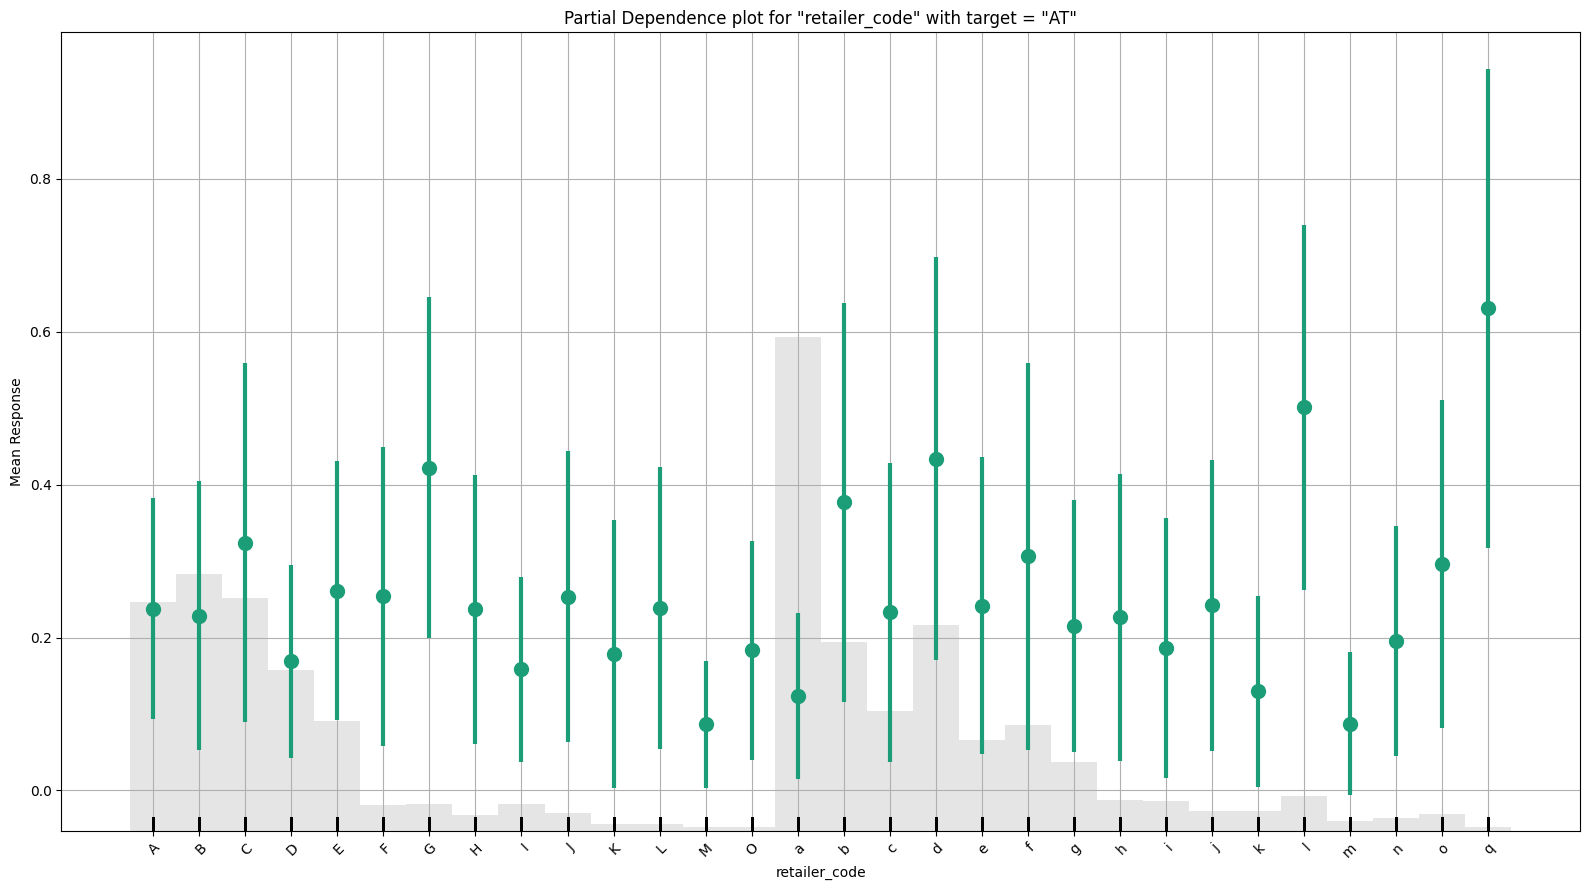

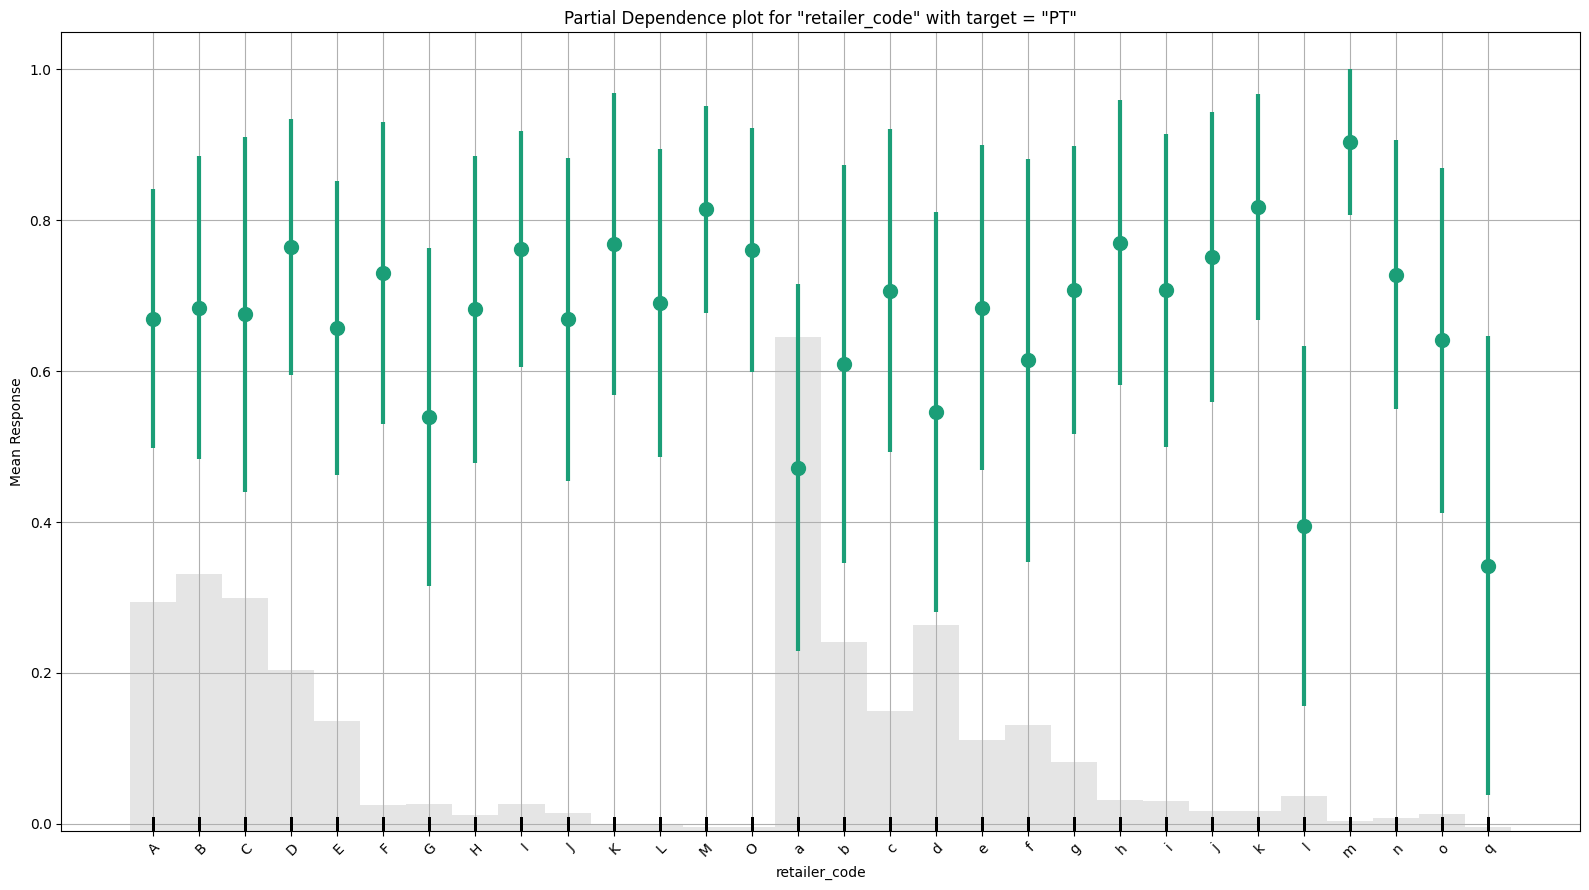

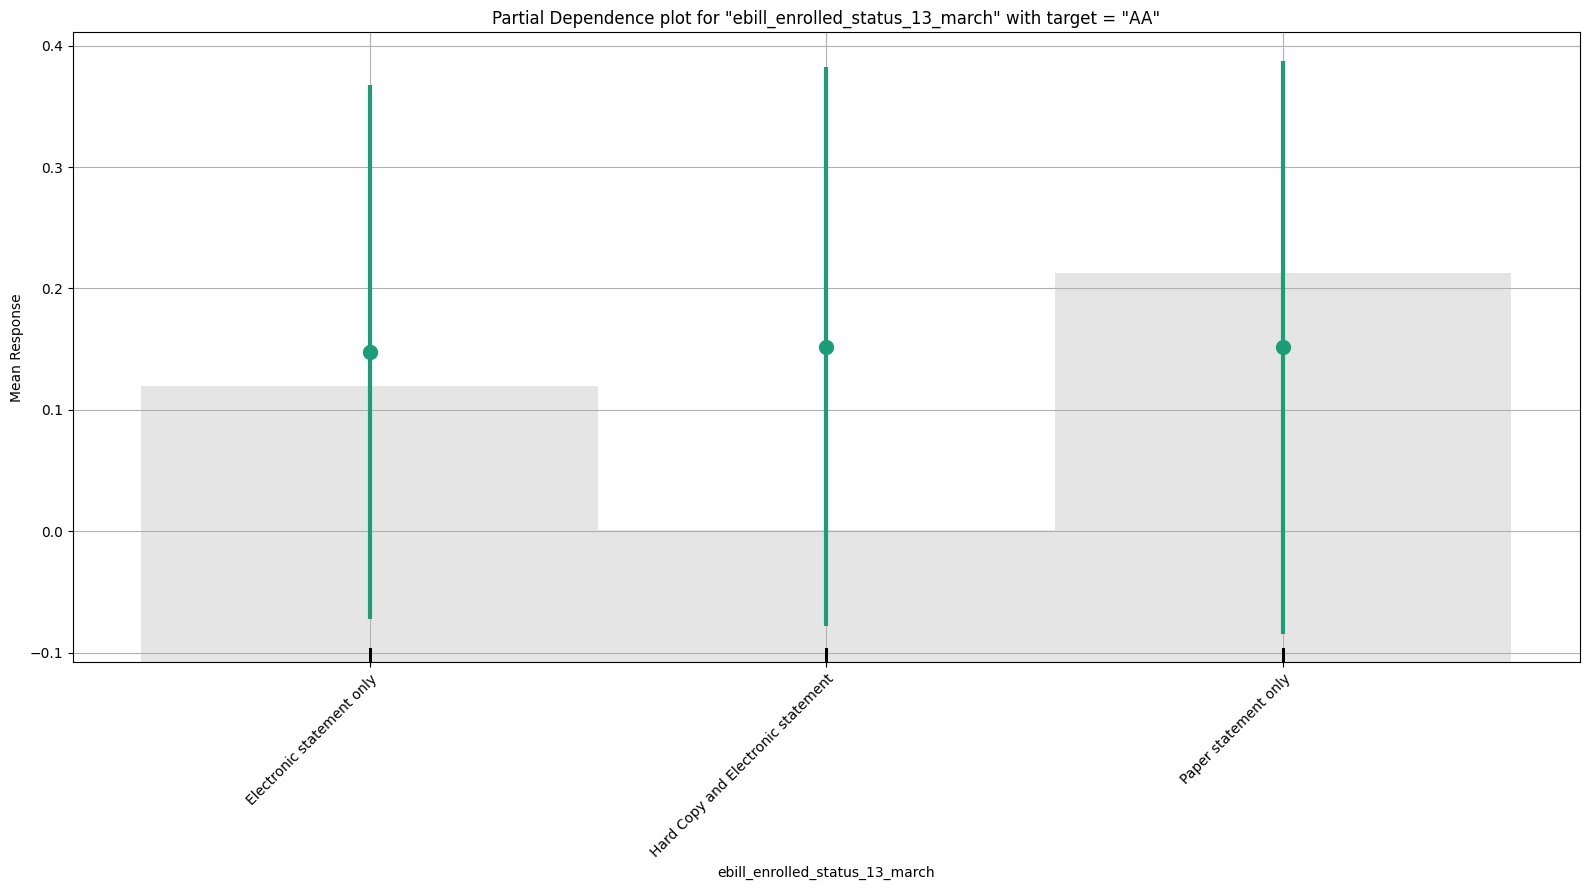

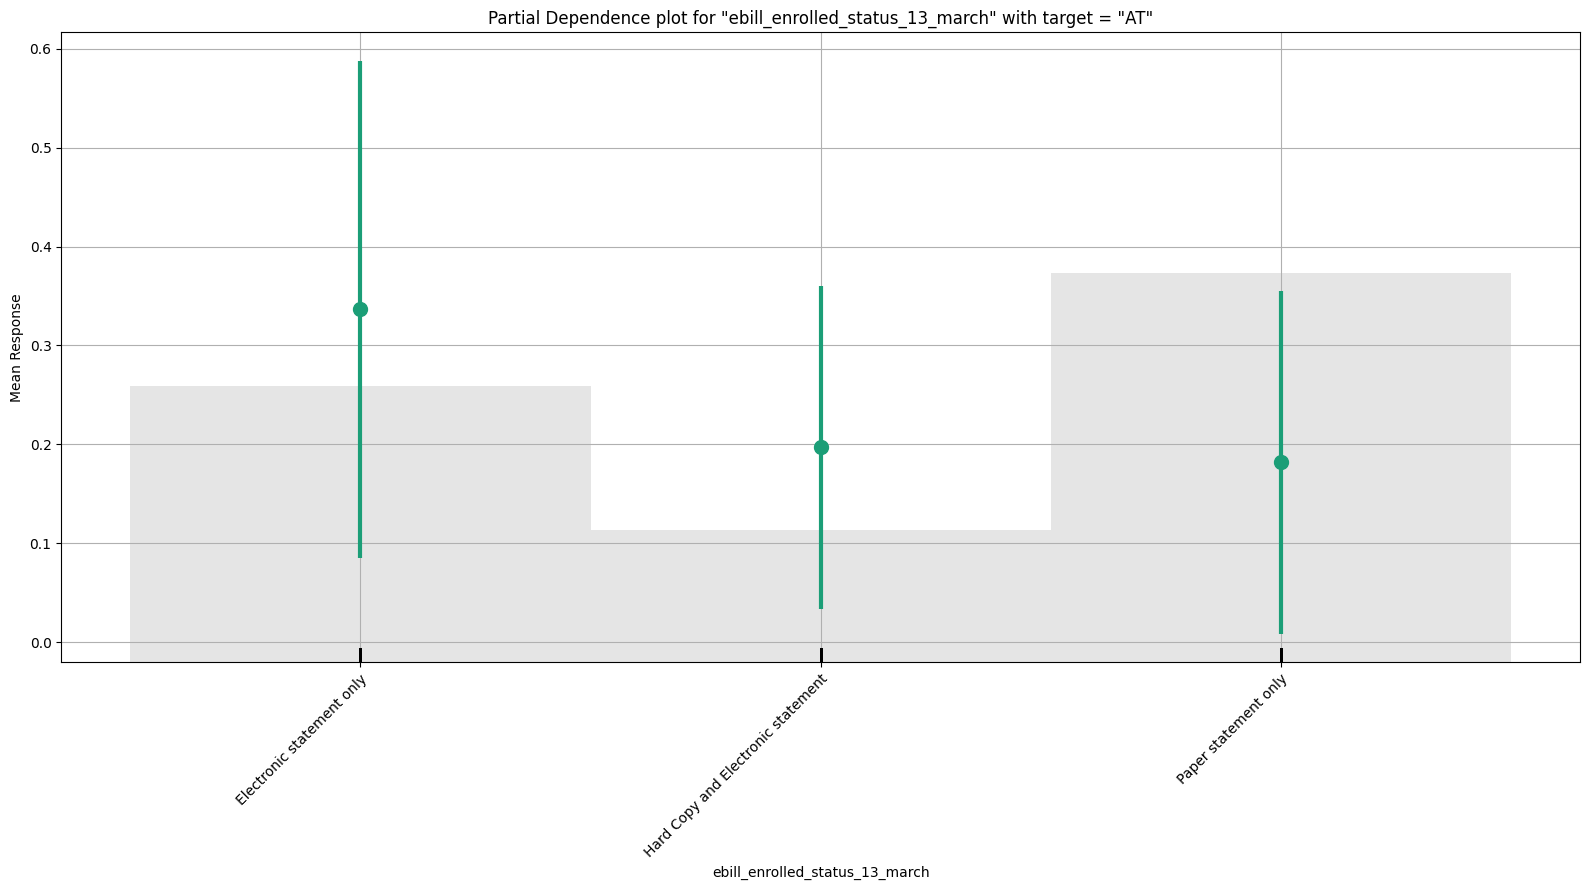

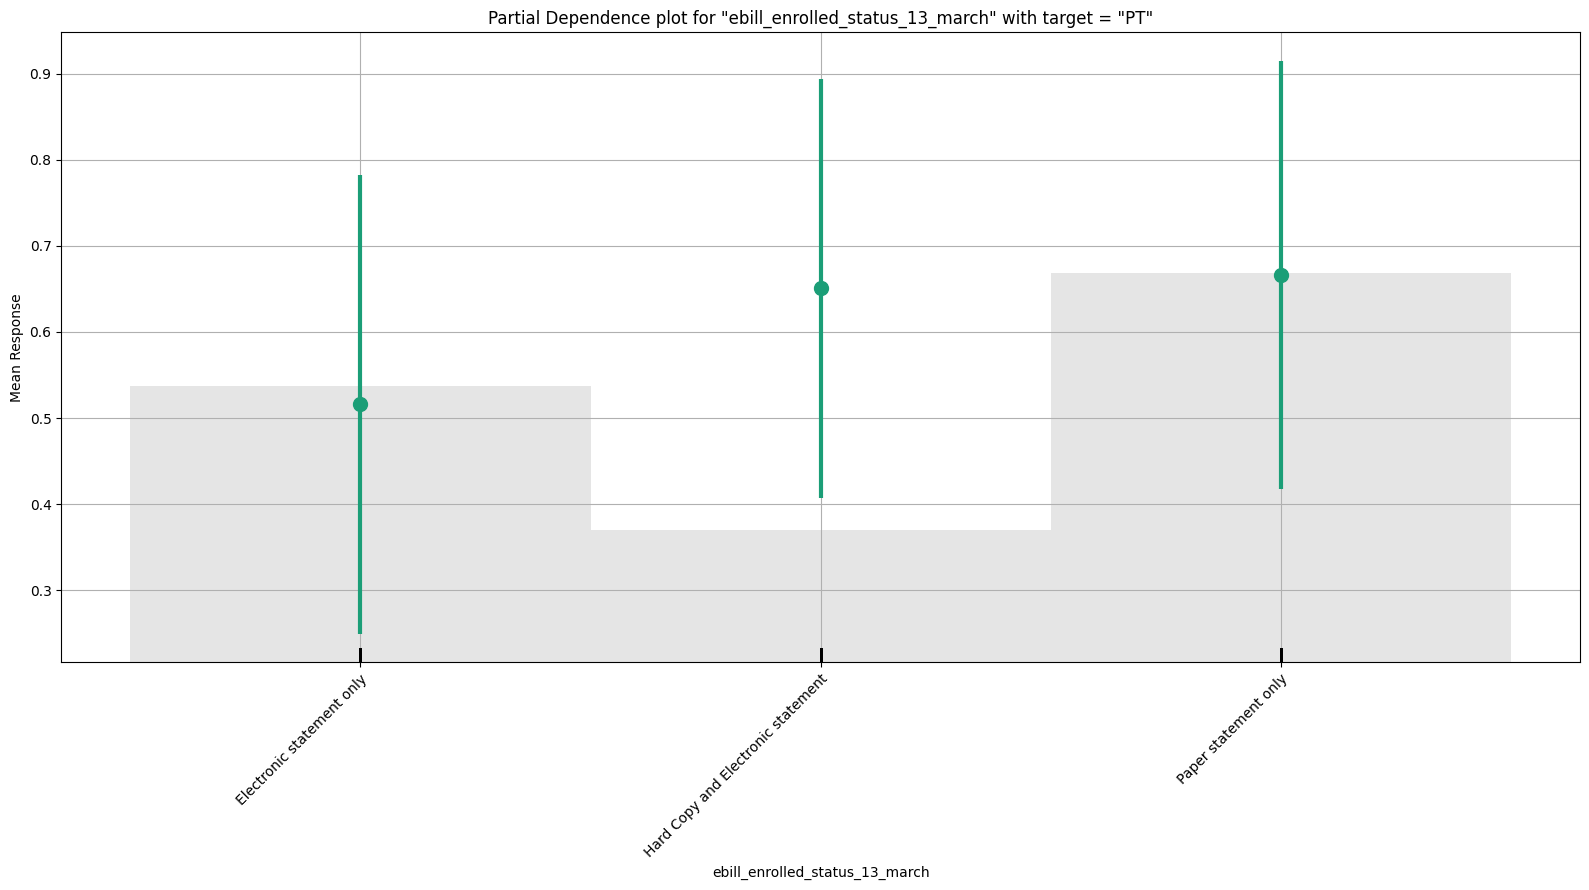

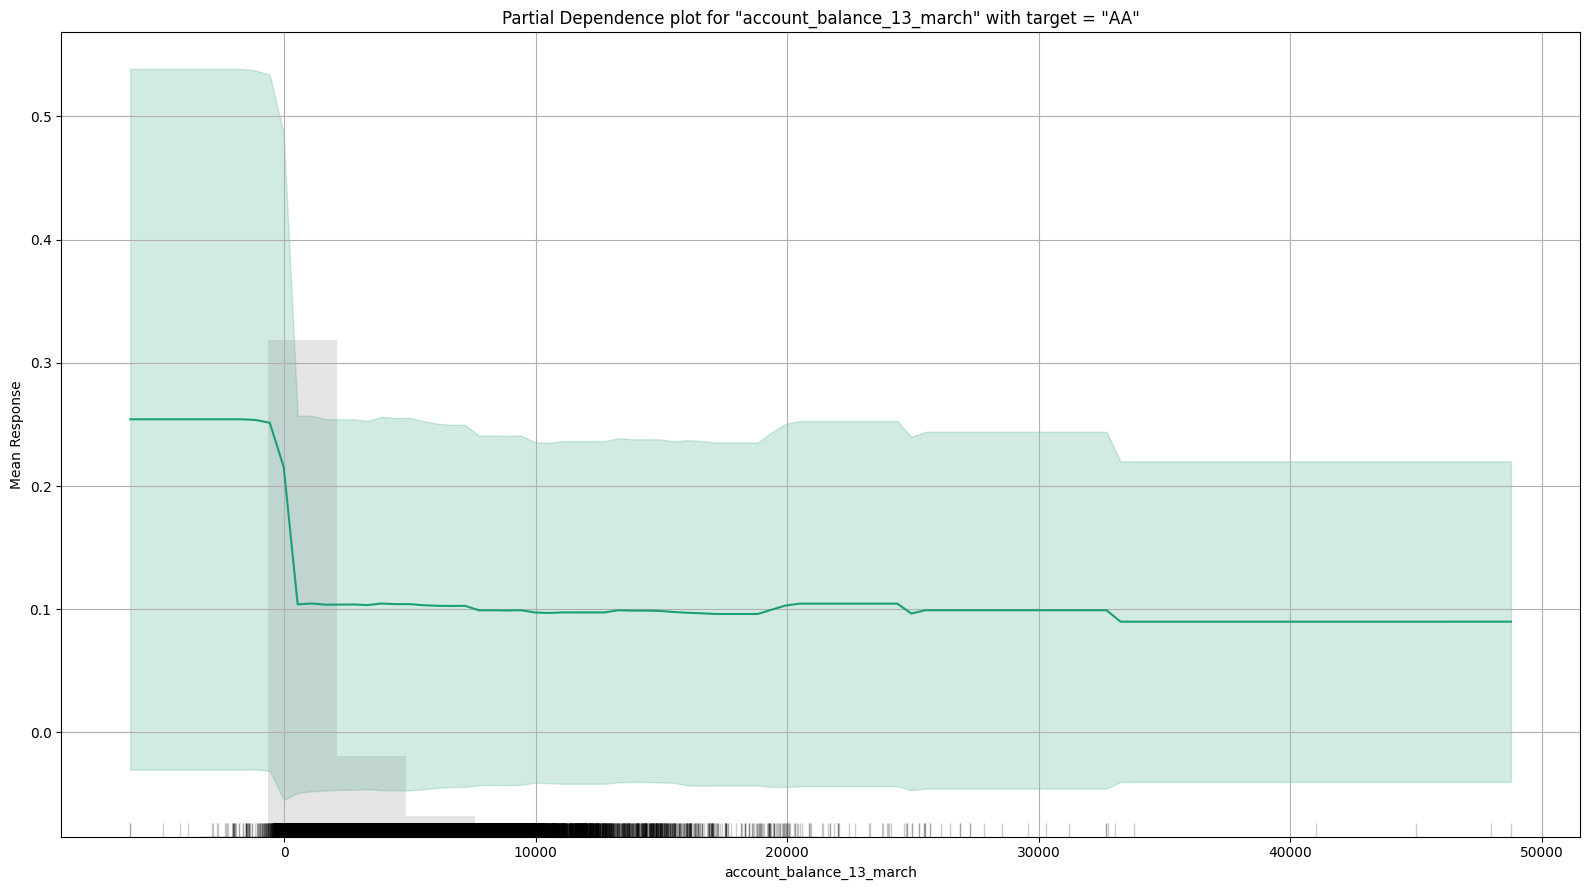

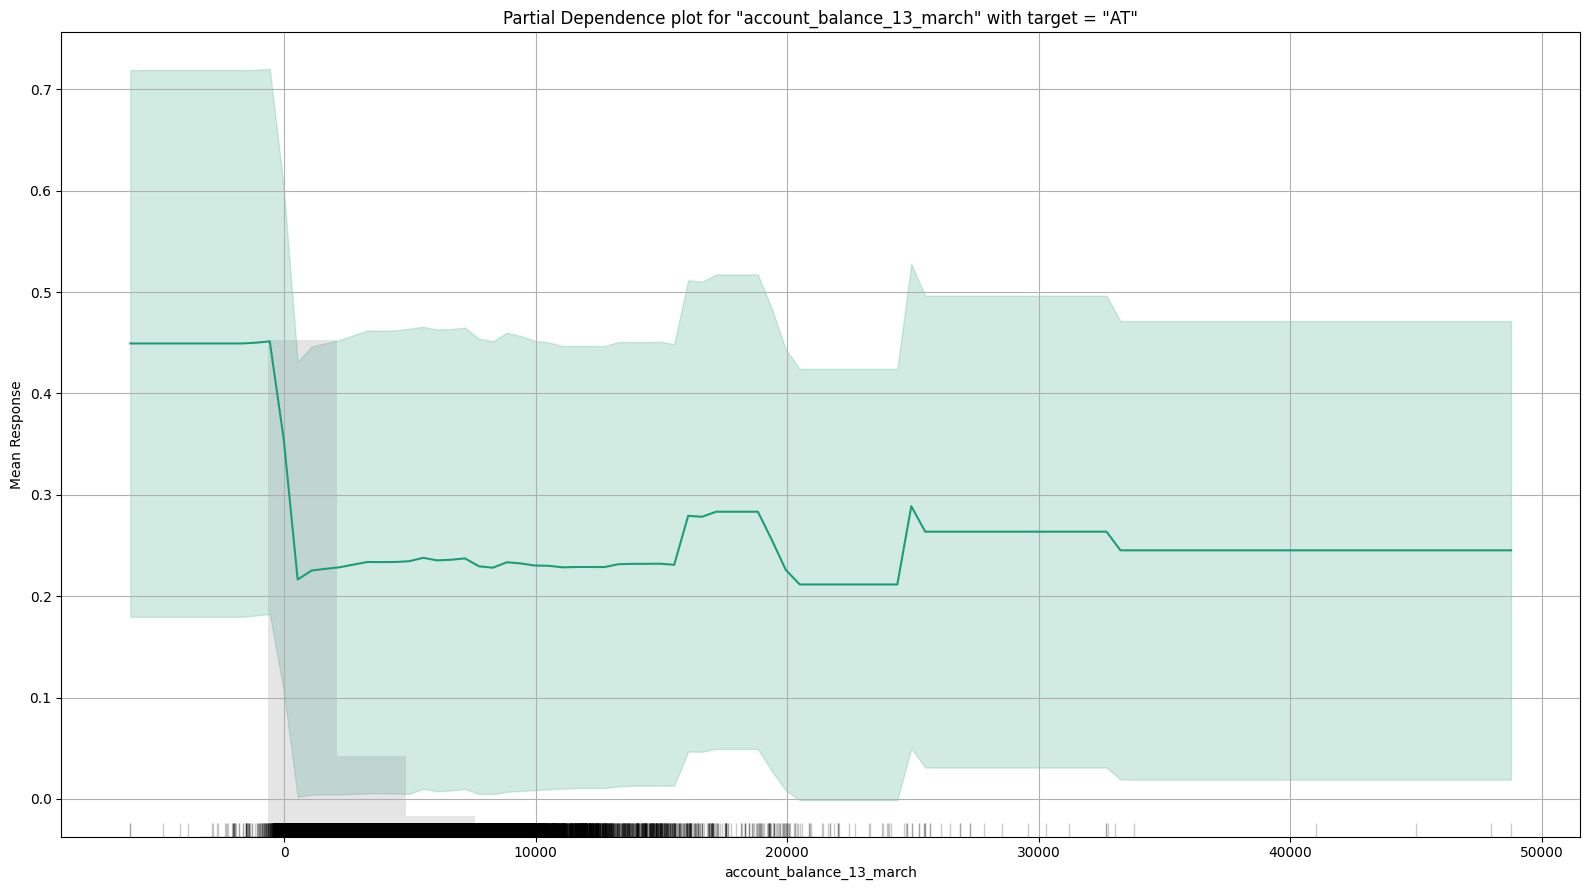

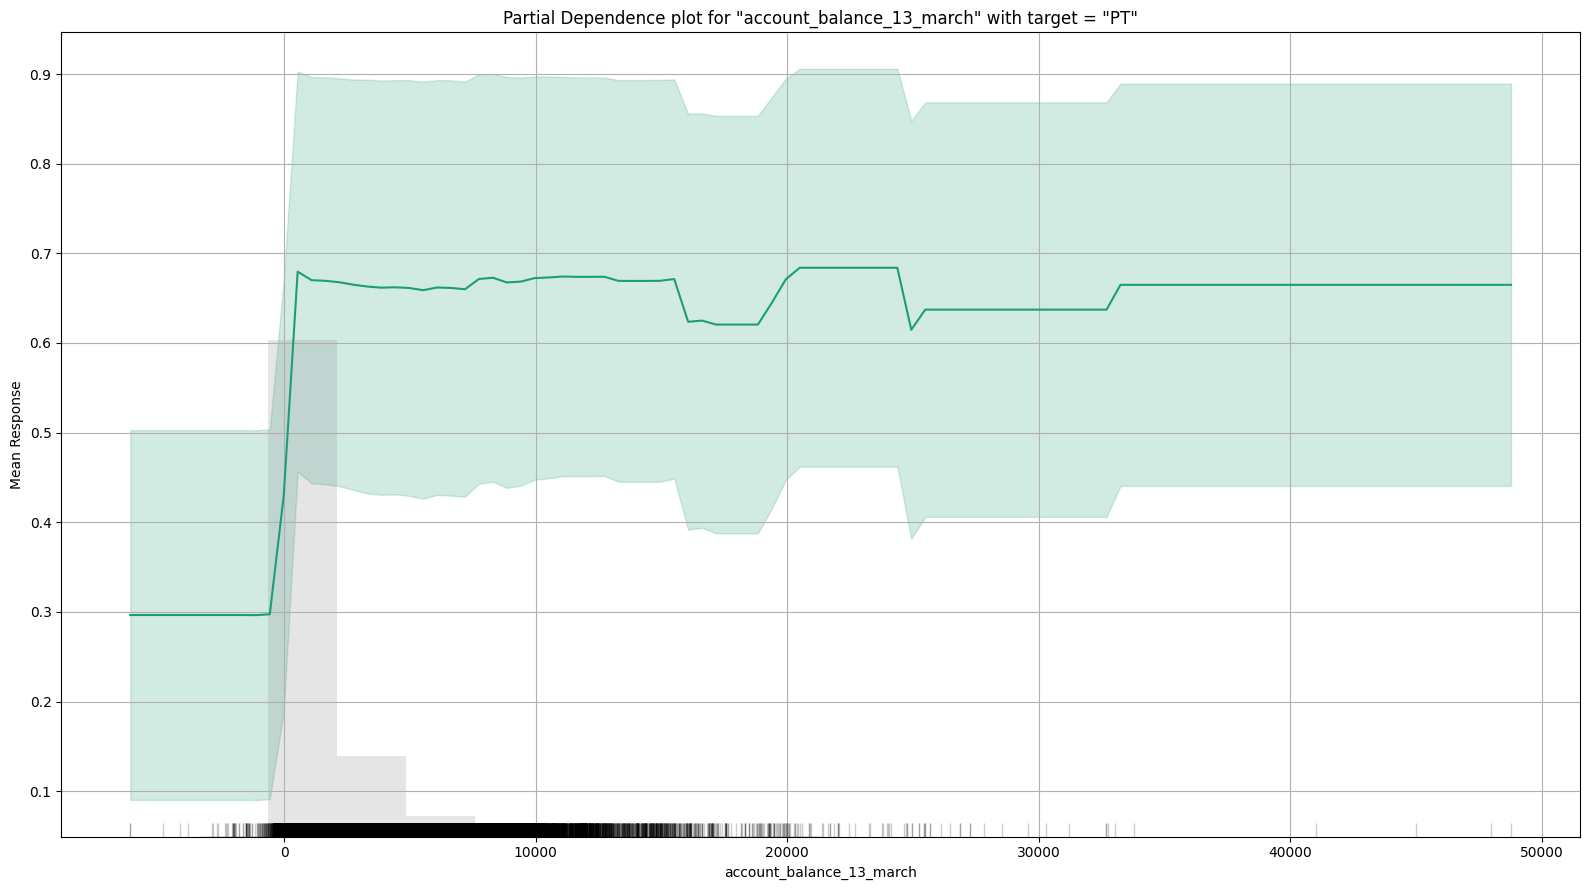

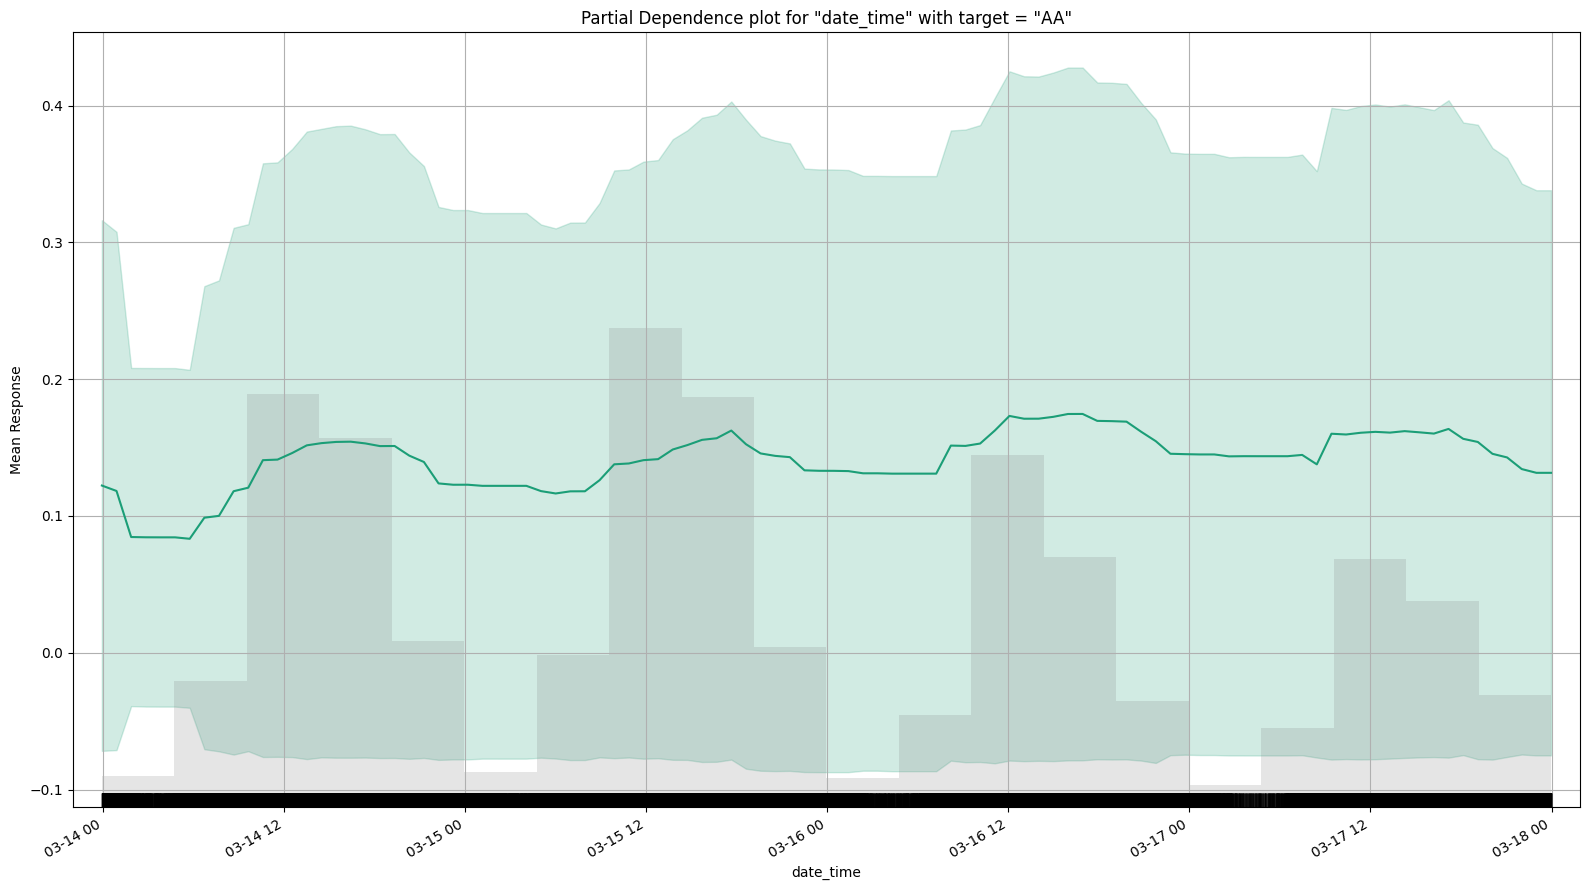

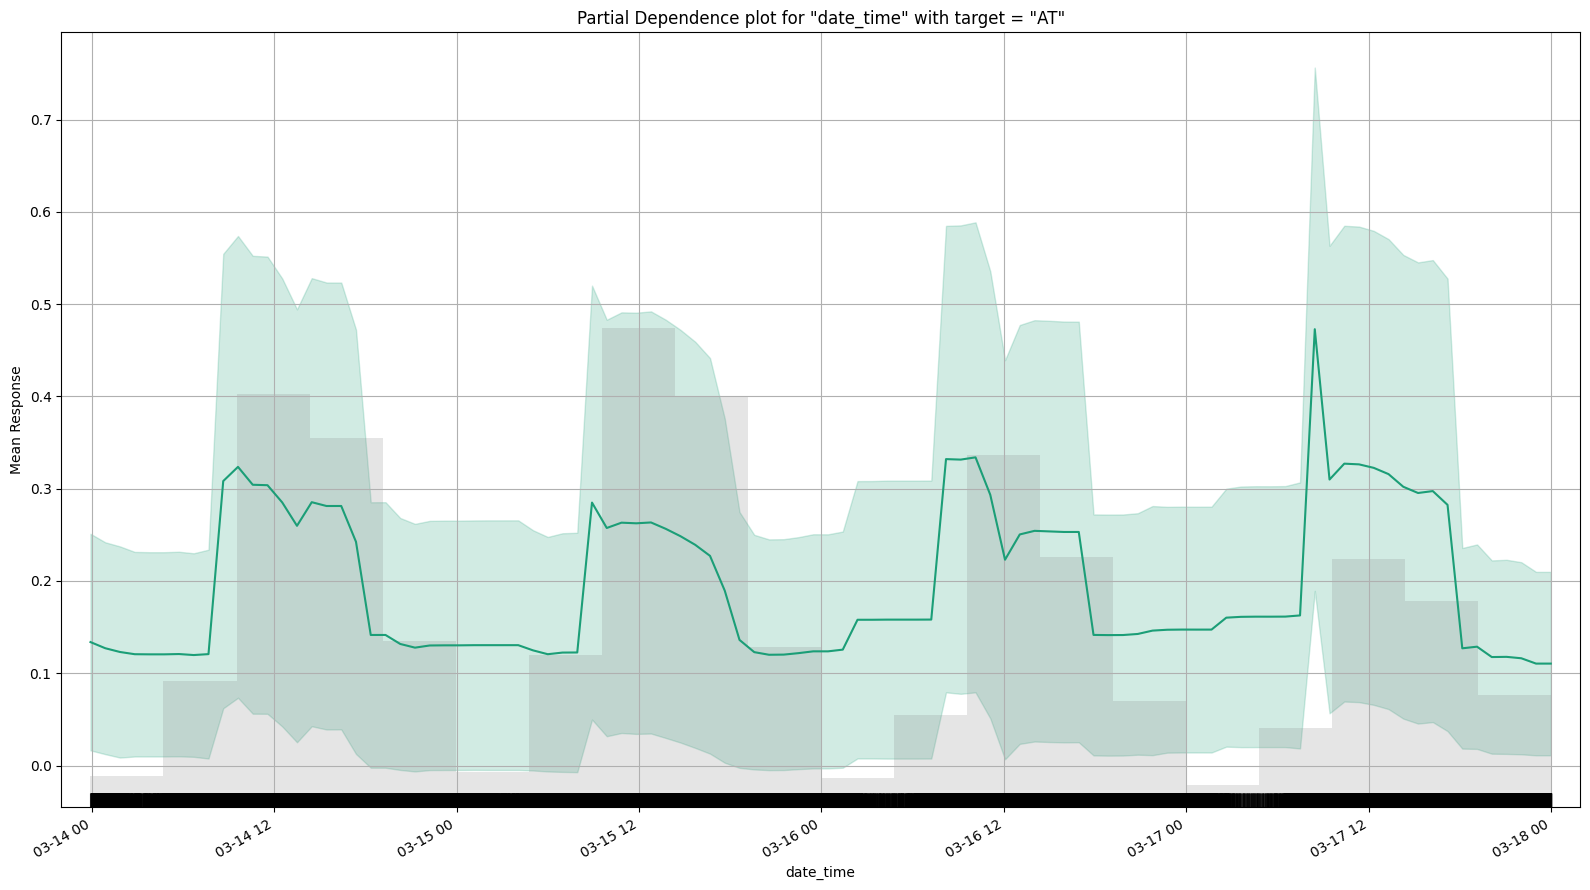

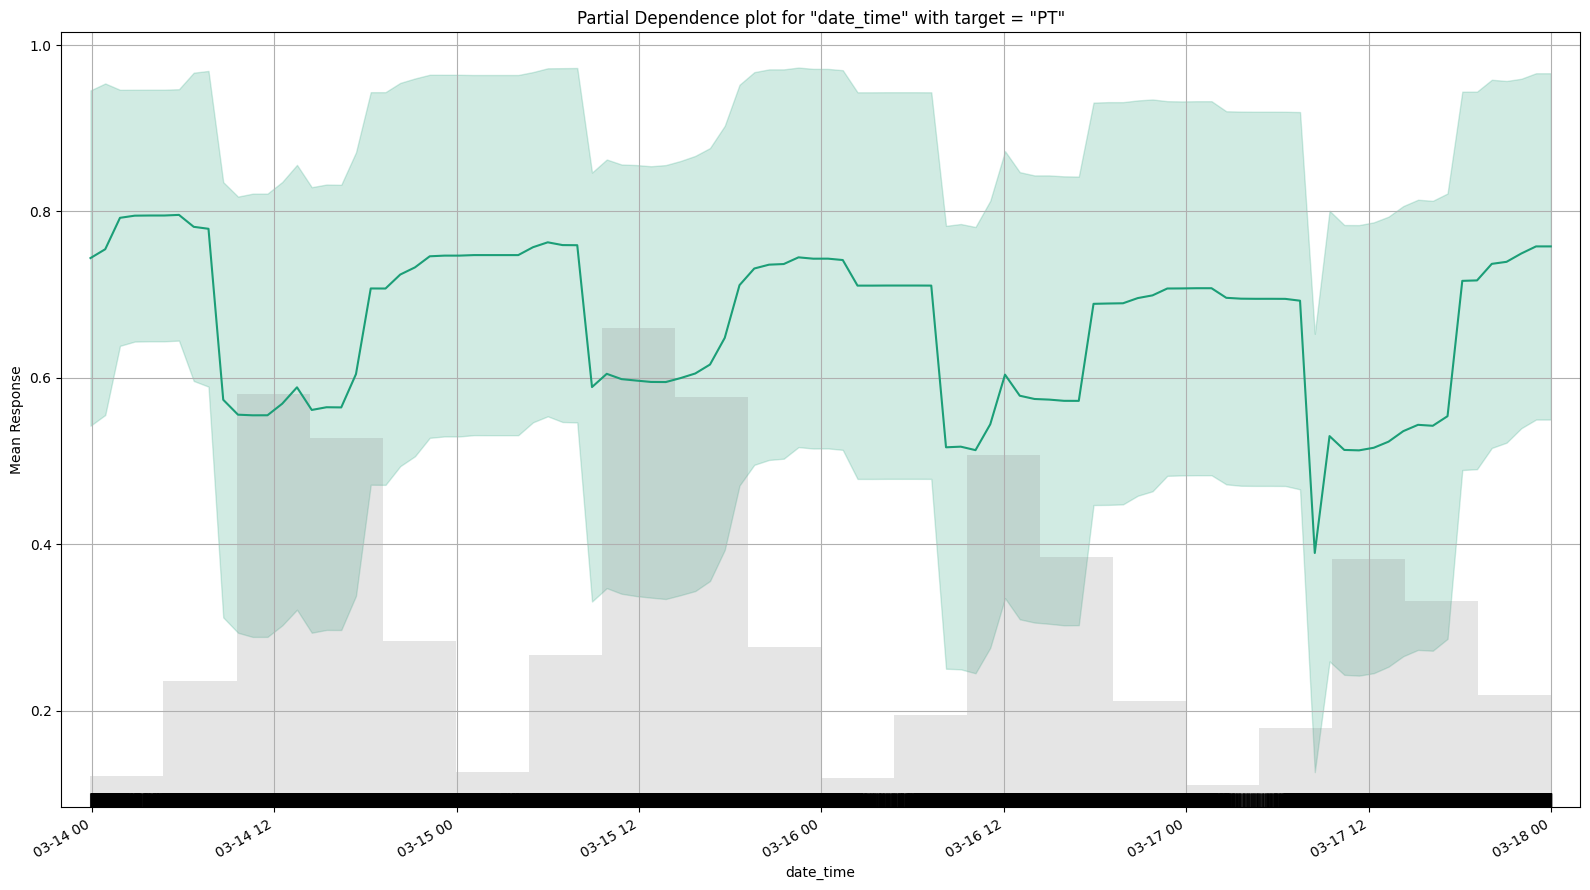

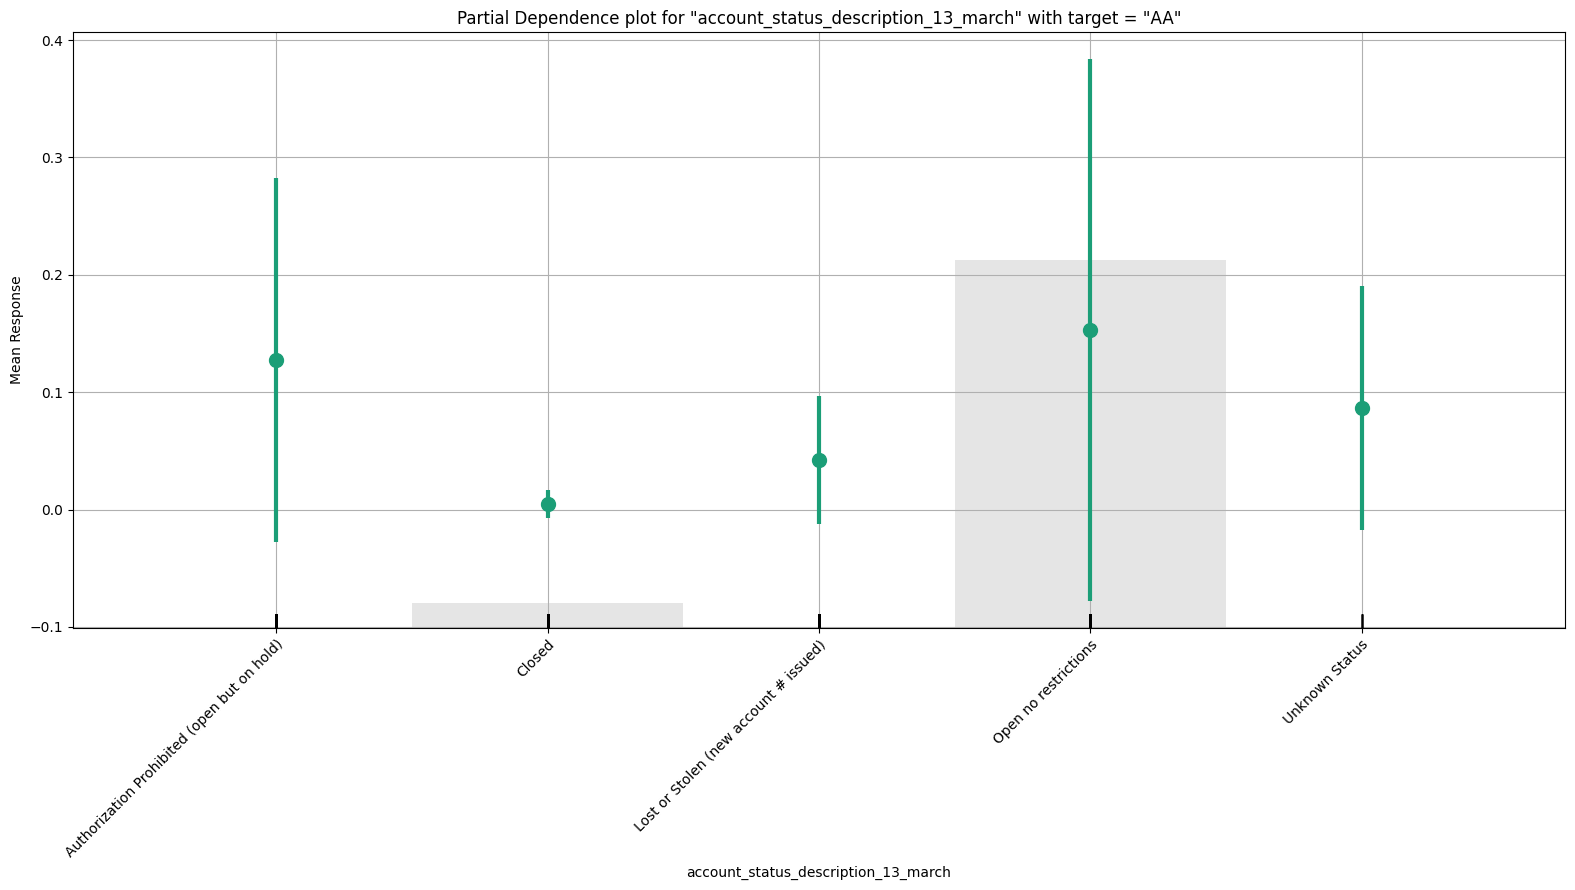

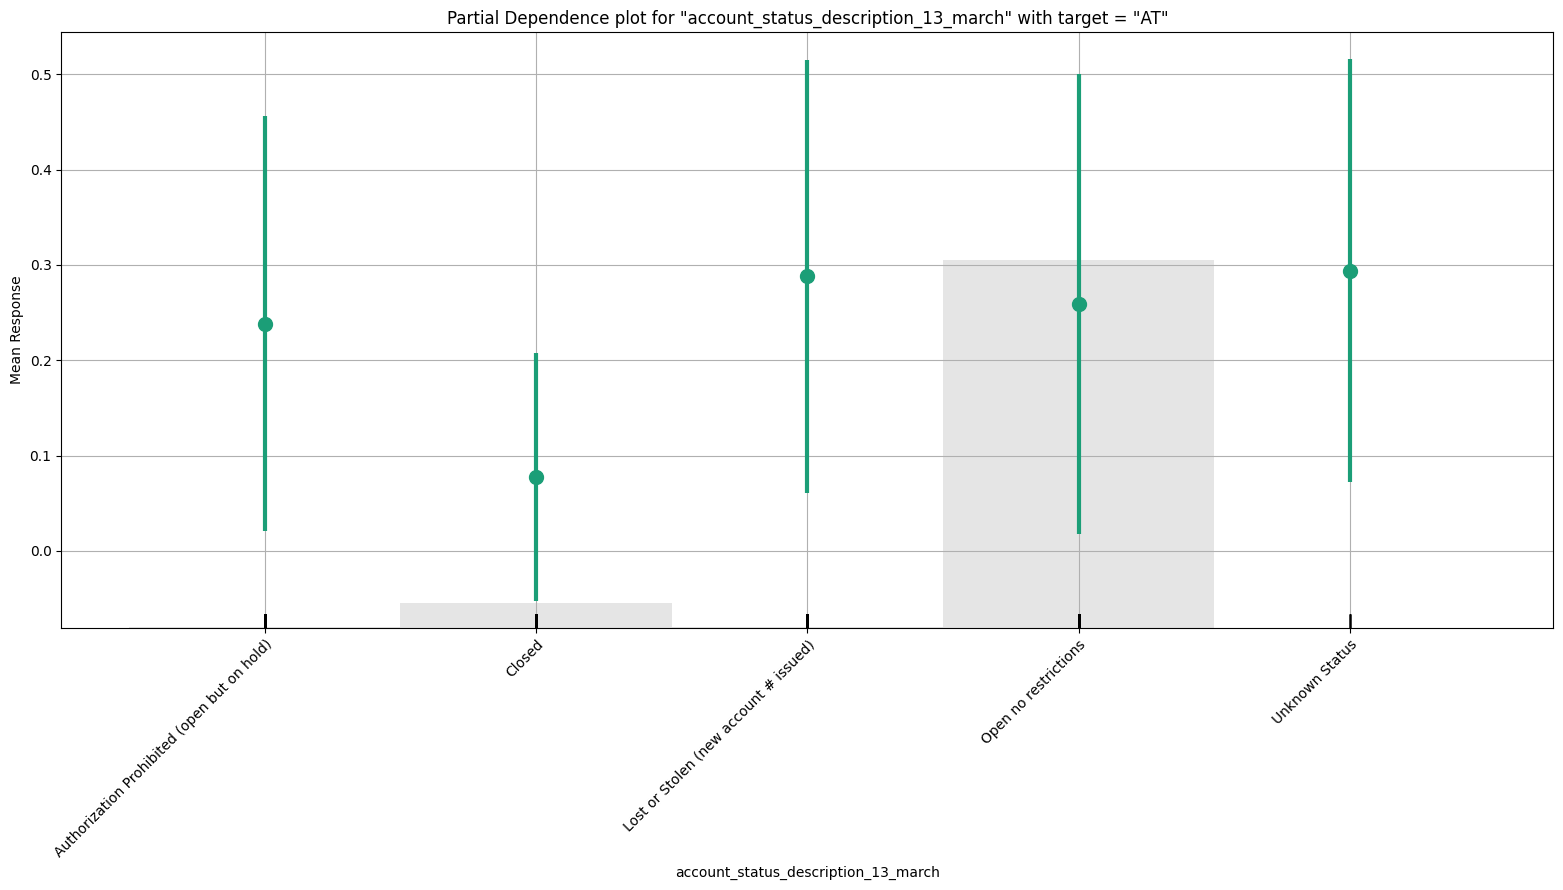

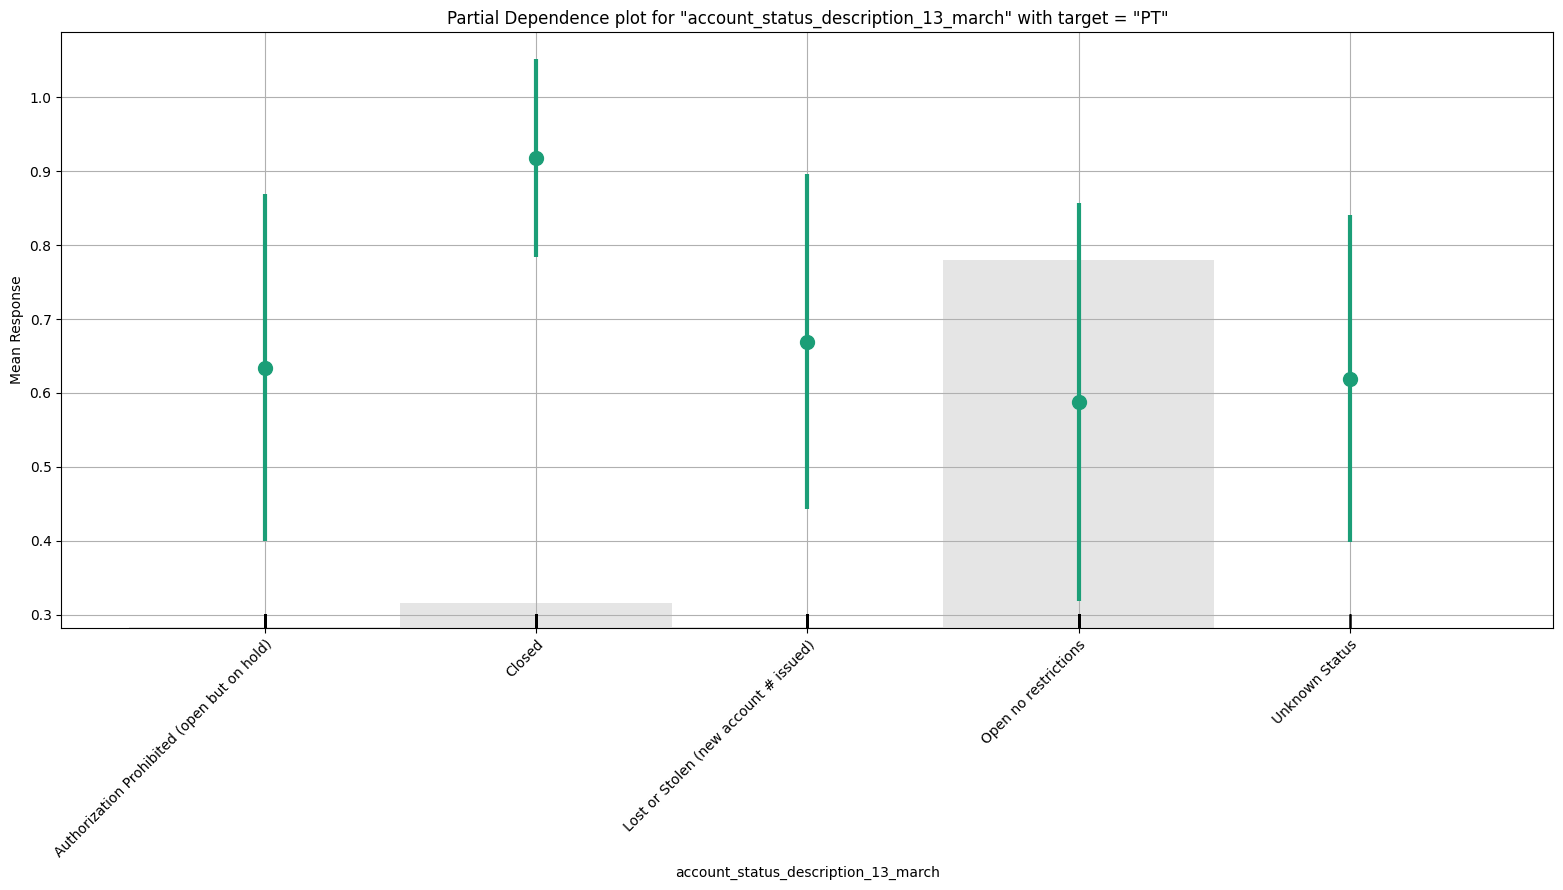

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## XGBoost_model_python_1711302068486_2

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
AA     AT     PT      Error     Rate
-----  -----  ------  --------  ----------------
25545  1720   16674   0.418626  18,394 / 43,939
3272   39668  30322   0.458546  33,594 / 73,262
7319   12339  157613  0.110892  19,658 / 177,271
36136  53727  204609  0.243303  71,646 / 294,472

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

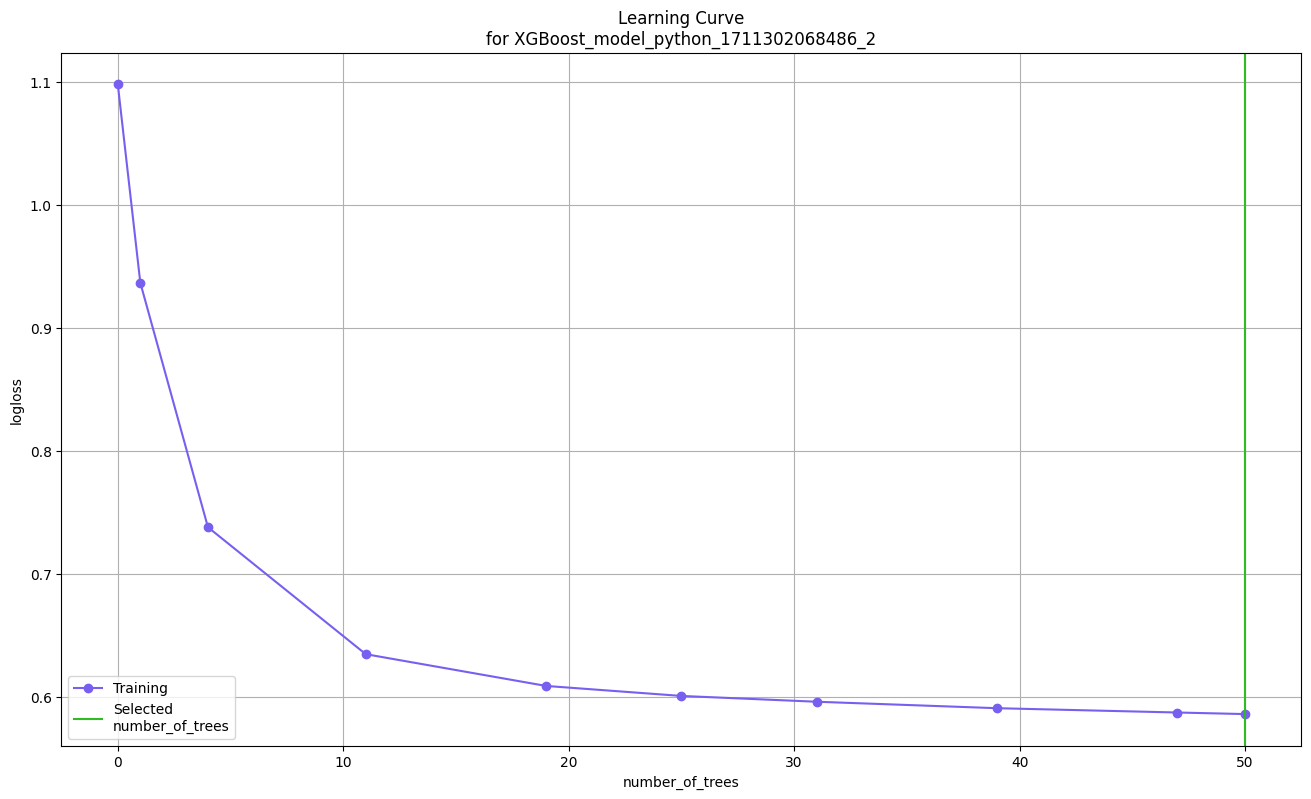

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

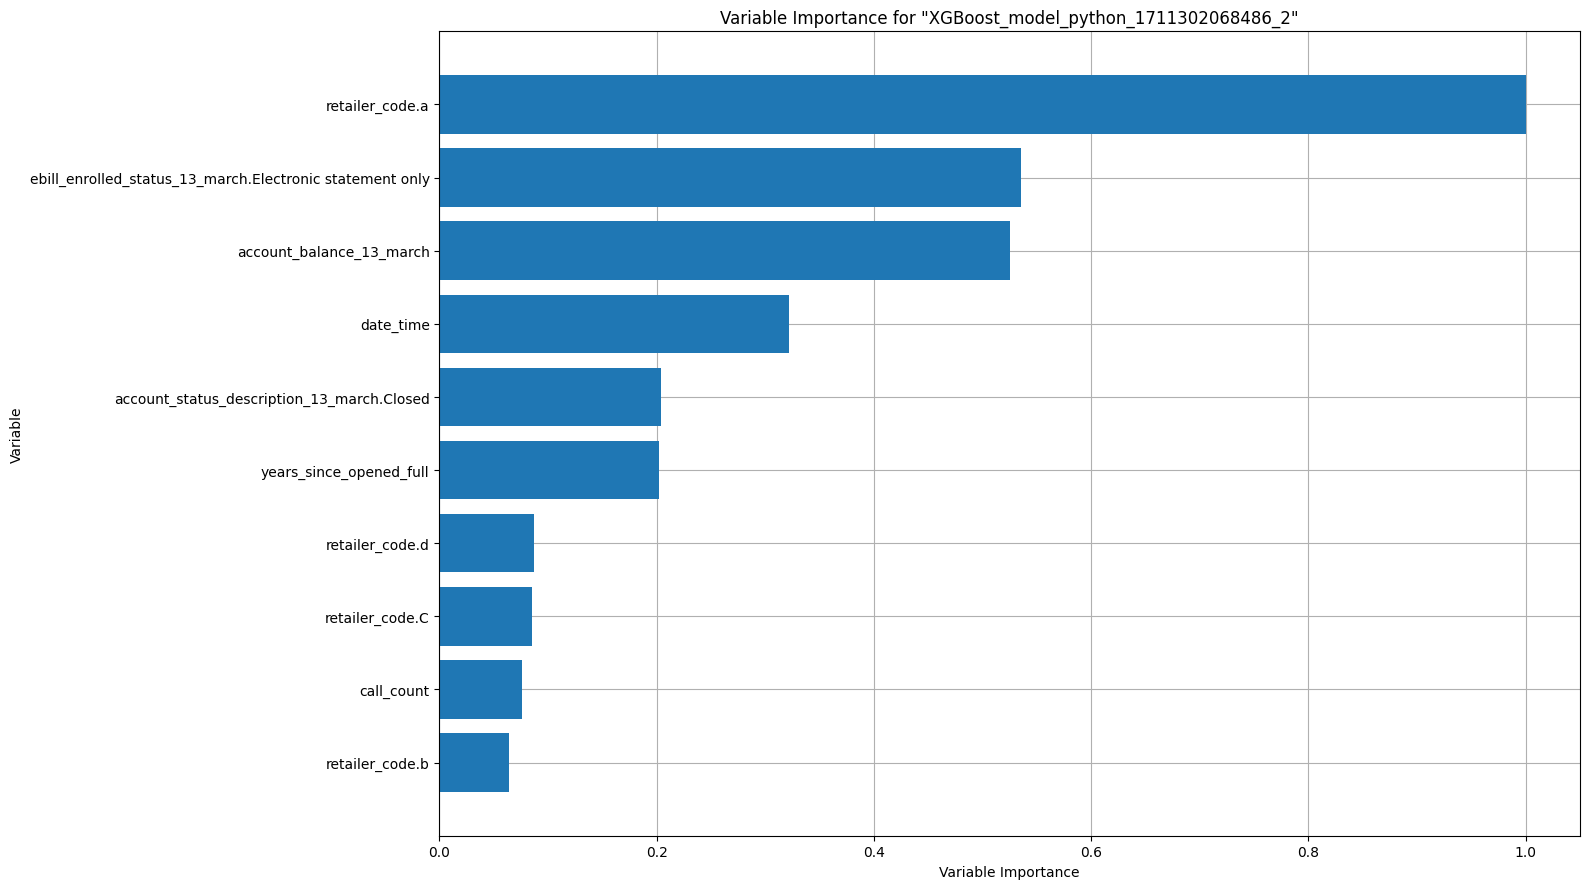

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

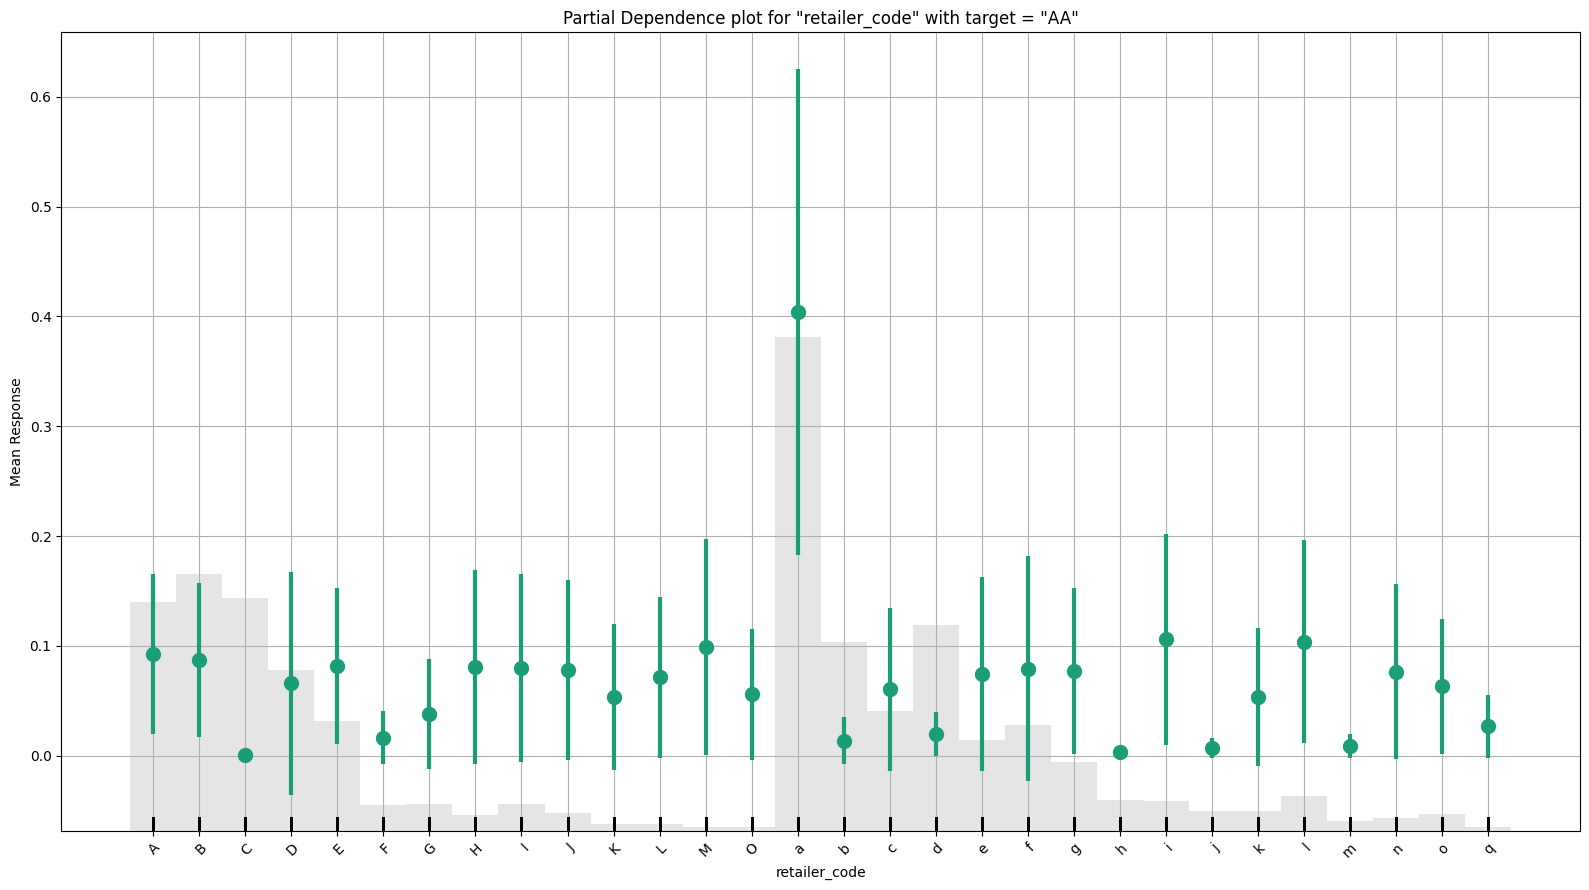

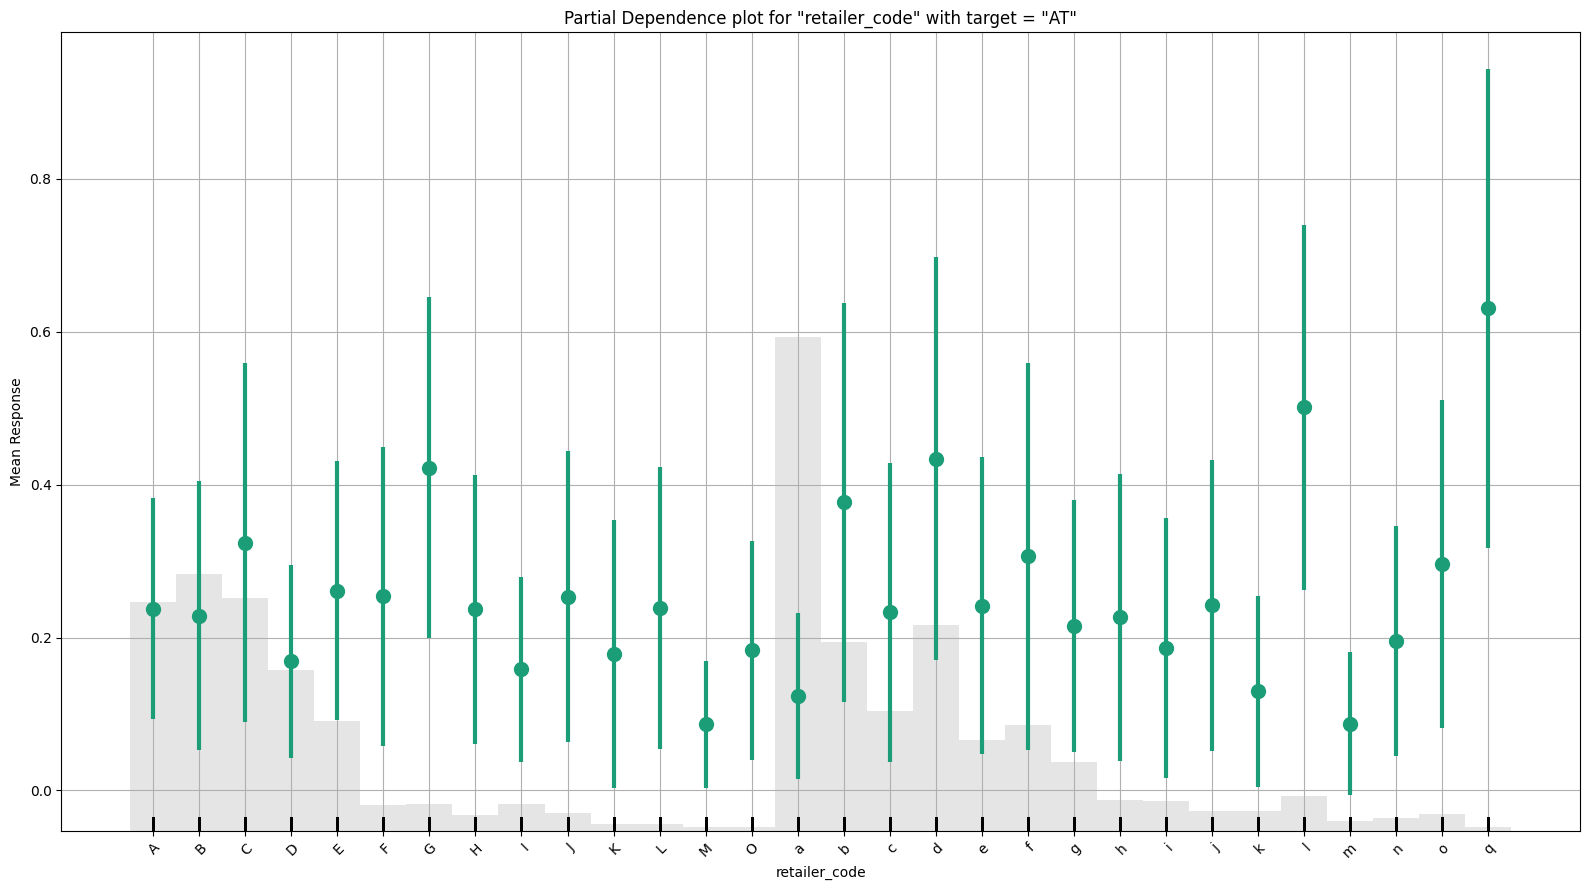

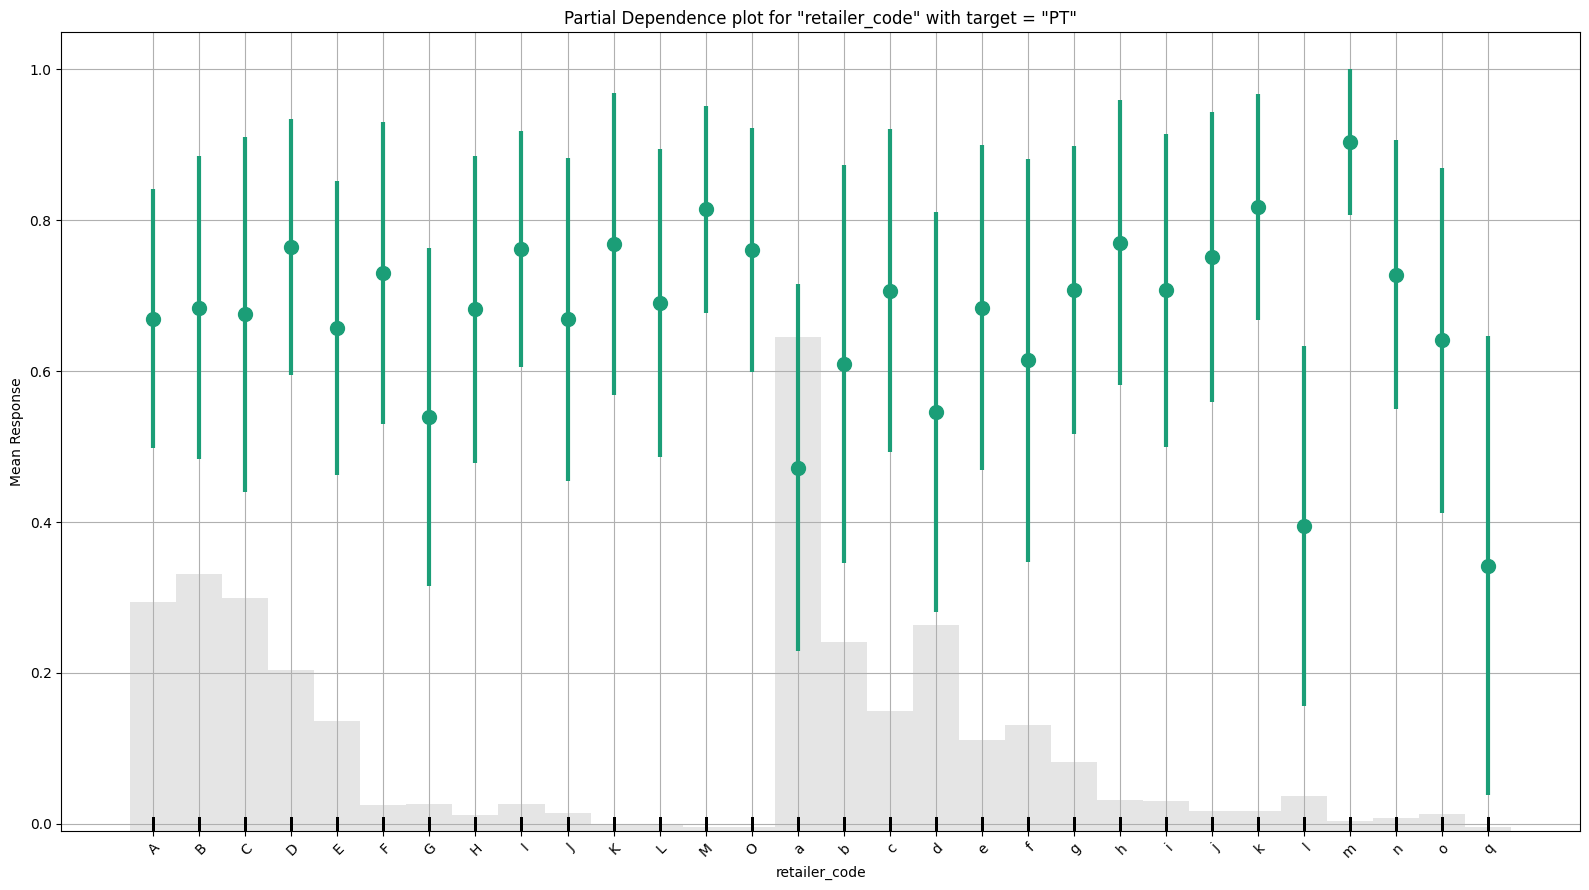

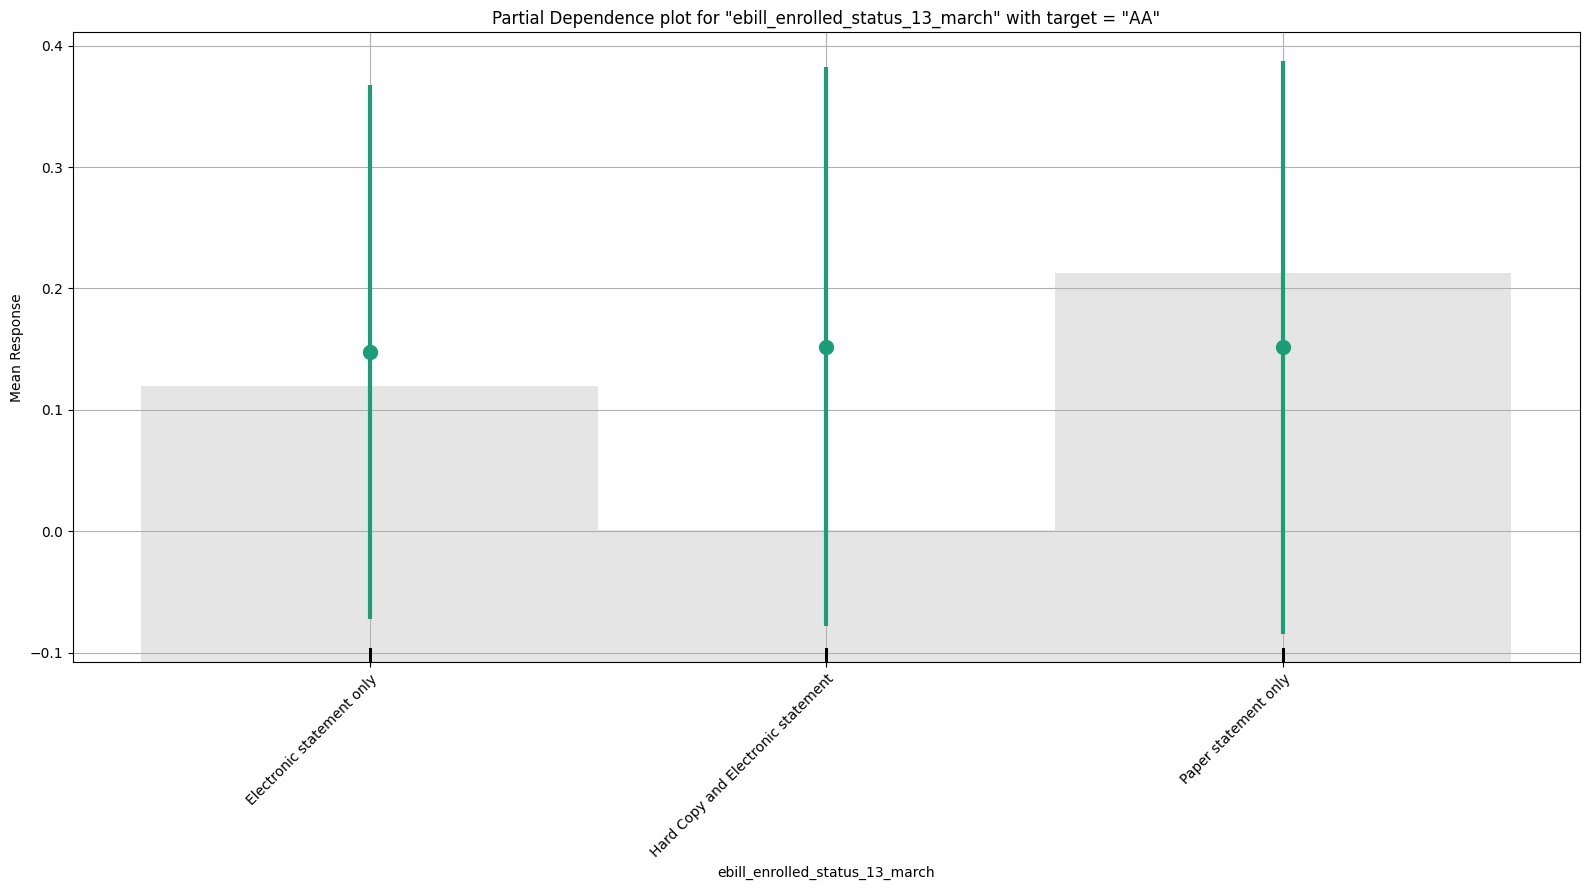

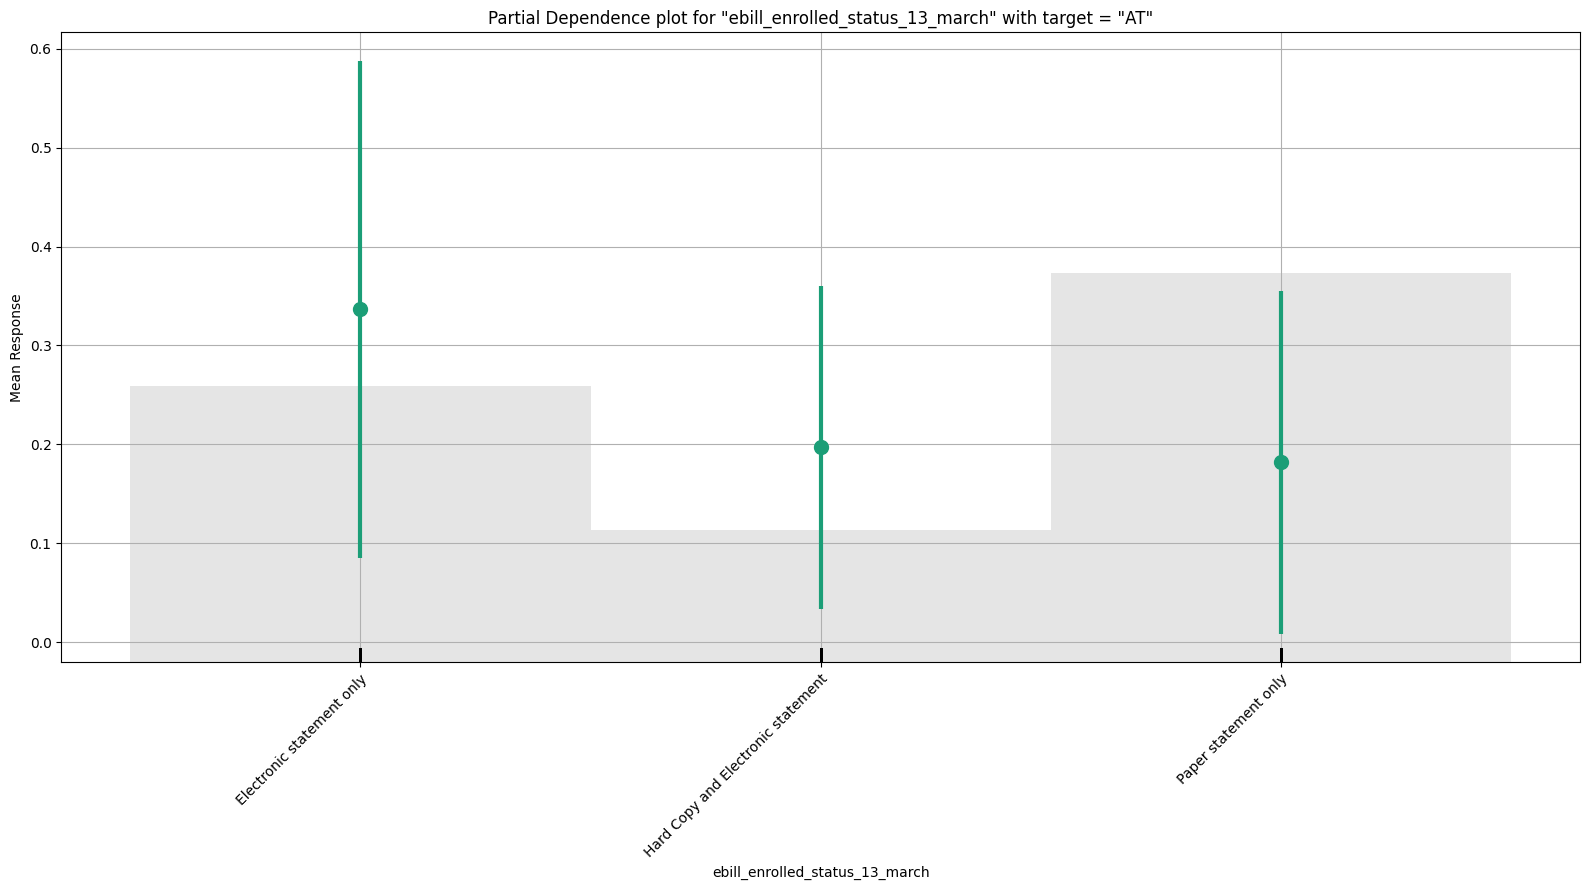

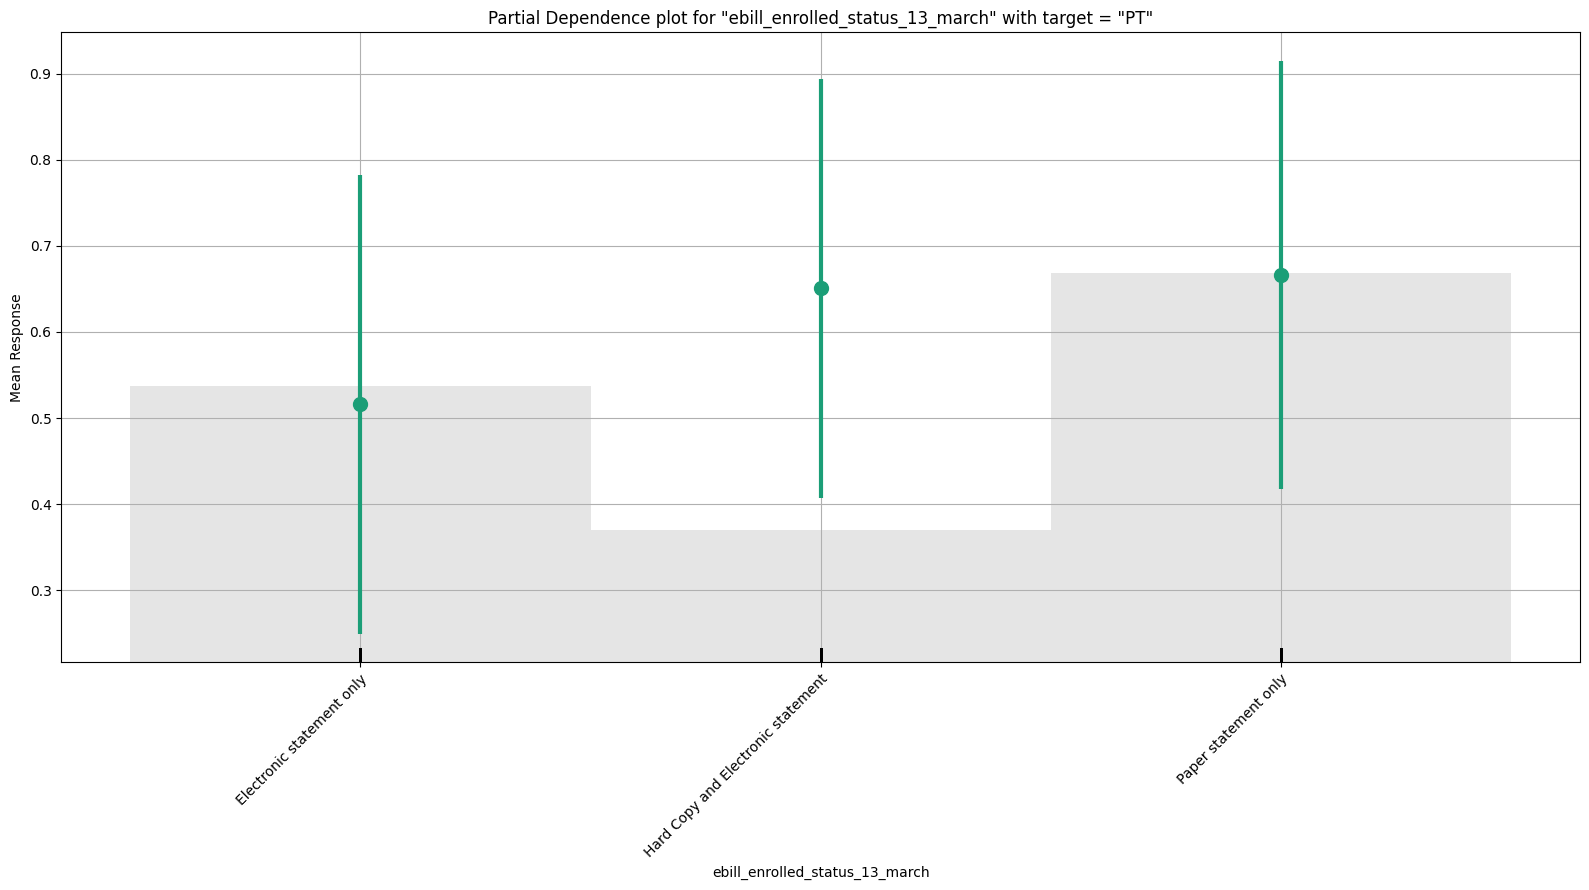

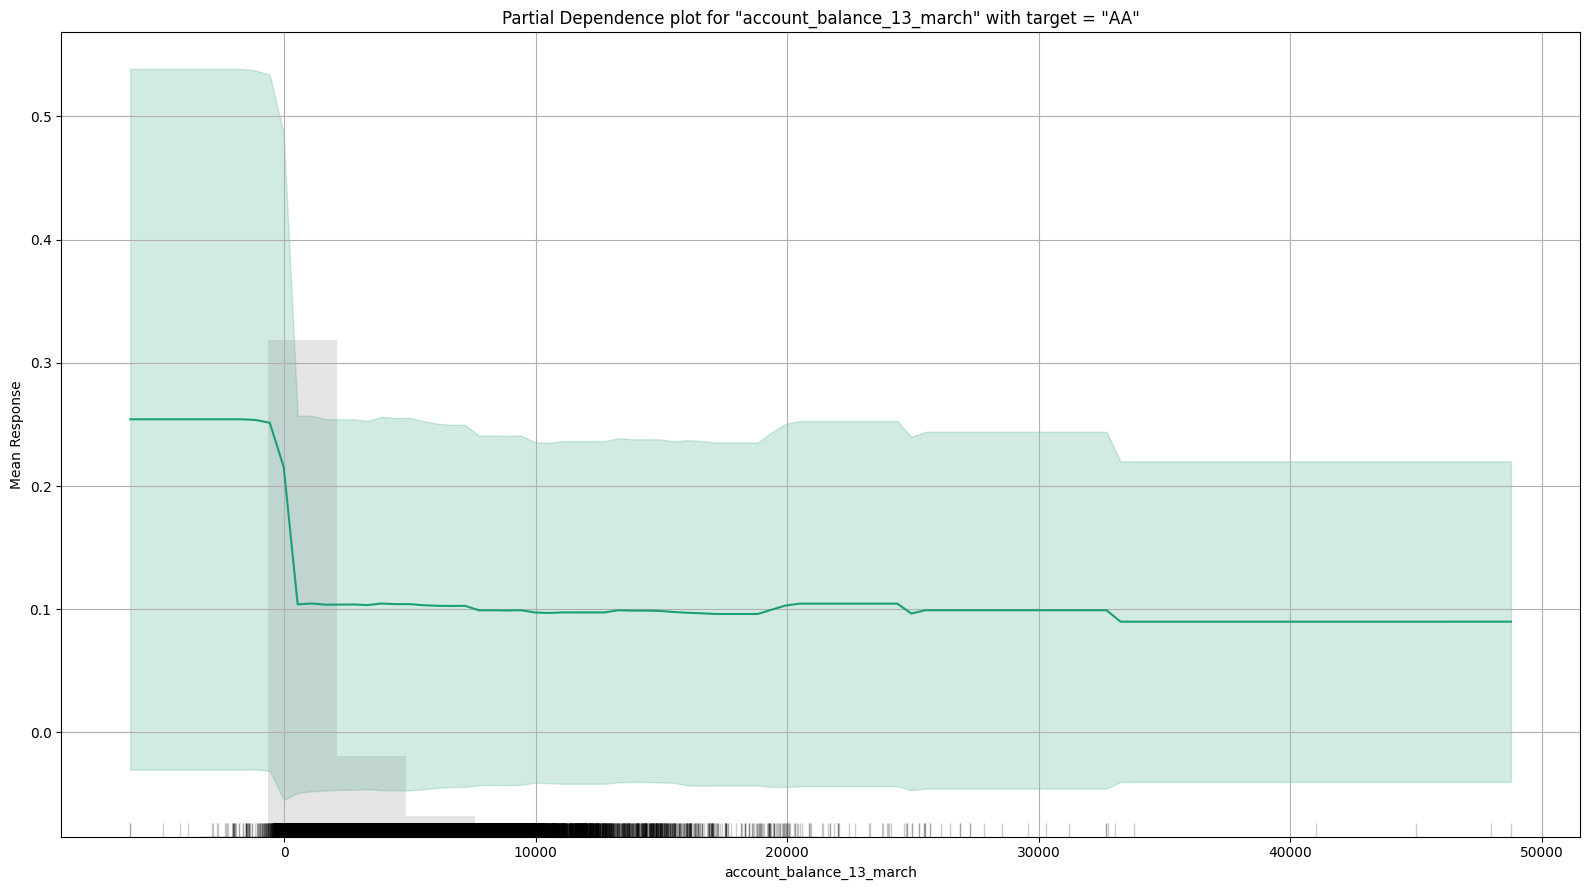

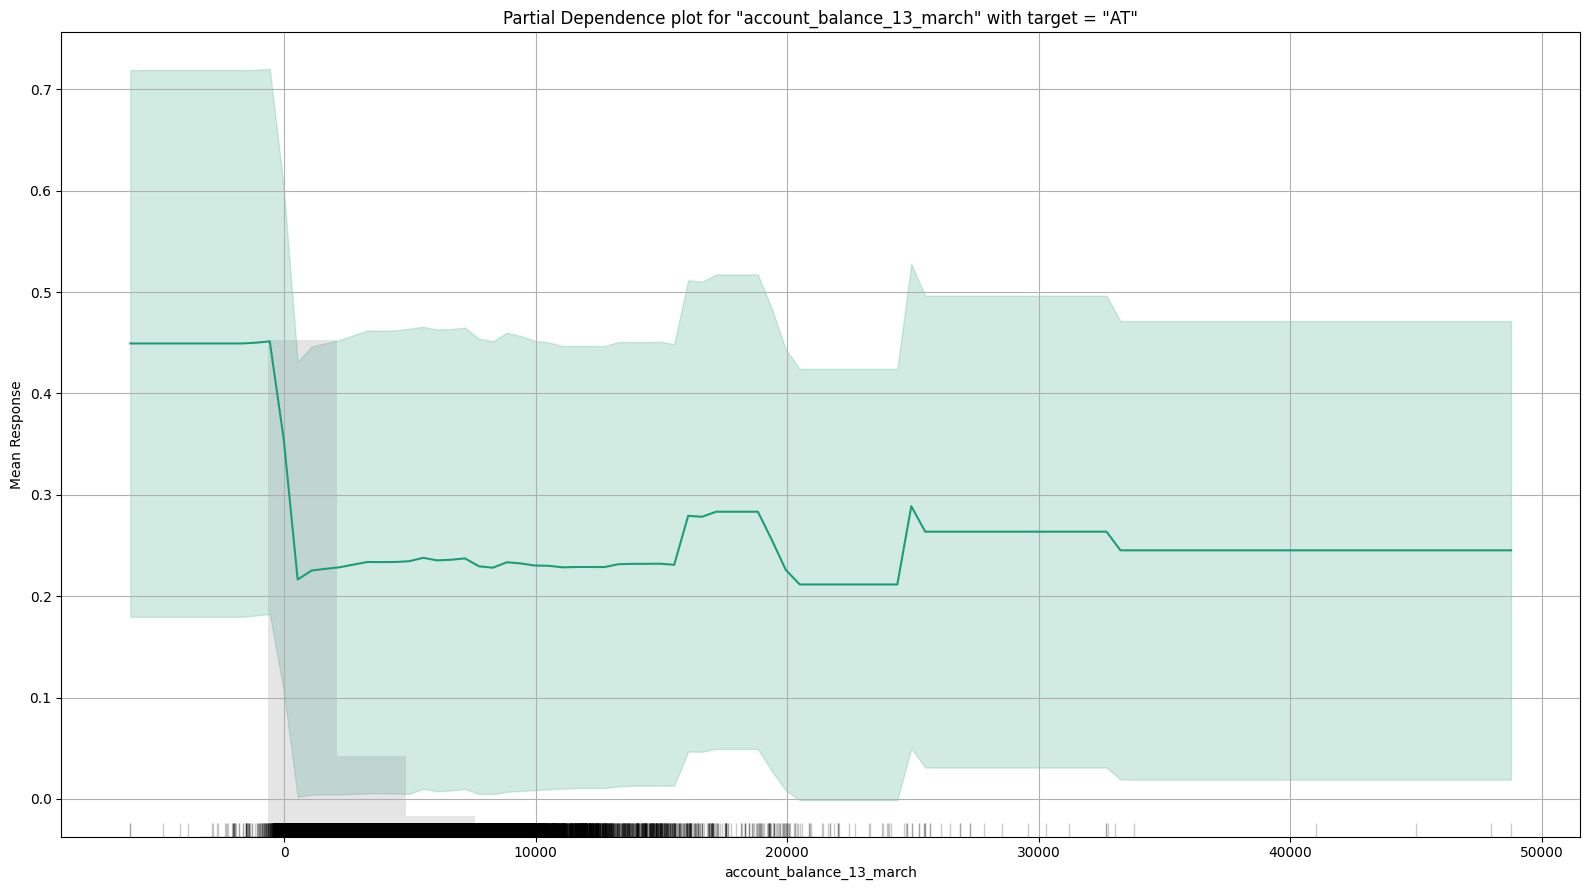

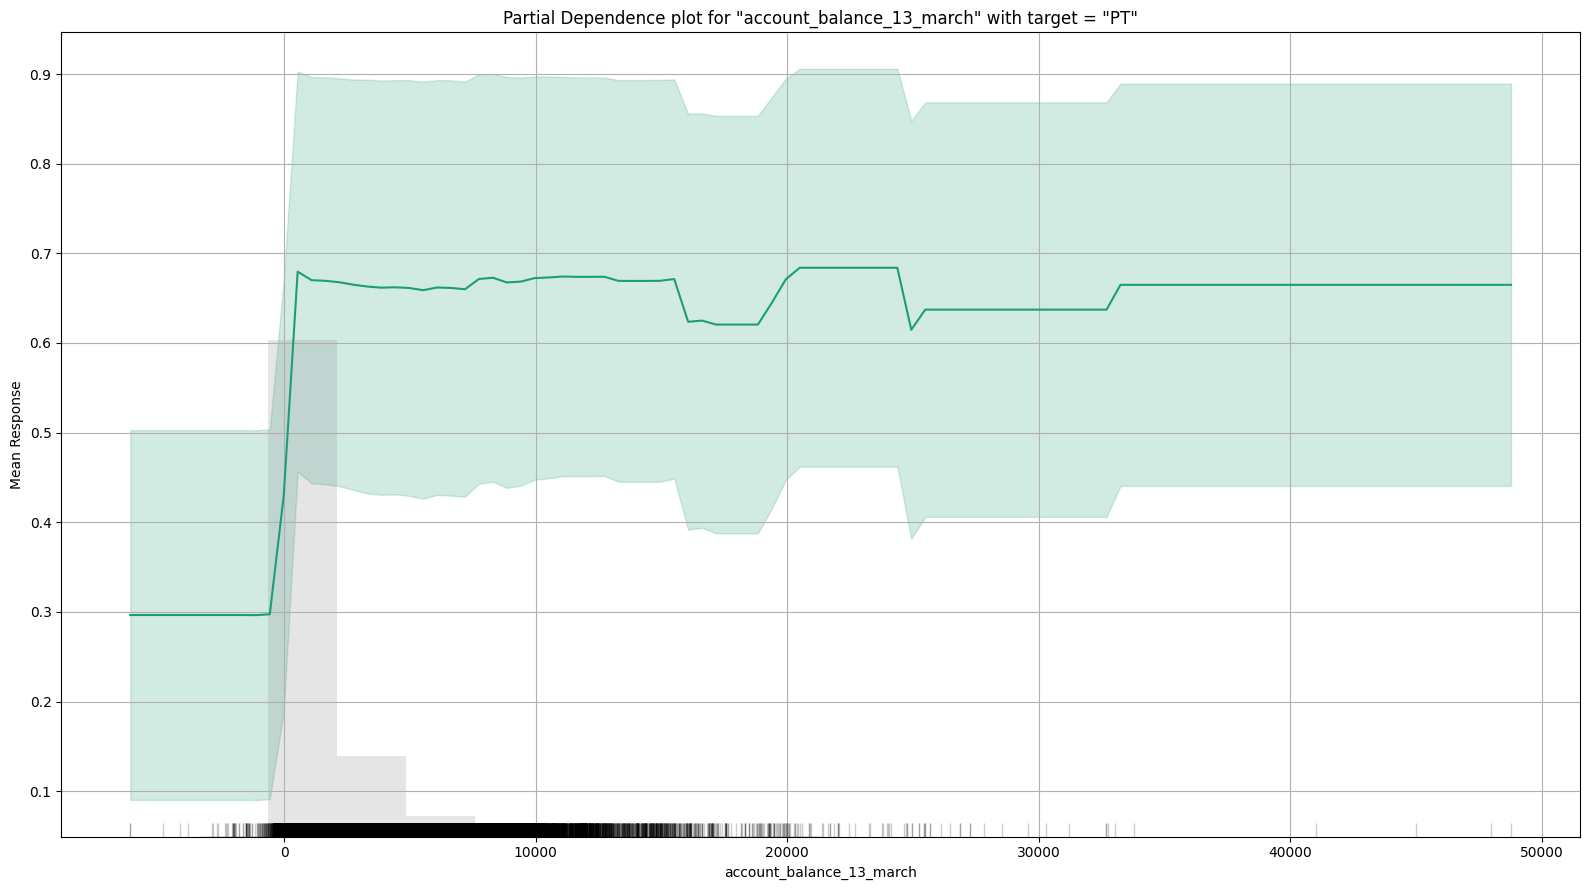

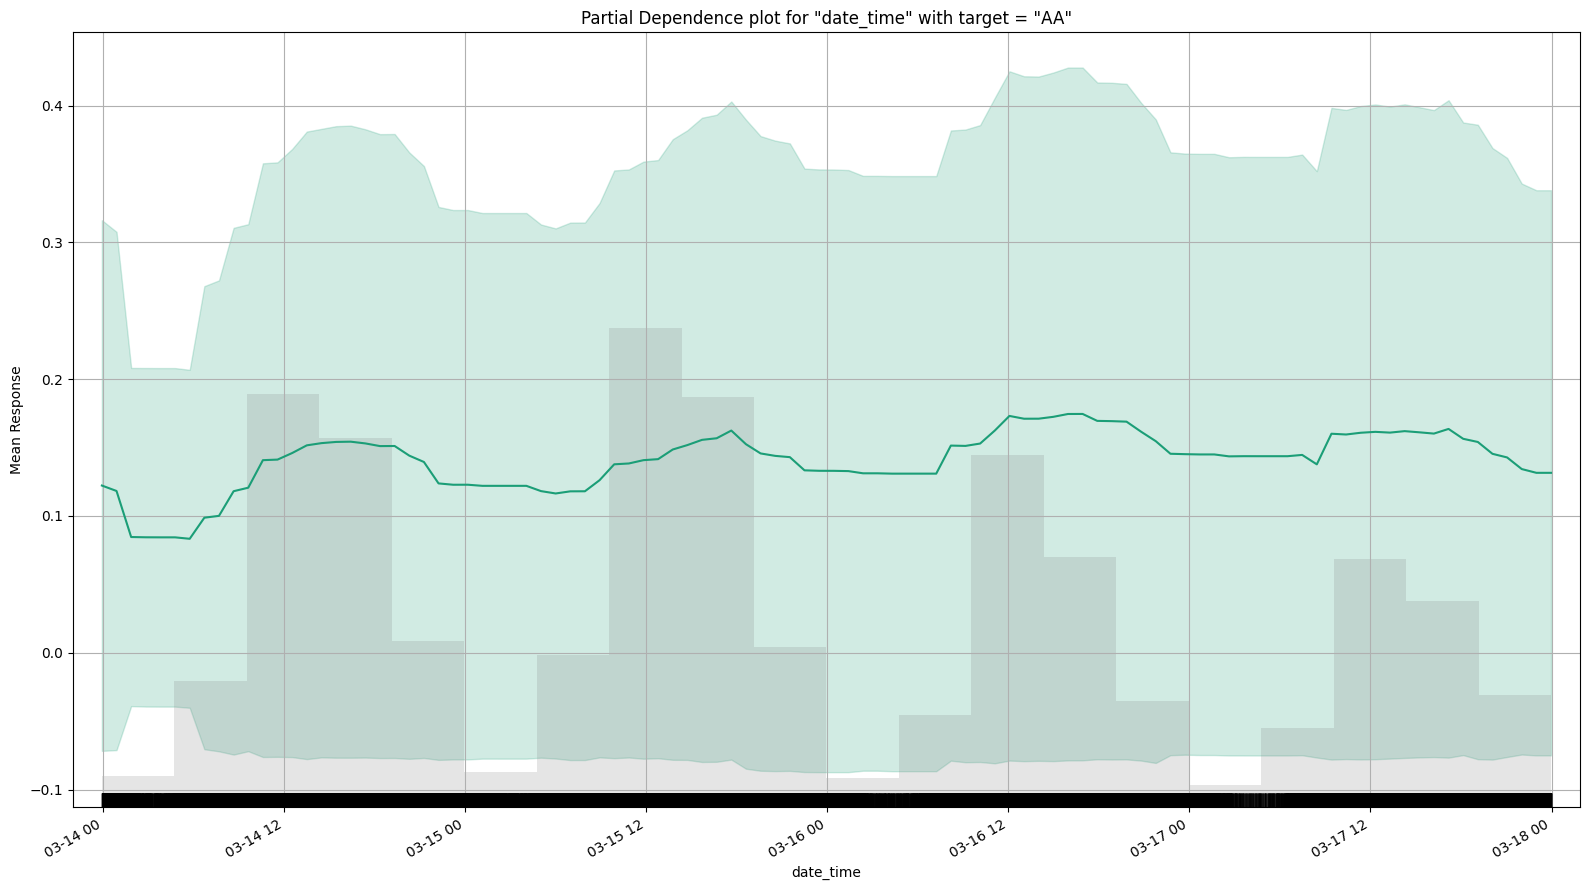

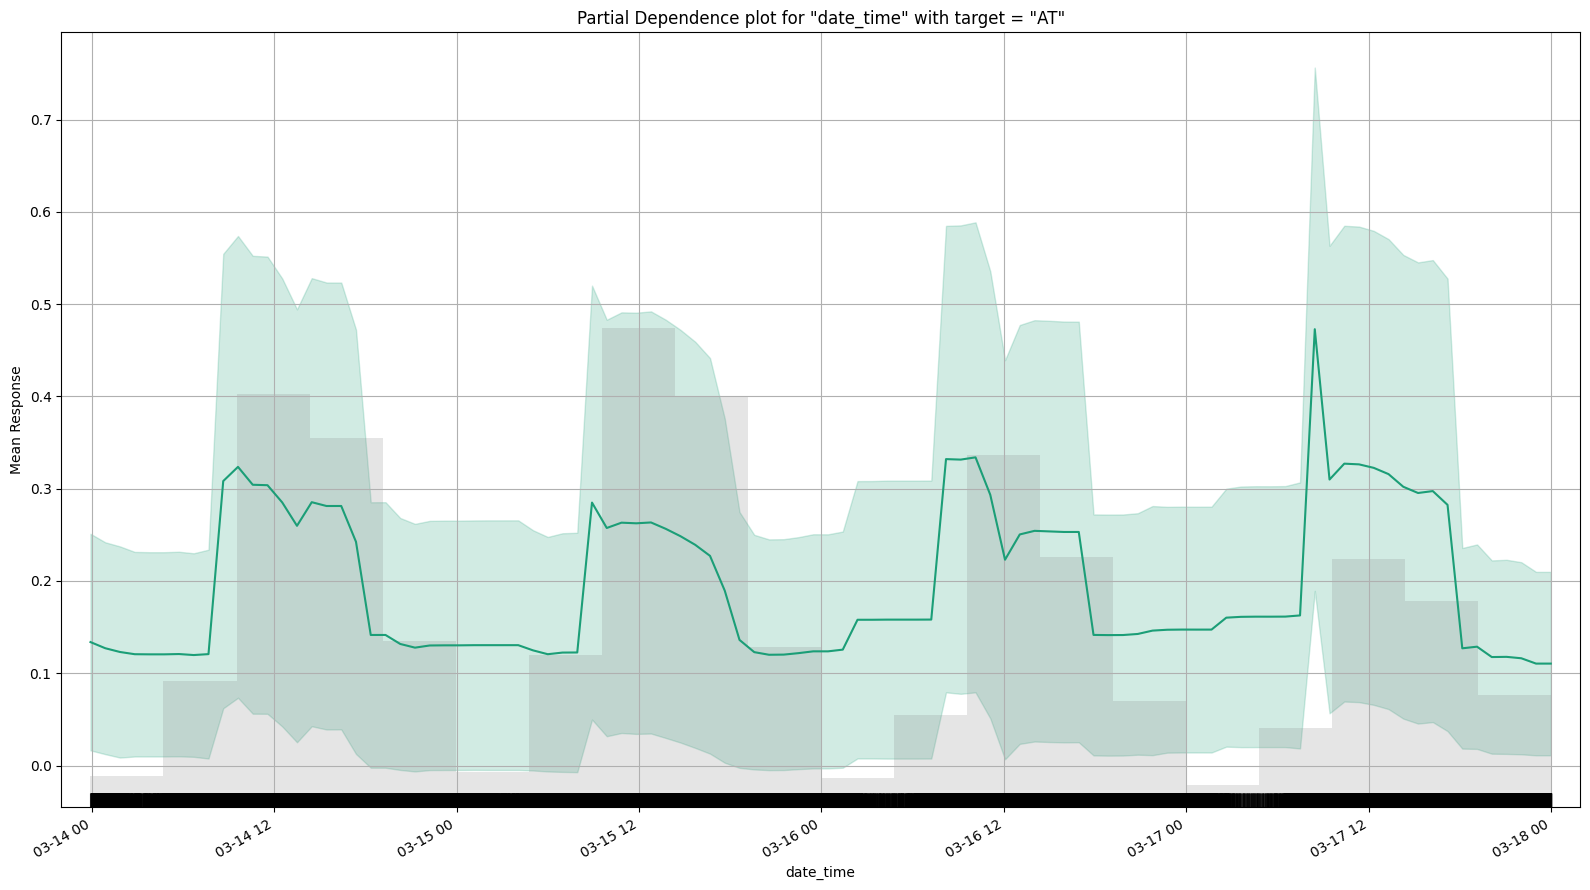

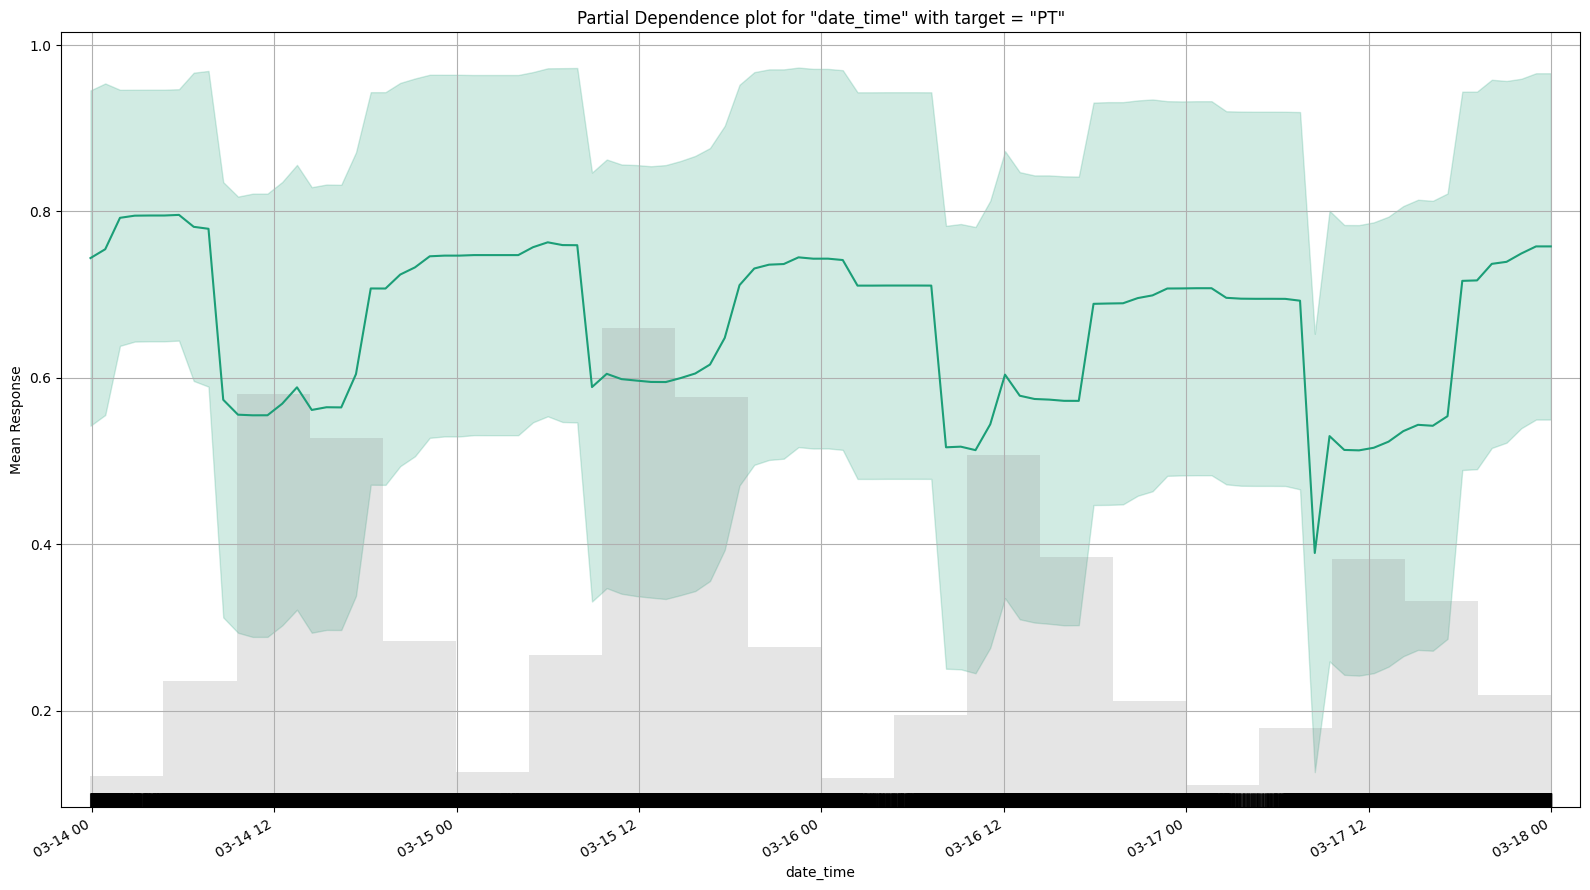

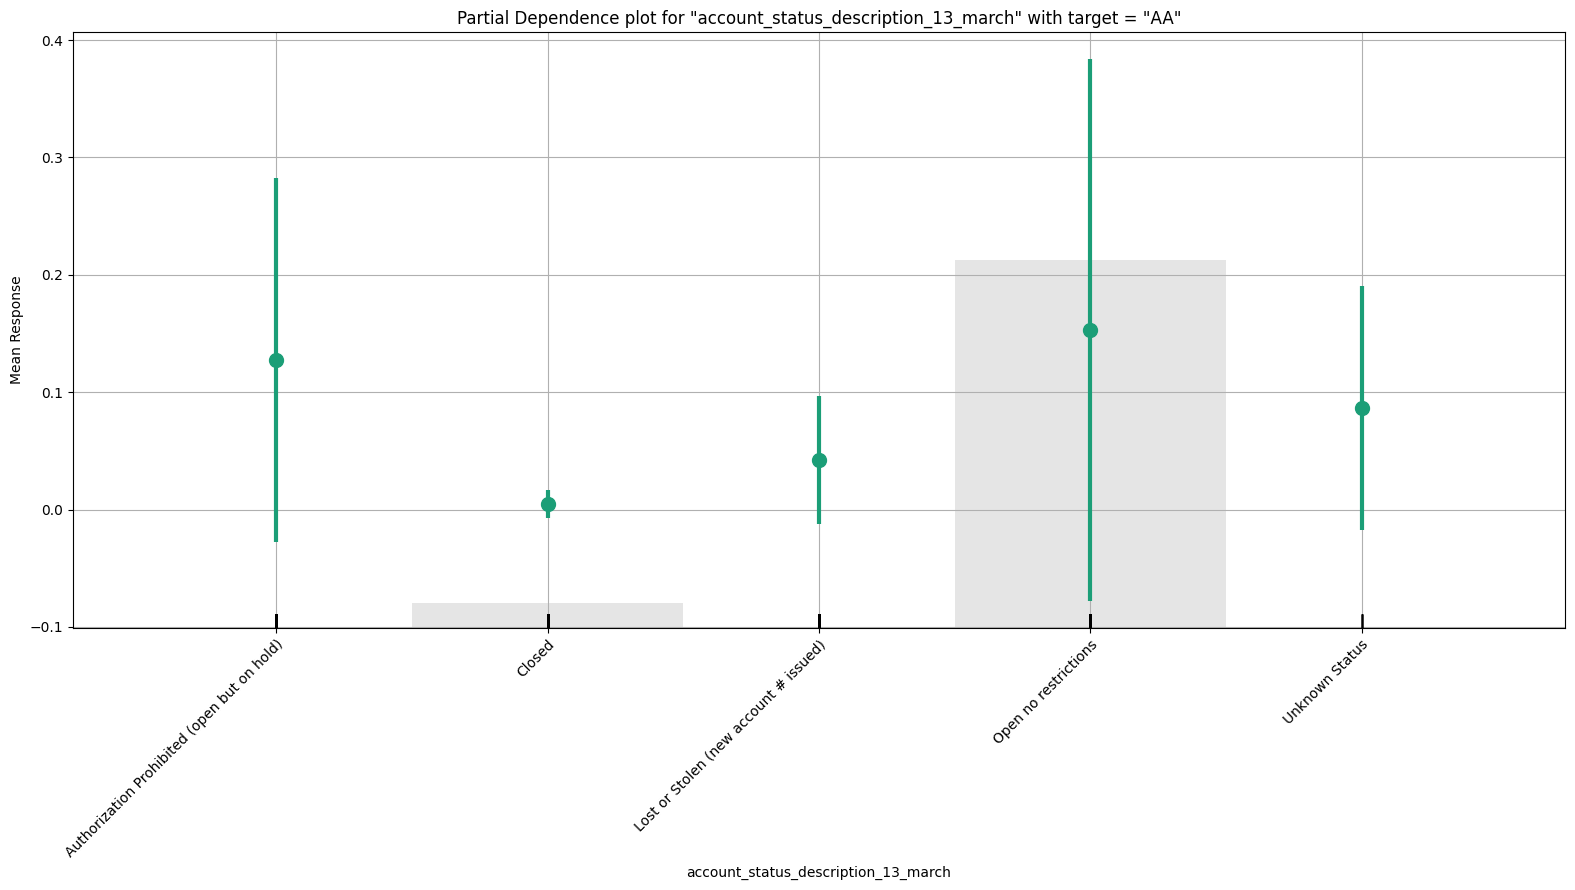

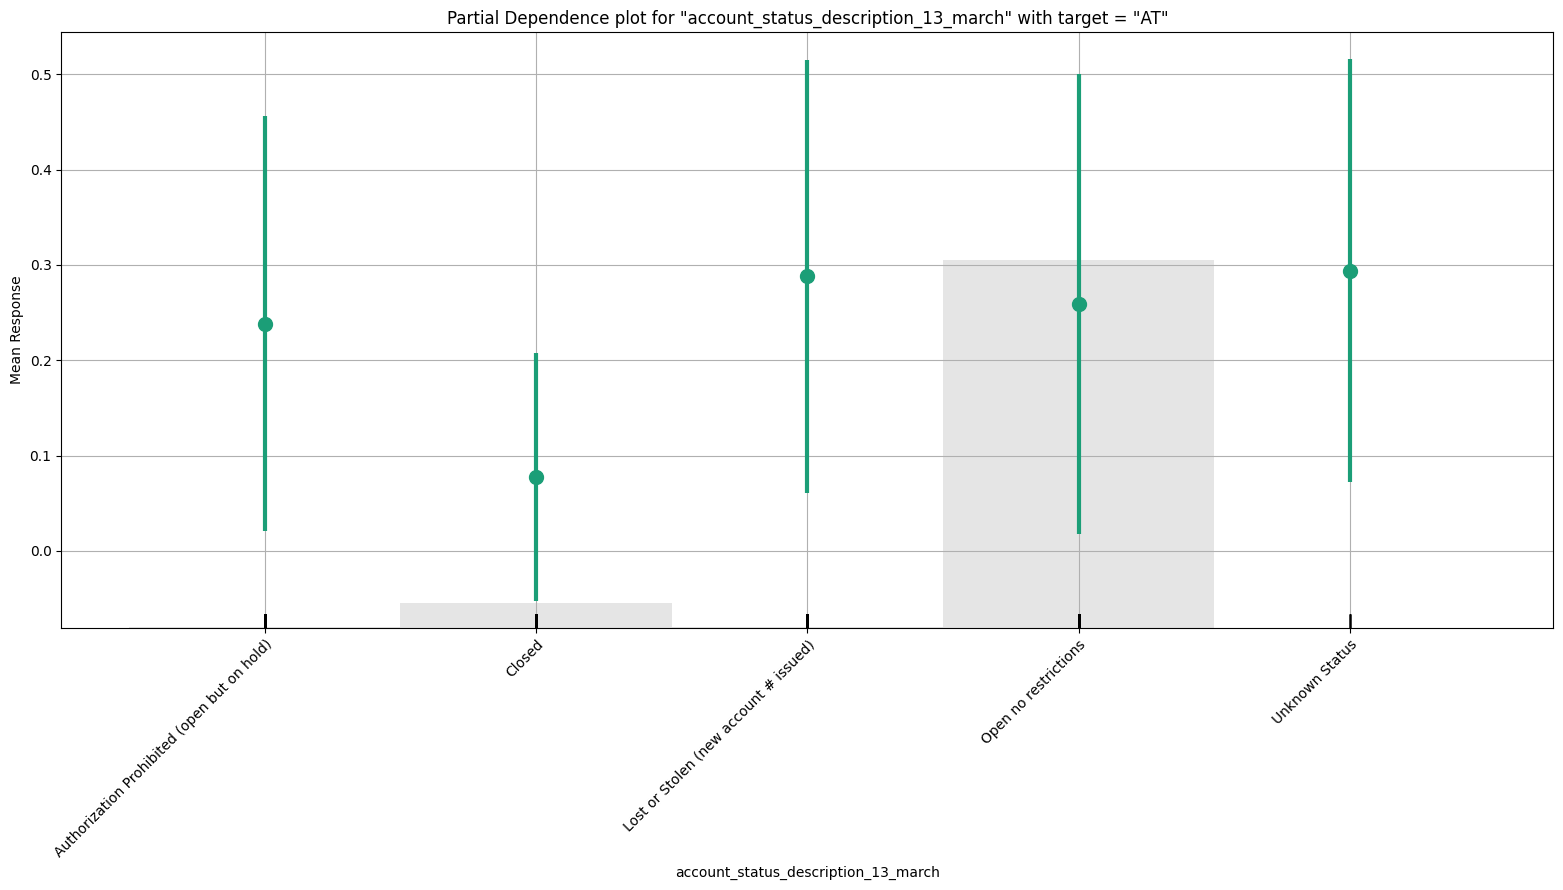

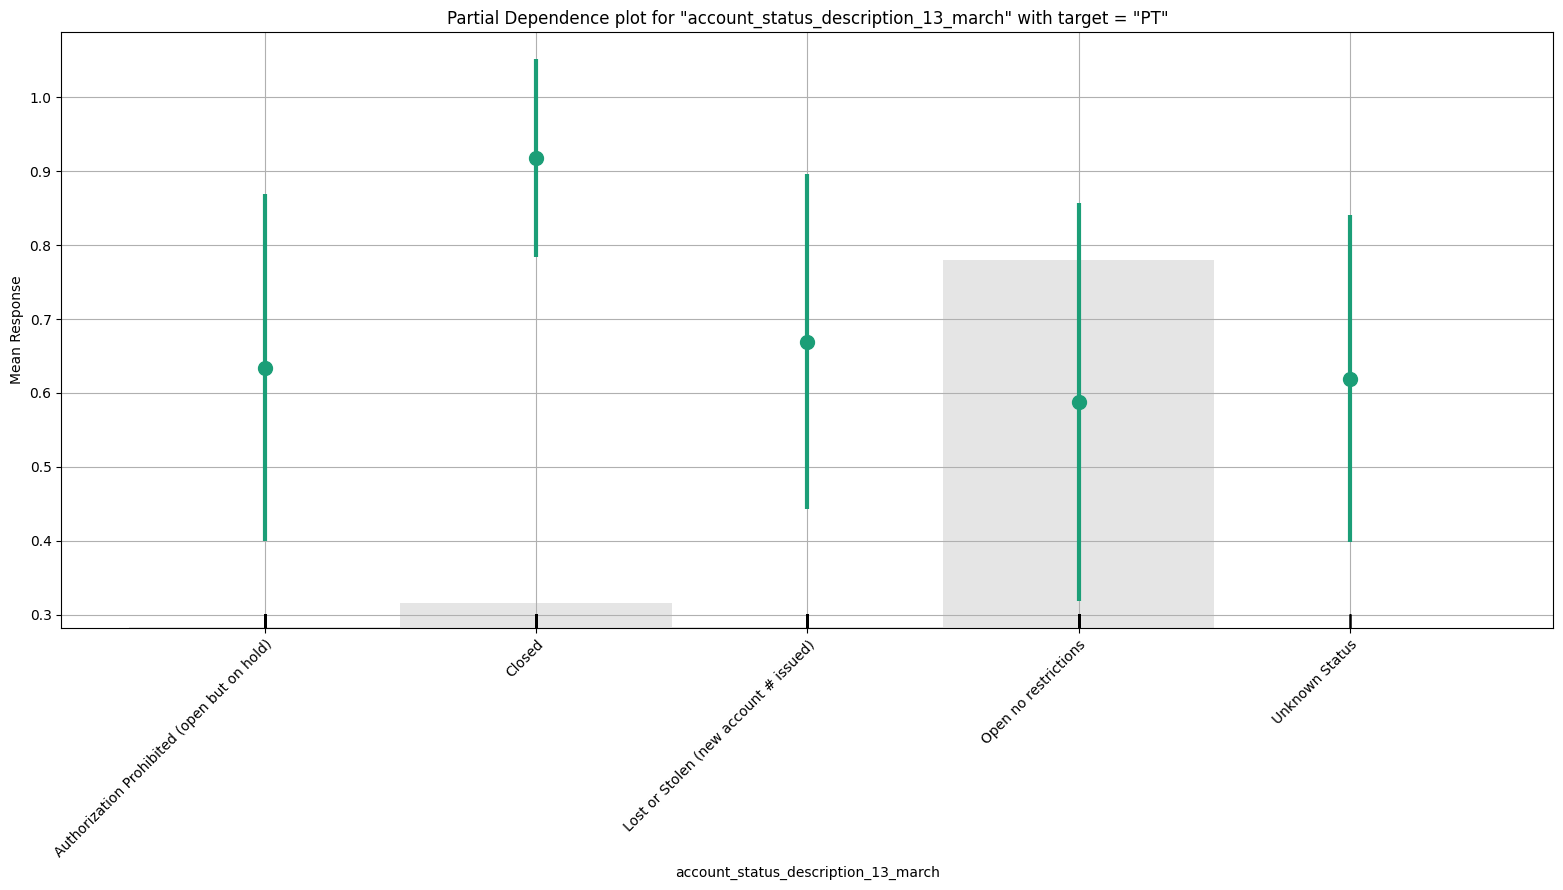

In [34]:
xgboost_model.explain(train)

In [29]:
train.group_by("reason").count().get_frame()

reason      nrow
--------  ------
AA         43939
AT         73262
PT        177271
[3 rows x 2 columns]

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
Model Details
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_model_python_1711293903995_55


Model Summary: 
    number_of_trees
--  -----------------
    50

ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.4166417078241805
RMSE: 0.6454778910421181
LogLoss: 1.264789169219327
Mean Per-Class Error: 0.10404217322361875
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
AA       AP    AT       AU    BA        BL    CA    CB    C

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## XGBoost_model_python_1711293903995_55

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
AA       AP    AT       AU    BA        BL    CA    CB    CD    CS    CT      DE    DP    DR    ER    FD      FI    FM    FR    GA    HI    IA    IC    LC     LS      LW    Ls    MP    NU    OB    PA    PC    PI    PP        PS    PT       Pd    RC    RI    RP    RS    RV    SP    SR    VA    VP    WA    eA    eB    eL    eP    eR    eS    eY    iA    iF    iL    iM    iO    iP    iR    iS    iT    m-    mP    me    mm    mn    mo    mp    mt    ss    wa     Error                Rate
-------  ----  -------  ----  --------  ----  ----  ----  ----  ----  ------  ----  ----  ----  ----  ------  ----  ----  ----  ----  ----  ----  ----  -----  ------  ----  ----  ----  ----  ----  ----  ----  ----  --------  ----  -------  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  -----  -------------------  -------------------
10835.0  0.0   303.0    0.0   20363.0   0.0   0.0   0.0   0.0   0.0   30.0    0.0   0.0   0.0   0.0   51.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    12.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   12117.0   0.0   148.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   10.0   0.753014657275069    33,034 / 43,869
0.0      0.0   0.0      0.0   0.0       0.0   0.0   0.0   0.0   0.0   0.0     0.0   0.0   0.0   0.0   0.0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0       0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    nan                  0 / 0
546.0    0.0   17494.0  0.0   29641.0   0.0   0.0   0.0   0.0   0.0   190.0   0.0   0.0   0.0   0.0   40.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   15.0   20.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   24695.0   0.0   439.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   33.0   0.7607265465785839   55,619 / 73,113
0.0      0.0   0.0      0.0   0.0       0.0   0.0   0.0   0.0   0.0   0.0     0.0   0.0   0.0   0.0   0.0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0       0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    nan                  0 / 0
7039.0   0.0   8893.0   0.0   209040.0  0.0   0.0   0.0   0.0   0.0   1094.0  0.0   0.0   0.0   0.0   571.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   70.0   195.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   217807.0  0.0   8179.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   130.0  0.5385613816669537   243,978 / 453,018
0.0      0.0   0.0      0.0   0.0       0.0   0.0   0.0   0.0   0.0   0.0     0.0   0.0   0.0   0.0   0.0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0       0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

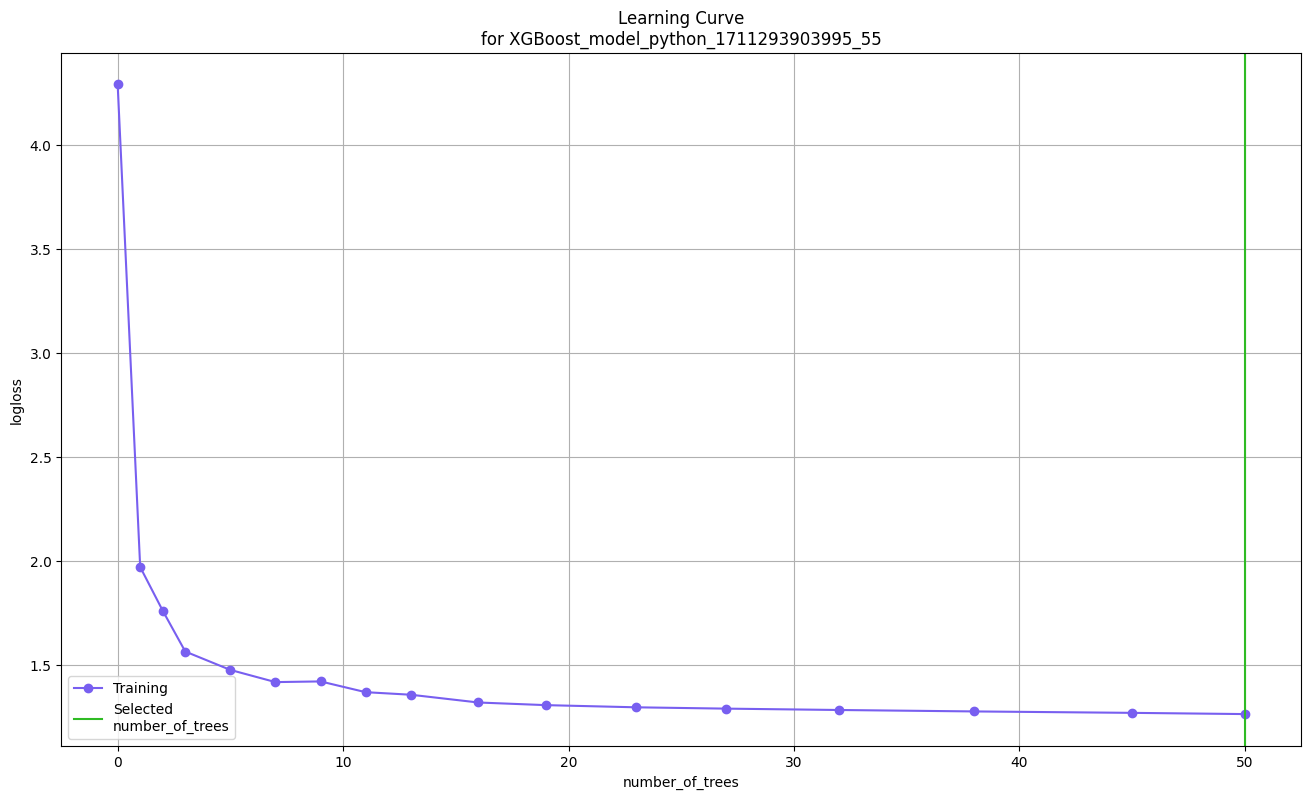

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

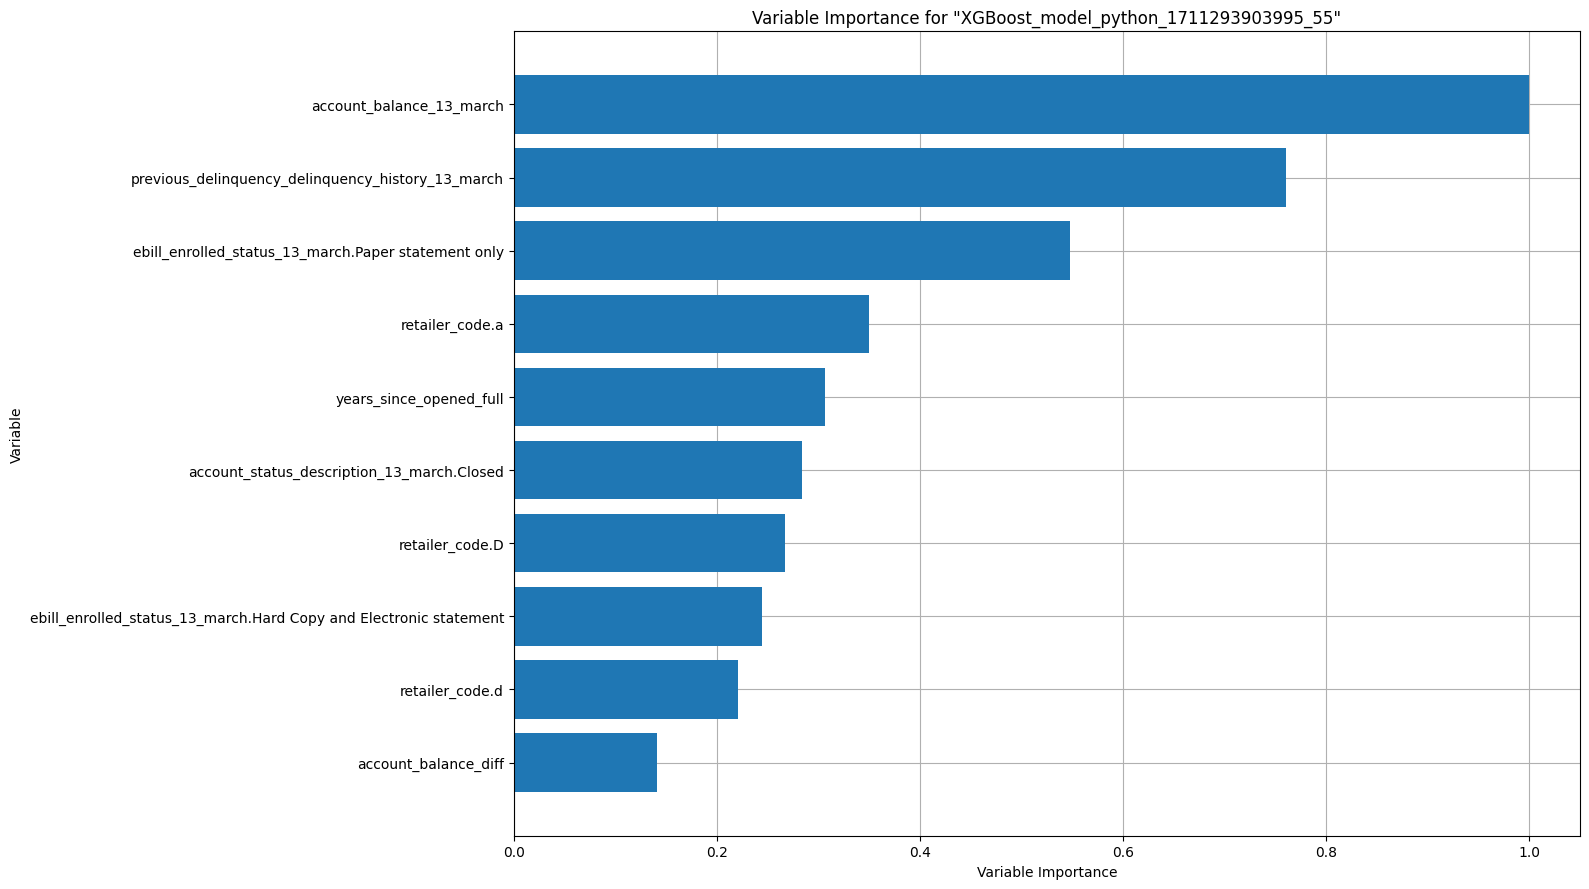

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

In [ ]:
train_and_evaluate_model2(selected_data, 'reason', predictor1)